# Test Training on Colab

## Set up

### install required packages

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install optuna

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-d9waa7h6
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-d9waa7h6
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 1f0fbe89d654232fdc949d7b947b938671657c31
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import and Var

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os

## Common Functions

In [4]:
import numpy as np
from sklearn.metrics import f1_score

def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t}, Best {metric} = {best_score}")

    return best_thresholds, best_scores

In [5]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred, label_cols):
    print(classification_report(y_test, y_pred, target_names=label_cols))
    mcm = multilabel_confusion_matrix(y_test, y_pred)

    n_labels = len(label_cols)
    _, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 4))  # 5 units wide per plot

    for i, matrix in enumerate(mcm):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No ' + label_cols[i], label_cols[i]])
        disp.plot(cmap=plt.cm.Blues, ax=axes[i], colorbar=False)
        axes[i].set_title(f'{label_cols[i]}')

    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_channels)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

In [ ]:
from torch_geometric.utils import from_networkx
import pandas as pd
import pickle

def load_data(mode='txn'):
    graph_feature = pd.read_csv(f'{mode}_graph_features.csv', index_col=0)
    graph_feature.index = graph_feature.index.str.lower()
    graphs = pickle.load(open('txn.pkl', 'rb'))
    y = pd.read_csv('groundtruth.csv', index_col=0)

    label_cols = y.columns.tolist()

    dataset = []
    for i, (address, graph_data) in enumerate(graphs.items()):
        feature = graph_feature.loc[address]
        data = from_networkx(graph_data)

        data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
        data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension
        dataset.append(data)

    return dataset, graph_feature.shape[1], label_cols


In [8]:
def create_trained_model(in_channels, hidden_dim, out_channels, dropout, lr, epochs, train_loader):
    model = GCN(in_channels=in_channels, hidden=hidden_dim, out_channels=out_channels, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return model

def val_model(model, test_loader, thresholds=None):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    if thresholds is None:
        thresholds, _ = tune_thresholds(y_true, y_pred)

    y_pred = (y_pred > thresholds).astype(int)

    return y_true, y_pred, thresholds


In [ ]:
from torch_geometric.loader import DataLoader

def objective(trial, dataset, in_channels, out_channels):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)
    batch_size = trial.suggest_int("batch_size", 16, 256, log=True)
    epochs = trial.suggest_int("epochs", 5, 50)

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model = create_trained_model(in_channels, hidden_dim, out_channels, dropout, lr, epochs, train_loader)
    y_true, y_pred, _ = val_model(model, test_loader)

    return f1_score(y_true, y_pred, average='macro')


In [ ]:
import torch
import json
import optuna
from functools import partial

def get_trained_gcn_model(mode='txn', n_trials=100, save_path=None):
    dataset, in_channel, label_cols = load_data(mode)
    study = optuna.create_study(direction="maximize")
    objective_partial = partial(objective, dataset=dataset, in_channels=in_channel, out_channels=len(label_cols))
    study.optimize(objective_partial, n_trials=n_trials)
    best_params = study.best_params

    print("Best Params:", study.best_params)
    print("Best Score:", study.best_value)

    best_model = create_trained_model(in_channel, best_params['hidden_dim'], len(label_cols), best_params['dropout'], best_params['lr'], best_params['epochs'], DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True))

    y_test, y_pred, thresholds = val_model(best_model, DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=False))

    weights = f1_score(y_test, y_pred, average=None)
    if save_path is not None:
        filename = f'{mode}_model.pth'
        torch.save(best_model.state_dict(), os.path.join(save_path, filename))
        print(f"Model saved to {filename}")

        filename = f'{mode}_best_params.json'
        with open(os.path.join(save_path, filename), 'w') as f:
            data = {
                **best_params,
                'in_channels':in_channel,
                'out_channels':len(label_cols),
                'thresholds': thresholds,
                'weights': weights.tolist()
            }
            json.dump(data, f, indent=4)
        print(f"Best parameters saved to {filename}")


    return best_model, thresholds

## Transaction

In [11]:
import torch
from torch_geometric.loader import DataLoader

model, thresholds = get_trained_gcn_model(mode='txn', save_path='.')

[I 2025-08-01 02:13:58,209] A new study created in memory with name: no-name-74323147-bb29-4afd-9376-3cf0f00062b7


Epoch: 1/16, Loss: 250.1444
Epoch: 2/16, Loss: 27.1306
Epoch: 3/16, Loss: 190.5261
Epoch: 4/16, Loss: 144.8071
Epoch: 5/16, Loss: 125.2576
Epoch: 6/16, Loss: 28.1917
Epoch: 7/16, Loss: 124.3195
Epoch: 8/16, Loss: 3.0021
Epoch: 9/16, Loss: 3.6804
Epoch: 10/16, Loss: 248.6908
Epoch: 11/16, Loss: 195.1434
Epoch: 12/16, Loss: 112.8199
Epoch: 13/16, Loss: 10.2280
Epoch: 14/16, Loss: 107.7779
Epoch: 15/16, Loss: 6.4304
Epoch: 16/16, Loss: 245.4636
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:14:03,717] Trial 0 finished with value: 0.06593406593406594 and parameters: {'hidden_dim': 36, 'lr': 1.4432426976835732e-05, 'dropout': 0.5664324591270556, 'batch_size': 33, 'epochs': 16}. Best is trial 0 with value: 0.06593406593406594.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/8, Loss: 32.1081
Epoch: 2/8, Loss: 29.8377
Epoch: 3/8, Loss: 30.1817
Epoch: 4/8, Loss: 29.4962
Epoch: 5/8, Loss: 31.9116
Epoch: 6/8, Loss: 28.9398
Epoch: 7/8, Loss: 28.7820
Epoch: 8/8, Loss: 28.1000
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.01, Best f1 = 0.2857142857142857


[I 2025-08-01 02:14:07,415] Trial 1 finished with value: 0.22857142857142856 and parameters: {'hidden_dim': 75, 'lr': 4.087545084089711e-05, 'dropout': 0.7400305575833559, 'batch_size': 169, 'epochs': 8}. Best is trial 1 with value: 0.22857142857142856.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 26.7360
Epoch: 2/45, Loss: 26.8713
Epoch: 3/45, Loss: 26.1790
Epoch: 4/45, Loss: 25.9836
Epoch: 5/45, Loss: 26.0237
Epoch: 6/45, Loss: 26.3152
Epoch: 7/45, Loss: 26.1709
Epoch: 8/45, Loss: 26.0819
Epoch: 9/45, Loss: 25.5476
Epoch: 10/45, Loss: 25.7985
Epoch: 11/45, Loss: 25.1975
Epoch: 12/45, Loss: 25.6684
Epoch: 13/45, Loss: 25.3660
Epoch: 14/45, Loss: 25.1622
Epoch: 15/45, Loss: 25.3739
Epoch: 16/45, Loss: 24.5986
Epoch: 17/45, Loss: 25.1197
Epoch: 18/45, Loss: 24.4358
Epoch: 19/45, Loss: 25.0781
Epoch: 20/45, Loss: 24.2209
Epoch: 21/45, Loss: 24.2838
Epoch: 22/45, Loss: 23.7193
Epoch: 23/45, Loss: 23.2900
Epoch: 24/45, Loss: 23.2098
Epoch: 25/45, Loss: 23.0636
Epoch: 26/45, Loss: 23.1136
Epoch: 27/45, Loss: 23.1746
Epoch: 28/45, Loss: 23.1566
Epoch: 29/45, Loss: 22.7515
Epoch: 30/45, Loss: 22.4026
Epoch: 31/45, Loss: 22.9927
Epoch: 32/45, Loss: 22.3447
Epoch: 33/45, Loss: 22.0604
Epoch: 34/45, Loss: 21.4663
Epoch: 35/4

[I 2025-08-01 02:14:27,713] Trial 2 finished with value: 0.20752136752136752 and parameters: {'hidden_dim': 136, 'lr': 7.865548134985651e-06, 'dropout': 0.3356022249455986, 'batch_size': 109, 'epochs': 45}. Best is trial 1 with value: 0.22857142857142856.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/26, Loss: 18.9033
Epoch: 2/26, Loss: 18.7576
Epoch: 3/26, Loss: 17.9797
Epoch: 4/26, Loss: 17.9795
Epoch: 5/26, Loss: 17.8374
Epoch: 6/26, Loss: 17.6761
Epoch: 7/26, Loss: 17.6199
Epoch: 8/26, Loss: 17.4672
Epoch: 9/26, Loss: 17.4095
Epoch: 10/26, Loss: 17.0620
Epoch: 11/26, Loss: 17.0825
Epoch: 12/26, Loss: 16.8602
Epoch: 13/26, Loss: 16.6296
Epoch: 14/26, Loss: 16.0057
Epoch: 15/26, Loss: 15.7268
Epoch: 16/26, Loss: 16.0288
Epoch: 17/26, Loss: 15.8696
Epoch: 18/26, Loss: 15.7204
Epoch: 19/26, Loss: 14.8906
Epoch: 20/26, Loss: 15.2369
Epoch: 21/26, Loss: 15.2962
Epoch: 22/26, Loss: 14.8198
Epoch: 23/26, Loss: 15.1264
Epoch: 24/26, Loss: 14.5290
Epoch: 25/26, Loss: 14.5975
Epoch: 26/26, Loss: 13.3901
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:14:38,948] Trial 3 finished with value: 0.14184397163120568 and parameters: {'hidden_dim': 88, 'lr': 2.6533003260309088e-05, 'dropout': 0.1528980626716665, 'batch_size': 178, 'epochs': 26}. Best is trial 1 with value: 0.22857142857142856.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/47, Loss: 7.6012
Epoch: 2/47, Loss: 7.5226
Epoch: 3/47, Loss: 7.6356
Epoch: 4/47, Loss: 7.5263
Epoch: 5/47, Loss: 7.6169
Epoch: 6/47, Loss: 7.5753
Epoch: 7/47, Loss: 7.4945
Epoch: 8/47, Loss: 7.5668
Epoch: 9/47, Loss: 7.4235
Epoch: 10/47, Loss: 7.4576
Epoch: 11/47, Loss: 7.5152
Epoch: 12/47, Loss: 7.5036
Epoch: 13/47, Loss: 7.5194
Epoch: 14/47, Loss: 7.4377
Epoch: 15/47, Loss: 7.5178
Epoch: 16/47, Loss: 7.4129
Epoch: 17/47, Loss: 7.4217
Epoch: 18/47, Loss: 7.3969
Epoch: 19/47, Loss: 7.4366
Epoch: 20/47, Loss: 7.4626
Epoch: 21/47, Loss: 7.4151
Epoch: 22/47, Loss: 7.3796
Epoch: 23/47, Loss: 7.4239
Epoch: 24/47, Loss: 7.4376
Epoch: 25/47, Loss: 7.3230
Epoch: 26/47, Loss: 7.3339
Epoch: 27/47, Loss: 7.3514
Epoch: 28/47, Loss: 7.5244
Epoch: 29/47, Loss: 7.3482
Epoch: 30/47, Loss: 7.3187
Epoch: 31/47, Loss: 7.2677
Epoch: 32/47, Loss: 7.2877
Epoch: 33/47, Loss: 7.2985
Epoch: 34/47, Loss: 7.2545
Epoch: 35/47, Loss: 7.3255
Epoch: 36/47, Loss

[I 2025-08-01 02:14:57,690] Trial 4 finished with value: 0.0 and parameters: {'hidden_dim': 112, 'lr': 1.6743341668968328e-06, 'dropout': 0.31842090550613006, 'batch_size': 51, 'epochs': 47}. Best is trial 1 with value: 0.22857142857142856.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/36, Loss: 3.0263
Epoch: 2/36, Loss: 8.8182
Epoch: 3/36, Loss: 2.0041
Epoch: 4/36, Loss: 15.2936
Epoch: 5/36, Loss: 12.7222
Epoch: 6/36, Loss: 3.7862
Epoch: 7/36, Loss: 2.8387
Epoch: 8/36, Loss: 3.2042
Epoch: 9/36, Loss: 2.4672
Epoch: 10/36, Loss: 1.8558
Epoch: 11/36, Loss: 2.2162
Epoch: 12/36, Loss: 2.0276
Epoch: 13/36, Loss: 0.9774
Epoch: 14/36, Loss: 1.6607
Epoch: 15/36, Loss: 0.7243
Epoch: 16/36, Loss: 2.4715
Epoch: 17/36, Loss: 1.4590
Epoch: 18/36, Loss: 0.4592
Epoch: 19/36, Loss: 1.4898
Epoch: 20/36, Loss: 1.5034
Epoch: 21/36, Loss: 3.6506
Epoch: 22/36, Loss: 2.2487
Epoch: 23/36, Loss: 2.3154
Epoch: 24/36, Loss: 1.8423
Epoch: 25/36, Loss: 4.7944
Epoch: 26/36, Loss: 1.9836
Epoch: 27/36, Loss: 2.6190
Epoch: 28/36, Loss: 1.2893
Epoch: 29/36, Loss: 1.4066
Epoch: 30/36, Loss: 1.3658
Epoch: 31/36, Loss: 1.7361
Epoch: 32/36, Loss: 1.7161
Epoch: 33/36, Loss: 0.9070
Epoch: 34/36, Loss: 2.2758
Epoch: 35/36, Loss: 1.0800
Epoch: 36/36, Lo

[I 2025-08-01 02:15:39,177] Trial 5 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 230, 'lr': 0.002076702736837576, 'dropout': 0.4688294129229255, 'batch_size': 19, 'epochs': 36}. Best is trial 1 with value: 0.22857142857142856.


Label 2: Best threshold = 0.01, Best f1 = 0.625
Epoch: 1/24, Loss: 26.3826
Epoch: 2/24, Loss: 16.0535
Epoch: 3/24, Loss: 8.7084
Epoch: 4/24, Loss: 1.0433
Epoch: 5/24, Loss: 2.0564
Epoch: 6/24, Loss: 2.8052
Epoch: 7/24, Loss: 3.7651
Epoch: 8/24, Loss: 4.4494
Epoch: 9/24, Loss: 4.2798
Epoch: 10/24, Loss: 4.7020
Epoch: 11/24, Loss: 4.9645
Epoch: 12/24, Loss: 4.8072
Epoch: 13/24, Loss: 4.9525
Epoch: 14/24, Loss: 4.5146
Epoch: 15/24, Loss: 4.7952
Epoch: 16/24, Loss: 3.9636
Epoch: 17/24, Loss: 3.8001
Epoch: 18/24, Loss: 3.6177
Epoch: 19/24, Loss: 3.2663
Epoch: 20/24, Loss: 2.7664
Epoch: 21/24, Loss: 2.4879
Epoch: 22/24, Loss: 2.2175
Epoch: 23/24, Loss: 2.0494
Epoch: 24/24, Loss: 1.4600
Label 0: Best threshold = 0.01, Best f1 = 0.48484848484848486


[I 2025-08-01 02:15:43,099] Trial 6 finished with value: 0.3721424774056353 and parameters: {'hidden_dim': 61, 'lr': 0.0013336739273083216, 'dropout': 0.3178677608097852, 'batch_size': 245, 'epochs': 24}. Best is trial 6 with value: 0.3721424774056353.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/9, Loss: 13.7005
Epoch: 2/9, Loss: 11.2520
Epoch: 3/9, Loss: 13.5756
Epoch: 4/9, Loss: 8.3954
Epoch: 5/9, Loss: 8.8439
Epoch: 6/9, Loss: 5.6355
Epoch: 7/9, Loss: 5.1717
Epoch: 8/9, Loss: 3.8613
Epoch: 9/9, Loss: 3.1458
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:15:47,709] Trial 7 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 131, 'lr': 6.377524039704548e-05, 'dropout': 0.7978089515288871, 'batch_size': 197, 'epochs': 9}. Best is trial 6 with value: 0.3721424774056353.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 0.6305
Epoch: 2/45, Loss: 63.8330
Epoch: 3/45, Loss: 52.4811
Epoch: 4/45, Loss: 41.8616
Epoch: 5/45, Loss: 14.8397
Epoch: 6/45, Loss: 0.9291
Epoch: 7/45, Loss: 7.8434
Epoch: 8/45, Loss: 4.8012
Epoch: 9/45, Loss: 4.0850
Epoch: 10/45, Loss: 9.5764
Epoch: 11/45, Loss: 1.3712
Epoch: 12/45, Loss: 1.7322
Epoch: 13/45, Loss: 7.5162
Epoch: 14/45, Loss: 9.6458
Epoch: 15/45, Loss: 5.6073
Epoch: 16/45, Loss: 4.1724
Epoch: 17/45, Loss: 0.8235
Epoch: 18/45, Loss: 0.6414
Epoch: 19/45, Loss: 1.1586
Epoch: 20/45, Loss: 0.8847
Epoch: 21/45, Loss: 1.7733
Epoch: 22/45, Loss: 0.4428
Epoch: 23/45, Loss: 0.4911
Epoch: 24/45, Loss: 0.4216
Epoch: 25/45, Loss: 1.5226
Epoch: 26/45, Loss: 1.7994
Epoch: 27/45, Loss: 2.5293
Epoch: 28/45, Loss: 1.9040
Epoch: 29/45, Loss: 0.4359
Epoch: 30/45, Loss: 3.0834
Epoch: 31/45, Loss: 0.4009
Epoch: 32/45, Loss: 0.4694
Epoch: 33/45, Loss: 2.7064
Epoch: 34/45, Loss: 0.3313
Epoch: 35/45, Loss: 0.2327
Epoch: 36/45, 

[I 2025-08-01 02:16:09,067] Trial 8 finished with value: 0.4130747126436782 and parameters: {'hidden_dim': 168, 'lr': 0.0037989788904922587, 'dropout': 0.12578143330622585, 'batch_size': 30, 'epochs': 45}. Best is trial 8 with value: 0.4130747126436782.


Label 2: Best threshold = 0.01, Best f1 = 0.6875
Epoch: 1/19, Loss: 5.1606
Epoch: 2/19, Loss: 127.0226
Epoch: 3/19, Loss: 0.0000
Epoch: 4/19, Loss: 0.7724
Epoch: 5/19, Loss: 0.8142
Epoch: 6/19, Loss: 0.0000
Epoch: 7/19, Loss: 0.6821
Epoch: 8/19, Loss: 0.4933
Epoch: 9/19, Loss: 0.0000
Epoch: 10/19, Loss: 0.7149
Epoch: 11/19, Loss: 0.8999
Epoch: 12/19, Loss: 1.6671
Epoch: 13/19, Loss: 0.6024
Epoch: 14/19, Loss: 0.9110
Epoch: 15/19, Loss: 0.0000
Epoch: 16/19, Loss: 4.9900
Epoch: 17/19, Loss: 0.5990
Epoch: 18/19, Loss: 7.5008
Epoch: 19/19, Loss: 0.4827
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:16:11,535] Trial 9 finished with value: 0.16962174940898345 and parameters: {'hidden_dim': 39, 'lr': 3.4067036684312496e-06, 'dropout': 0.21076422183119423, 'batch_size': 18, 'epochs': 19}. Best is trial 8 with value: 0.4130747126436782.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/36, Loss: 61.3440
Epoch: 2/36, Loss: 28.0215
Epoch: 3/36, Loss: 16.5249
Epoch: 4/36, Loss: 15.7177
Epoch: 5/36, Loss: 7.2428
Epoch: 6/36, Loss: 10.4004
Epoch: 7/36, Loss: 25.4305
Epoch: 8/36, Loss: 7.0185
Epoch: 9/36, Loss: 8.0398
Epoch: 10/36, Loss: 9.8631
Epoch: 11/36, Loss: 9.1846
Epoch: 12/36, Loss: 15.2218
Epoch: 13/36, Loss: 15.3009
Epoch: 14/36, Loss: 10.3039
Epoch: 15/36, Loss: 13.0787
Epoch: 16/36, Loss: 14.0886
Epoch: 17/36, Loss: 13.4580
Epoch: 18/36, Loss: 11.5302
Epoch: 19/36, Loss: 8.8516
Epoch: 20/36, Loss: 5.4959
Epoch: 21/36, Loss: 2.8707
Epoch: 22/36, Loss: 2.6966
Epoch: 23/36, Loss: 1.9144
Epoch: 24/36, Loss: 2.4065
Epoch: 25/36, Loss: 1.4269
Epoch: 26/36, Loss: 1.5096
Epoch: 27/36, Loss: 1.1104
Epoch: 28/36, Loss: 1.1412
Epoch: 29/36, Loss: 1.3261
Epoch: 30/36, Loss: 0.7217
Epoch: 31/36, Loss: 1.0111
Epoch: 32/36, Loss: 1.3392
Epoch: 33/36, Loss: 1.2645
Epoch: 34/36, Loss: 1.0668
Epoch: 35/36, Loss: 0.6221
Epoch

[I 2025-08-01 02:16:39,986] Trial 10 finished with value: 0.41724137931034483 and parameters: {'hidden_dim': 198, 'lr': 0.007214699922892367, 'dropout': 0.002771521766642082, 'batch_size': 41, 'epochs': 36}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.7
Epoch: 1/37, Loss: 8.4659
Epoch: 2/37, Loss: 67.6220
Epoch: 3/37, Loss: 29.4142
Epoch: 4/37, Loss: 25.1543
Epoch: 5/37, Loss: 28.8116
Epoch: 6/37, Loss: 15.5809
Epoch: 7/37, Loss: 11.0243
Epoch: 8/37, Loss: 9.0438
Epoch: 9/37, Loss: 4.0005
Epoch: 10/37, Loss: 1.3314
Epoch: 11/37, Loss: 5.2231
Epoch: 12/37, Loss: 4.7663
Epoch: 13/37, Loss: 1.5104
Epoch: 14/37, Loss: 1.9701
Epoch: 15/37, Loss: 2.3597
Epoch: 16/37, Loss: 2.5354
Epoch: 17/37, Loss: 2.1579
Epoch: 18/37, Loss: 2.1141
Epoch: 19/37, Loss: 1.9699
Epoch: 20/37, Loss: 1.7678
Epoch: 21/37, Loss: 1.4715
Epoch: 22/37, Loss: 1.3134
Epoch: 23/37, Loss: 1.1818
Epoch: 24/37, Loss: 1.0929
Epoch: 25/37, Loss: 0.9292
Epoch: 26/37, Loss: 0.7714
Epoch: 27/37, Loss: 0.6603
Epoch: 28/37, Loss: 0.5958
Epoch: 29/37, Loss: 0.5074
Epoch: 30/37, Loss: 0.4642
Epoch: 31/37, Loss: 0.4291
Epoch: 32/37, Loss: 0.4694
Epoch: 33/37, Loss: 0.4896
Epoch: 34/37, Loss: 0.4489
Epoch: 35/37, Loss: 0.4872
Epoch: 36/37

[I 2025-08-01 02:17:03,696] Trial 11 finished with value: 0.33714721586575136 and parameters: {'hidden_dim': 197, 'lr': 0.00980255063479596, 'dropout': 0.004005499729459641, 'batch_size': 37, 'epochs': 37}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.6956521739130435
Epoch: 1/38, Loss: 28.1749
Epoch: 2/38, Loss: 20.6321
Epoch: 3/38, Loss: 13.1597
Epoch: 4/38, Loss: 6.0240
Epoch: 5/38, Loss: 1.7334
Epoch: 6/38, Loss: 2.7026
Epoch: 7/38, Loss: 4.1635
Epoch: 8/38, Loss: 4.2151
Epoch: 9/38, Loss: 3.5941
Epoch: 10/38, Loss: 4.2983
Epoch: 11/38, Loss: 5.0038
Epoch: 12/38, Loss: 5.3584
Epoch: 13/38, Loss: 5.3977
Epoch: 14/38, Loss: 5.1733
Epoch: 15/38, Loss: 4.7525
Epoch: 16/38, Loss: 4.1439
Epoch: 17/38, Loss: 3.9513
Epoch: 18/38, Loss: 4.5194
Epoch: 19/38, Loss: 4.1123
Epoch: 20/38, Loss: 3.4641
Epoch: 21/38, Loss: 3.3975
Epoch: 22/38, Loss: 3.5109
Epoch: 23/38, Loss: 3.4430
Epoch: 24/38, Loss: 3.1861
Epoch: 25/38, Loss: 2.7761
Epoch: 26/38, Loss: 2.2051
Epoch: 27/38, Loss: 1.5466
Epoch: 28/38, Loss: 1.8416
Epoch: 29/38, Loss: 1.7881
Epoch: 30/38, Loss: 1.3679
Epoch: 31/38, Loss: 0.7087
Epoch: 32/38, Loss: 1.4463
Epoch: 33/38, Loss: 1.6426
Epoch: 34/38, Loss: 1.2455
Epoch: 35/38, Loss: 1.3478


[I 2025-08-01 02:17:28,657] Trial 12 finished with value: 0.17777777777777778 and parameters: {'hidden_dim': 172, 'lr': 0.0005355347656176013, 'dropout': 0.02439296505915936, 'batch_size': 73, 'epochs': 38}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/32, Loss: 5.8861
Epoch: 2/32, Loss: 2.6461
Epoch: 3/32, Loss: 26.6503
Epoch: 4/32, Loss: 18.3713
Epoch: 5/32, Loss: 2.9225
Epoch: 6/32, Loss: 6.5297
Epoch: 7/32, Loss: 0.5388
Epoch: 8/32, Loss: 10.3787
Epoch: 9/32, Loss: 0.7456
Epoch: 10/32, Loss: 3.0587
Epoch: 11/32, Loss: 1.8365
Epoch: 12/32, Loss: 4.6704
Epoch: 13/32, Loss: 0.3791
Epoch: 14/32, Loss: 1.0021
Epoch: 15/32, Loss: 0.3312
Epoch: 16/32, Loss: 0.2873
Epoch: 17/32, Loss: 0.8038
Epoch: 18/32, Loss: 0.4951
Epoch: 19/32, Loss: 0.3436
Epoch: 20/32, Loss: 0.6235
Epoch: 21/32, Loss: 0.2642
Epoch: 22/32, Loss: 0.3976
Epoch: 23/32, Loss: 0.3972
Epoch: 24/32, Loss: 0.4455
Epoch: 25/32, Loss: 0.4950
Epoch: 26/32, Loss: 0.4464
Epoch: 27/32, Loss: 0.4753
Epoch: 28/32, Loss: 0.6230
Epoch: 29/32, Loss: 0.4710
Epoch: 30/32, Loss: 0.6870
Epoch: 31/32, Loss: 0.7163
Epoch: 32/32, Loss: 0.7489
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f

[I 2025-08-01 02:17:55,979] Trial 13 finished with value: 0.38730158730158726 and parameters: {'hidden_dim': 253, 'lr': 0.007838389556923512, 'dropout': 0.10905292748583732, 'batch_size': 28, 'epochs': 32}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.7619047619047619
Epoch: 1/49, Loss: 15.8357
Epoch: 2/49, Loss: 8.4425
Epoch: 3/49, Loss: 2.8987
Epoch: 4/49, Loss: 1.9651
Epoch: 5/49, Loss: 4.1233
Epoch: 6/49, Loss: 5.2745
Epoch: 7/49, Loss: 4.5096
Epoch: 8/49, Loss: 3.0695
Epoch: 9/49, Loss: 3.6683
Epoch: 10/49, Loss: 4.4662
Epoch: 11/49, Loss: 4.7647
Epoch: 12/49, Loss: 4.7206
Epoch: 13/49, Loss: 4.3153
Epoch: 14/49, Loss: 3.6971
Epoch: 15/49, Loss: 2.8098
Epoch: 16/49, Loss: 1.7968
Epoch: 17/49, Loss: 2.2866
Epoch: 18/49, Loss: 2.9682
Epoch: 19/49, Loss: 1.9787
Epoch: 20/49, Loss: 1.4056
Epoch: 21/49, Loss: 1.2184
Epoch: 22/49, Loss: 1.0590
Epoch: 23/49, Loss: 1.4739
Epoch: 24/49, Loss: 1.4706
Epoch: 25/49, Loss: 1.3461
Epoch: 26/49, Loss: 0.9963
Epoch: 27/49, Loss: 1.2601
Epoch: 28/49, Loss: 1.1759
Epoch: 29/49, Loss: 0.8634
Epoch: 30/49, Loss: 0.9563
Epoch: 31/49, Loss: 0.8482
Epoch: 32/49, Loss: 1.2412
Epoch: 33/49, Loss: 0.7752
Epoch: 34/49, Loss: 0.5952
Epoch: 35/49, Loss: 1.0409
Ep

[I 2025-08-01 02:18:29,036] Trial 14 finished with value: 0.17777777777777778 and parameters: {'hidden_dim': 177, 'lr': 0.0004529178131704824, 'dropout': 0.21279361111172124, 'batch_size': 59, 'epochs': 49}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 8.8583
Epoch: 2/43, Loss: 8.7811
Epoch: 3/43, Loss: 2.5893
Epoch: 4/43, Loss: 2.8301
Epoch: 5/43, Loss: 0.5177
Epoch: 6/43, Loss: 4.1172
Epoch: 7/43, Loss: 5.3564
Epoch: 8/43, Loss: 1.5486
Epoch: 9/43, Loss: 5.5905
Epoch: 10/43, Loss: 0.8906
Epoch: 11/43, Loss: 4.6246
Epoch: 12/43, Loss: 0.5881
Epoch: 13/43, Loss: 0.5029
Epoch: 14/43, Loss: 4.0336
Epoch: 15/43, Loss: 0.6084
Epoch: 16/43, Loss: 3.4460
Epoch: 17/43, Loss: 2.3632
Epoch: 18/43, Loss: 1.4490
Epoch: 19/43, Loss: 0.8415
Epoch: 20/43, Loss: 1.1132
Epoch: 21/43, Loss: 1.5083
Epoch: 22/43, Loss: 0.6660
Epoch: 23/43, Loss: 1.4048
Epoch: 24/43, Loss: 0.4979
Epoch: 25/43, Loss: 0.6387
Epoch: 26/43, Loss: 1.2846
Epoch: 27/43, Loss: 1.8112
Epoch: 28/43, Loss: 1.1162
Epoch: 29/43, Loss: 0.5598
Epoch: 30/43, Loss: 0.5166
Epoch: 31/43, Loss: 0.4654
Epoch: 32/43, Loss: 0.4937
Epoch: 33/43, Loss: 0.5900
Epoch: 34/43, Loss: 0.7648
Epoch: 35/43, Loss: 0.4943
Epoch: 36/43, Loss

[I 2025-08-01 02:18:53,308] Trial 15 finished with value: 0.0 and parameters: {'hidden_dim': 208, 'lr': 0.00021048749412396617, 'dropout': 0.09033359712659544, 'batch_size': 24, 'epochs': 43}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/31, Loss: 22.4973
Epoch: 2/31, Loss: 14.5723
Epoch: 3/31, Loss: 15.3669
Epoch: 4/31, Loss: 10.5007
Epoch: 5/31, Loss: 20.3578
Epoch: 6/31, Loss: 16.9747
Epoch: 7/31, Loss: 7.3247
Epoch: 8/31, Loss: 10.6658
Epoch: 9/31, Loss: 12.6191
Epoch: 10/31, Loss: 12.3811
Epoch: 11/31, Loss: 12.7691
Epoch: 12/31, Loss: 10.9209
Epoch: 13/31, Loss: 7.7131
Epoch: 14/31, Loss: 5.3033
Epoch: 15/31, Loss: 3.2054
Epoch: 16/31, Loss: 6.3177
Epoch: 17/31, Loss: 6.1611
Epoch: 18/31, Loss: 2.8599
Epoch: 19/31, Loss: 4.9014
Epoch: 20/31, Loss: 5.9893
Epoch: 21/31, Loss: 5.9534
Epoch: 22/31, Loss: 5.0659
Epoch: 23/31, Loss: 5.2933
Epoch: 24/31, Loss: 2.7678
Epoch: 25/31, Loss: 1.1712
Epoch: 26/31, Loss: 2.9181
Epoch: 27/31, Loss: 2.3846
Epoch: 28/31, Loss: 2.9837
Epoch: 29/31, Loss: 3.6638
Epoch: 30/31, Loss: 3.4847
Epoch: 31/31, Loss: 2.5542
Label 0: Best threshold = 0.01, Best f1 = 0.5384615384615384
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256

[I 2025-08-01 02:19:14,141] Trial 16 finished with value: 0.1794871794871795 and parameters: {'hidden_dim': 163, 'lr': 0.0026158414283001578, 'dropout': 0.2131314883305707, 'batch_size': 42, 'epochs': 31}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/41, Loss: 8.6146
Epoch: 2/41, Loss: 41.7294
Epoch: 3/41, Loss: 34.8267
Epoch: 4/41, Loss: 16.5430
Epoch: 5/41, Loss: 14.7671
Epoch: 6/41, Loss: 20.5040
Epoch: 7/41, Loss: 21.5794
Epoch: 8/41, Loss: 19.5374
Epoch: 9/41, Loss: 16.0757
Epoch: 10/41, Loss: 11.9898
Epoch: 11/41, Loss: 7.9803
Epoch: 12/41, Loss: 7.5939
Epoch: 13/41, Loss: 3.8527
Epoch: 14/41, Loss: 2.0906
Epoch: 15/41, Loss: 4.7833
Epoch: 16/41, Loss: 5.6005
Epoch: 17/41, Loss: 5.2321
Epoch: 18/41, Loss: 3.7154
Epoch: 19/41, Loss: 2.1144
Epoch: 20/41, Loss: 2.4252
Epoch: 21/41, Loss: 2.9348
Epoch: 22/41, Loss: 3.0624
Epoch: 23/41, Loss: 2.8192
Epoch: 24/41, Loss: 2.4000
Epoch: 25/41, Loss: 2.7371
Epoch: 26/41, Loss: 2.7106
Epoch: 27/41, Loss: 1.4915
Epoch: 28/41, Loss: 1.2910
Epoch: 29/41, Loss: 1.1451
Epoch: 30/41, Loss: 1.0153
Epoch: 31/41, Loss: 1.4406
Epoch: 32/41, Loss: 1.5938
Epoch: 33/41, Loss: 1.5625
Epoch: 34/41, Loss: 1.3713
Epoch: 35/41, Loss: 1.1201
Epoch: 36

[I 2025-08-01 02:19:55,815] Trial 17 finished with value: 0.3432003432003432 and parameters: {'hidden_dim': 209, 'lr': 0.0036796063277952863, 'dropout': 0.44779535222886585, 'batch_size': 82, 'epochs': 41}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.6486486486486487
Epoch: 1/50, Loss: 22.1138
Epoch: 2/50, Loss: 11.8731
Epoch: 3/50, Loss: 1.9976
Epoch: 4/50, Loss: 2.0465
Epoch: 5/50, Loss: 3.8032
Epoch: 6/50, Loss: 4.6983
Epoch: 7/50, Loss: 5.4527
Epoch: 8/50, Loss: 5.7211
Epoch: 9/50, Loss: 6.6267
Epoch: 10/50, Loss: 6.5958
Epoch: 11/50, Loss: 6.6282
Epoch: 12/50, Loss: 6.8785
Epoch: 13/50, Loss: 6.7575
Epoch: 14/50, Loss: 6.2846
Epoch: 15/50, Loss: 6.1028
Epoch: 16/50, Loss: 5.9266
Epoch: 17/50, Loss: 5.3567
Epoch: 18/50, Loss: 5.1284
Epoch: 19/50, Loss: 4.6518
Epoch: 20/50, Loss: 4.2957
Epoch: 21/50, Loss: 3.6796
Epoch: 22/50, Loss: 3.4224
Epoch: 23/50, Loss: 3.0327
Epoch: 24/50, Loss: 2.4548
Epoch: 25/50, Loss: 1.8192
Epoch: 26/50, Loss: 1.3056
Epoch: 27/50, Loss: 0.8715
Epoch: 28/50, Loss: 1.6399
Epoch: 29/50, Loss: 2.2522
Epoch: 30/50, Loss: 1.6974
Epoch: 31/50, Loss: 0.9421
Epoch: 32/50, Loss: 0.9357
Epoch: 33/50, Loss: 1.2611
Epoch: 34/50, Loss: 1.3351
Epoch: 35/50, Loss: 1.3609
E

[I 2025-08-01 02:20:19,419] Trial 18 finished with value: 0.0 and parameters: {'hidden_dim': 149, 'lr': 0.0006469810293333167, 'dropout': 0.06639217525039884, 'batch_size': 106, 'epochs': 50}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/32, Loss: 15.7290
Epoch: 2/32, Loss: 12.9214
Epoch: 3/32, Loss: 11.4467
Epoch: 4/32, Loss: 9.6297
Epoch: 5/32, Loss: 5.7999
Epoch: 6/32, Loss: 3.8679
Epoch: 7/32, Loss: 1.2316
Epoch: 8/32, Loss: 1.7680
Epoch: 9/32, Loss: 2.7060
Epoch: 10/32, Loss: 3.1405
Epoch: 11/32, Loss: 3.7222
Epoch: 12/32, Loss: 4.1638
Epoch: 13/32, Loss: 4.3483
Epoch: 14/32, Loss: 4.3198
Epoch: 15/32, Loss: 4.1831
Epoch: 16/32, Loss: 4.0166
Epoch: 17/32, Loss: 3.6612
Epoch: 18/32, Loss: 3.1966
Epoch: 19/32, Loss: 3.0668
Epoch: 20/32, Loss: 2.4865
Epoch: 21/32, Loss: 2.0710
Epoch: 22/32, Loss: 1.5090
Epoch: 23/32, Loss: 1.0016
Epoch: 24/32, Loss: 0.9907
Epoch: 25/32, Loss: 1.7099
Epoch: 26/32, Loss: 1.8935
Epoch: 27/32, Loss: 1.6224
Epoch: 28/32, Loss: 1.3628
Epoch: 29/32, Loss: 0.9492
Epoch: 30/32, Loss: 0.6545
Epoch: 31/32, Loss: 0.9008
Epoch: 32/32, Loss: 1.1175
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f

[I 2025-08-01 02:20:58,455] Trial 19 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 239, 'lr': 0.0001694797210772123, 'dropout': 0.6214652105397442, 'batch_size': 47, 'epochs': 32}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.625
Epoch: 1/40, Loss: 28.4495
Epoch: 2/40, Loss: 104.5223
Epoch: 3/40, Loss: 58.5511
Epoch: 4/40, Loss: 10.4126
Epoch: 5/40, Loss: 23.0468
Epoch: 6/40, Loss: 4.0666
Epoch: 7/40, Loss: 2.9278
Epoch: 8/40, Loss: 1.1496
Epoch: 9/40, Loss: 0.8520
Epoch: 10/40, Loss: 1.3998
Epoch: 11/40, Loss: 0.5186
Epoch: 12/40, Loss: 0.6767
Epoch: 13/40, Loss: 0.6523
Epoch: 14/40, Loss: 0.7797
Epoch: 15/40, Loss: 0.4857
Epoch: 16/40, Loss: 1.3359
Epoch: 17/40, Loss: 1.1509
Epoch: 18/40, Loss: 0.5870
Epoch: 19/40, Loss: 0.6885
Epoch: 20/40, Loss: 0.4153
Epoch: 21/40, Loss: 1.1919
Epoch: 22/40, Loss: 1.1086
Epoch: 23/40, Loss: 0.4416
Epoch: 24/40, Loss: 2.0376
Epoch: 25/40, Loss: 0.8390
Epoch: 26/40, Loss: 0.4294
Epoch: 27/40, Loss: 0.7094
Epoch: 28/40, Loss: 0.5162
Epoch: 29/40, Loss: 0.6431
Epoch: 30/40, Loss: 0.4012
Epoch: 31/40, Loss: 0.4135
Epoch: 32/40, Loss: 1.2843
Epoch: 33/40, Loss: 0.8734
Epoch: 34/40, Loss: 4.3322
Epoch: 35/40, Loss: 4.3276
Epoch: 36/

[I 2025-08-01 02:21:17,409] Trial 20 finished with value: 0.2901960784313726 and parameters: {'hidden_dim': 192, 'lr': 0.00461627062073703, 'dropout': 0.16202584963030708, 'batch_size': 24, 'epochs': 40}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/33, Loss: 4.1873
Epoch: 2/33, Loss: 151.6079
Epoch: 3/33, Loss: 8.4526
Epoch: 4/33, Loss: 7.0225
Epoch: 5/33, Loss: 1.2519
Epoch: 6/33, Loss: 16.4904
Epoch: 7/33, Loss: 0.6364
Epoch: 8/33, Loss: 4.1672
Epoch: 9/33, Loss: 0.9504
Epoch: 10/33, Loss: 7.9358
Epoch: 11/33, Loss: 3.7354
Epoch: 12/33, Loss: 3.3889
Epoch: 13/33, Loss: 0.4411
Epoch: 14/33, Loss: 0.7050
Epoch: 15/33, Loss: 0.3754
Epoch: 16/33, Loss: 0.4438
Epoch: 17/33, Loss: 0.8059
Epoch: 18/33, Loss: 0.3332
Epoch: 19/33, Loss: 0.5291
Epoch: 20/33, Loss: 0.6221
Epoch: 21/33, Loss: 0.3642
Epoch: 22/33, Loss: 0.9623
Epoch: 23/33, Loss: 0.3142
Epoch: 24/33, Loss: 0.3911
Epoch: 25/33, Loss: 0.4495
Epoch: 26/33, Loss: 0.9575
Epoch: 27/33, Loss: 0.4996
Epoch: 28/33, Loss: 0.2664
Epoch: 29/33, Loss: 0.9205
Epoch: 30/33, Loss: 0.5812
Epoch: 31/33, Loss: 0.2529
Epoch: 32/33, Loss: 0.5383
Epoch: 33/33, Loss: 0.4088
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: B

[I 2025-08-01 02:21:43,771] Trial 21 finished with value: 0.25 and parameters: {'hidden_dim': 227, 'lr': 0.009899460634253811, 'dropout': 0.10806237532984582, 'batch_size': 31, 'epochs': 33}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.75
Epoch: 1/29, Loss: 5.9109
Epoch: 2/29, Loss: 18.4738
Epoch: 3/29, Loss: 29.6733
Epoch: 4/29, Loss: 20.6706
Epoch: 5/29, Loss: 15.0117
Epoch: 6/29, Loss: 10.0515
Epoch: 7/29, Loss: 1.1803
Epoch: 8/29, Loss: 1.5392
Epoch: 9/29, Loss: 0.5831
Epoch: 10/29, Loss: 3.2264
Epoch: 11/29, Loss: 2.8444
Epoch: 12/29, Loss: 5.3650
Epoch: 13/29, Loss: 7.1119
Epoch: 14/29, Loss: 0.6204
Epoch: 15/29, Loss: 3.1720
Epoch: 16/29, Loss: 1.7688
Epoch: 17/29, Loss: 0.5039
Epoch: 18/29, Loss: 2.2730
Epoch: 19/29, Loss: 5.7938
Epoch: 20/29, Loss: 1.1160
Epoch: 21/29, Loss: 0.8131
Epoch: 22/29, Loss: 2.7857
Epoch: 23/29, Loss: 0.3550
Epoch: 24/29, Loss: 2.9818
Epoch: 25/29, Loss: 1.8947
Epoch: 26/29, Loss: 1.2620
Epoch: 27/29, Loss: 1.0106
Epoch: 28/29, Loss: 0.8019
Epoch: 29/29, Loss: 4.9250
Label 0: Best threshold = 0.01, Best f1 = 0.43478260869565216
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:22:18,614] Trial 22 finished with value: 0.14492753623188406 and parameters: {'hidden_dim': 254, 'lr': 0.0010715514407940777, 'dropout': 0.004851652224557829, 'batch_size': 25, 'epochs': 29}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/35, Loss: 89.1984
Epoch: 2/35, Loss: 87.4386
Epoch: 3/35, Loss: 0.6639
Epoch: 4/35, Loss: 1.9678
Epoch: 5/35, Loss: 2.3495
Epoch: 6/35, Loss: 0.8216
Epoch: 7/35, Loss: 2.5918
Epoch: 8/35, Loss: 2.1654
Epoch: 9/35, Loss: 0.6609
Epoch: 10/35, Loss: 2.2300
Epoch: 11/35, Loss: 0.3449
Epoch: 12/35, Loss: 1.8609
Epoch: 13/35, Loss: 0.5175
Epoch: 14/35, Loss: 1.0337
Epoch: 15/35, Loss: 0.5826
Epoch: 16/35, Loss: 0.4372
Epoch: 17/35, Loss: 0.5330
Epoch: 18/35, Loss: 0.6144
Epoch: 19/35, Loss: 0.7113
Epoch: 20/35, Loss: 0.4084
Epoch: 21/35, Loss: 0.4772
Epoch: 22/35, Loss: 0.7151
Epoch: 23/35, Loss: 0.5056
Epoch: 24/35, Loss: 0.4631
Epoch: 25/35, Loss: 0.3751
Epoch: 26/35, Loss: 0.3312
Epoch: 27/35, Loss: 0.3393
Epoch: 28/35, Loss: 0.4242
Epoch: 29/35, Loss: 0.5142
Epoch: 30/35, Loss: 0.2955
Epoch: 31/35, Loss: 0.3987
Epoch: 32/35, Loss: 0.2971
Epoch: 33/35, Loss: 0.2986
Epoch: 34/35, Loss: 0.4237
Epoch: 35/35, Loss: 0.3561
Label 0: Best th

[I 2025-08-01 02:22:40,245] Trial 23 finished with value: 0.31216931216931215 and parameters: {'hidden_dim': 215, 'lr': 0.006567638253389105, 'dropout': 0.2660149089825357, 'batch_size': 29, 'epochs': 35}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.7142857142857143
Epoch: 1/43, Loss: 1.7795
Epoch: 2/43, Loss: 0.1605
Epoch: 3/43, Loss: 21.6006
Epoch: 4/43, Loss: 1.6554
Epoch: 5/43, Loss: 22.4175
Epoch: 6/43, Loss: 2.8958
Epoch: 7/43, Loss: 8.7310
Epoch: 8/43, Loss: 0.1349
Epoch: 9/43, Loss: 1.4447
Epoch: 10/43, Loss: 0.1630
Epoch: 11/43, Loss: 11.9960
Epoch: 12/43, Loss: 20.3122
Epoch: 13/43, Loss: 0.4159
Epoch: 14/43, Loss: 0.5421
Epoch: 15/43, Loss: 0.8649
Epoch: 16/43, Loss: 0.2876
Epoch: 17/43, Loss: 0.4594
Epoch: 18/43, Loss: 0.4885
Epoch: 19/43, Loss: 0.5356
Epoch: 20/43, Loss: 0.6348
Epoch: 21/43, Loss: 2.2155
Epoch: 22/43, Loss: 5.4244
Epoch: 23/43, Loss: 1.7999
Epoch: 24/43, Loss: 5.5106
Epoch: 25/43, Loss: 0.6795
Epoch: 26/43, Loss: 1.2456
Epoch: 27/43, Loss: 0.9382
Epoch: 28/43, Loss: 0.7972
Epoch: 29/43, Loss: 9.4179
Epoch: 30/43, Loss: 0.3415
Epoch: 31/43, Loss: 0.4224
Epoch: 32/43, Loss: 4.3166
Epoch: 33/43, Loss: 0.4258
Epoch: 34/43, Loss: 0.7938
Epoch: 35/43, Loss: 0.6391

[I 2025-08-01 02:23:16,155] Trial 24 finished with value: 0.0 and parameters: {'hidden_dim': 249, 'lr': 0.003285645955084753, 'dropout': 0.13089997855171517, 'batch_size': 17, 'epochs': 43}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/21, Loss: 26.8303
Epoch: 2/21, Loss: 16.2166
Epoch: 3/21, Loss: 11.6304
Epoch: 4/21, Loss: 5.7647
Epoch: 5/21, Loss: 17.9921
Epoch: 6/21, Loss: 20.1288
Epoch: 7/21, Loss: 17.4522
Epoch: 8/21, Loss: 12.1191
Epoch: 9/21, Loss: 5.4945
Epoch: 10/21, Loss: 6.1109
Epoch: 11/21, Loss: 7.9196
Epoch: 12/21, Loss: 8.5392
Epoch: 13/21, Loss: 8.2764
Epoch: 14/21, Loss: 10.1170
Epoch: 15/21, Loss: 10.1537
Epoch: 16/21, Loss: 7.2267
Epoch: 17/21, Loss: 6.0529
Epoch: 18/21, Loss: 5.2596
Epoch: 19/21, Loss: 3.9815
Epoch: 20/21, Loss: 2.5332
Epoch: 21/21, Loss: 4.4581
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:23:32,909] Trial 25 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 187, 'lr': 0.0012899647774253342, 'dropout': 0.06553596386470427, 'batch_size': 41, 'epochs': 21}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/28, Loss: 38.3381
Epoch: 2/28, Loss: 19.0515
Epoch: 3/28, Loss: 15.5486
Epoch: 4/28, Loss: 16.1937
Epoch: 5/28, Loss: 10.3603
Epoch: 6/28, Loss: 17.9825
Epoch: 7/28, Loss: 13.7409
Epoch: 8/28, Loss: 2.9419
Epoch: 9/28, Loss: 3.4069
Epoch: 10/28, Loss: 3.2655
Epoch: 11/28, Loss: 1.9961
Epoch: 12/28, Loss: 4.6354
Epoch: 13/28, Loss: 3.8917
Epoch: 14/28, Loss: 1.4326
Epoch: 15/28, Loss: 3.1580
Epoch: 16/28, Loss: 3.4525
Epoch: 17/28, Loss: 2.2412
Epoch: 18/28, Loss: 4.7538
Epoch: 19/28, Loss: 4.5592
Epoch: 20/28, Loss: 1.5318
Epoch: 21/28, Loss: 2.8838
Epoch: 22/28, Loss: 6.1303
Epoch: 23/28, Loss: 4.5863
Epoch: 24/28, Loss: 4.7278
Epoch: 25/28, Loss: 3.7119
Epoch: 26/28, Loss: 1.7754
Epoch: 27/28, Loss: 2.3863
Epoch: 28/28, Loss: 5.3586
Label 0: Best threshold = 0.01, Best f1 = 0.47058823529411764
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:23:48,958] Trial 26 finished with value: 0.1568627450980392 and parameters: {'hidden_dim': 157, 'lr': 0.0055456367671694855, 'dropout': 0.17306040479127444, 'batch_size': 62, 'epochs': 28}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/39, Loss: 25.9143
Epoch: 2/39, Loss: 3.2076
Epoch: 3/39, Loss: 10.2697
Epoch: 4/39, Loss: 4.5693
Epoch: 5/39, Loss: 2.6629
Epoch: 6/39, Loss: 0.5858
Epoch: 7/39, Loss: 1.3838
Epoch: 8/39, Loss: 2.6138
Epoch: 9/39, Loss: 1.4366
Epoch: 10/39, Loss: 3.4275
Epoch: 11/39, Loss: 1.4643
Epoch: 12/39, Loss: 1.1336
Epoch: 13/39, Loss: 1.2373
Epoch: 14/39, Loss: 2.3280
Epoch: 15/39, Loss: 1.7675
Epoch: 16/39, Loss: 2.2482
Epoch: 17/39, Loss: 0.6333
Epoch: 18/39, Loss: 0.8115
Epoch: 19/39, Loss: 0.4779
Epoch: 20/39, Loss: 0.6850
Epoch: 21/39, Loss: 0.4821
Epoch: 22/39, Loss: 1.0103
Epoch: 23/39, Loss: 1.6622
Epoch: 24/39, Loss: 0.5392
Epoch: 25/39, Loss: 0.6481
Epoch: 26/39, Loss: 1.1557
Epoch: 27/39, Loss: 0.4237
Epoch: 28/39, Loss: 0.7868
Epoch: 29/39, Loss: 0.9979
Epoch: 30/39, Loss: 0.6926
Epoch: 31/39, Loss: 0.5304
Epoch: 32/39, Loss: 0.5478
Epoch: 33/39, Loss: 0.8448
Epoch: 34/39, Loss: 1.0310
Epoch: 35/39, Loss: 0.9135
Epoch: 36/39, Lo

[I 2025-08-01 02:24:01,443] Trial 27 finished with value: 0.10526315789473684 and parameters: {'hidden_dim': 123, 'lr': 0.00030441073818052687, 'dropout': 0.06260245805209615, 'batch_size': 21, 'epochs': 39}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 0.7465
Epoch: 2/45, Loss: 12.3882
Epoch: 3/45, Loss: 4.4932
Epoch: 4/45, Loss: 6.3335
Epoch: 5/45, Loss: 15.1224
Epoch: 6/45, Loss: 24.7153
Epoch: 7/45, Loss: 5.7949
Epoch: 8/45, Loss: 23.2916
Epoch: 9/45, Loss: 0.5727
Epoch: 10/45, Loss: 9.3795
Epoch: 11/45, Loss: 2.0462
Epoch: 12/45, Loss: 10.3338
Epoch: 13/45, Loss: 0.4958
Epoch: 14/45, Loss: 0.5001
Epoch: 15/45, Loss: 0.9032
Epoch: 16/45, Loss: 3.3051
Epoch: 17/45, Loss: 2.8416
Epoch: 18/45, Loss: 2.3305
Epoch: 19/45, Loss: 4.6344
Epoch: 20/45, Loss: 0.4789
Epoch: 21/45, Loss: 0.3522
Epoch: 22/45, Loss: 9.3892
Epoch: 23/45, Loss: 0.3564
Epoch: 24/45, Loss: 0.9460
Epoch: 25/45, Loss: 7.1662
Epoch: 26/45, Loss: 0.5249
Epoch: 27/45, Loss: 3.8558
Epoch: 28/45, Loss: 2.9195
Epoch: 29/45, Loss: 0.8774
Epoch: 30/45, Loss: 0.6535
Epoch: 31/45, Loss: 0.4075
Epoch: 32/45, Loss: 3.4907
Epoch: 33/45, Loss: 0.9116
Epoch: 34/45, Loss: 1.4848
Epoch: 35/45, Loss: 6.8744
Epoch: 36/45,

[I 2025-08-01 02:24:47,237] Trial 28 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 220, 'lr': 0.002127457690370504, 'dropout': 0.4094556948710406, 'batch_size': 30, 'epochs': 45}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/14, Loss: 0.6400
Epoch: 2/14, Loss: 4.9223
Epoch: 3/14, Loss: 0.6299
Epoch: 4/14, Loss: 27.1380
Epoch: 5/14, Loss: 0.6328
Epoch: 6/14, Loss: 0.6898
Epoch: 7/14, Loss: 1.3447
Epoch: 8/14, Loss: 0.4900
Epoch: 9/14, Loss: 20.4879
Epoch: 10/14, Loss: 0.5534
Epoch: 11/14, Loss: 0.6258
Epoch: 12/14, Loss: 0.5252
Epoch: 13/14, Loss: 0.7852
Epoch: 14/14, Loss: 0.5842
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:24:53,242] Trial 29 finished with value: 0.0 and parameters: {'hidden_dim': 106, 'lr': 0.0009027122627301833, 'dropout': 0.28635940968656726, 'batch_size': 35, 'epochs': 14}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/24, Loss: 19.3719
Epoch: 2/24, Loss: 79.8871
Epoch: 3/24, Loss: 11.5348
Epoch: 4/24, Loss: 38.1797
Epoch: 5/24, Loss: 49.3701
Epoch: 6/24, Loss: 46.7464
Epoch: 7/24, Loss: 37.3996
Epoch: 8/24, Loss: 26.4636
Epoch: 9/24, Loss: 16.3102
Epoch: 10/24, Loss: 7.8856
Epoch: 11/24, Loss: 3.8186
Epoch: 12/24, Loss: 6.8434
Epoch: 13/24, Loss: 10.3605
Epoch: 14/24, Loss: 9.9445
Epoch: 15/24, Loss: 8.1862
Epoch: 16/24, Loss: 6.6401
Epoch: 17/24, Loss: 3.6949
Epoch: 18/24, Loss: 0.9110
Epoch: 19/24, Loss: 1.8758
Epoch: 20/24, Loss: 2.7280
Epoch: 21/24, Loss: 3.1149
Epoch: 22/24, Loss: 3.0497
Epoch: 23/24, Loss: 2.7590
Epoch: 24/24, Loss: 2.3858
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617


[I 2025-08-01 02:25:07,947] Trial 30 finished with value: 0.0 and parameters: {'hidden_dim': 173, 'lr': 0.009848530746117948, 'dropout': 0.5647524625975874, 'batch_size': 49, 'epochs': 24}. Best is trial 10 with value: 0.41724137931034483.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/24, Loss: 21.8554
Epoch: 2/24, Loss: 16.5809
Epoch: 3/24, Loss: 11.7284
Epoch: 4/24, Loss: 12.0253
Epoch: 5/24, Loss: 7.6215
Epoch: 6/24, Loss: 2.8544
Epoch: 7/24, Loss: 1.9441
Epoch: 8/24, Loss: 3.9518
Epoch: 9/24, Loss: 4.8358
Epoch: 10/24, Loss: 4.7977
Epoch: 11/24, Loss: 2.9777
Epoch: 12/24, Loss: 2.8937
Epoch: 13/24, Loss: 3.5537
Epoch: 14/24, Loss: 3.6280
Epoch: 15/24, Loss: 3.3898
Epoch: 16/24, Loss: 2.7259
Epoch: 17/24, Loss: 1.6963
Epoch: 18/24, Loss: 0.9510
Epoch: 19/24, Loss: 2.0055
Epoch: 20/24, Loss: 1.8813
Epoch: 21/24, Loss: 0.6392
Epoch: 22/24, Loss: 1.1661
Epoch: 23/24, Loss: 1.3543
Epoch: 24/24, Loss: 1.3291
Label 0: Best threshold = 0.01, Best f1 = 0.5294117647058824
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:25:12,217] Trial 31 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 46, 'lr': 0.0019053938313882246, 'dropout': 0.25642848909638616, 'batch_size': 133, 'epochs': 24}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/17, Loss: 47.7749
Epoch: 2/17, Loss: 18.0091
Epoch: 3/17, Loss: 22.0029
Epoch: 4/17, Loss: 7.3626
Epoch: 5/17, Loss: 4.4817
Epoch: 6/17, Loss: 6.4129
Epoch: 7/17, Loss: 5.9555
Epoch: 8/17, Loss: 8.0469
Epoch: 9/17, Loss: 7.3471
Epoch: 10/17, Loss: 5.9807
Epoch: 11/17, Loss: 6.1582
Epoch: 12/17, Loss: 5.0252
Epoch: 13/17, Loss: 4.2418
Epoch: 14/17, Loss: 2.9557
Epoch: 15/17, Loss: 2.5705
Epoch: 16/17, Loss: 2.6890
Epoch: 17/17, Loss: 2.8145
Label 0: Best threshold = 0.01, Best f1 = 0.5517241379310345
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:25:15,968] Trial 32 finished with value: 0.3952901597981497 and parameters: {'hidden_dim': 60, 'lr': 0.005763028330435441, 'dropout': 0.347074084357031, 'batch_size': 252, 'epochs': 17}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.6341463414634146
Epoch: 1/14, Loss: 3.3486
Epoch: 2/14, Loss: 35.0871
Epoch: 3/14, Loss: 2.3204
Epoch: 4/14, Loss: 2.5666
Epoch: 5/14, Loss: 4.0099
Epoch: 6/14, Loss: 26.5425
Epoch: 7/14, Loss: 4.7860
Epoch: 8/14, Loss: 7.2373
Epoch: 9/14, Loss: 9.7590
Epoch: 10/14, Loss: 0.6384
Epoch: 11/14, Loss: 7.0129
Epoch: 12/14, Loss: 0.5577
Epoch: 13/14, Loss: 2.0036
Epoch: 14/14, Loss: 5.6484
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:25:19,588] Trial 33 finished with value: 0.21052631578947367 and parameters: {'hidden_dim': 84, 'lr': 0.005654869161501267, 'dropout': 0.37760052232568797, 'batch_size': 28, 'epochs': 14}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/10, Loss: 5.4167
Epoch: 2/10, Loss: 16.4193
Epoch: 3/10, Loss: 23.2843
Epoch: 4/10, Loss: 22.3606
Epoch: 5/10, Loss: 18.2620
Epoch: 6/10, Loss: 12.7308
Epoch: 7/10, Loss: 6.5272
Epoch: 8/10, Loss: 10.7741
Epoch: 9/10, Loss: 13.4356
Epoch: 10/10, Loss: 10.8258
Label 0: Best threshold = 0.01, Best f1 = 0.5142857142857142
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:25:26,658] Trial 34 finished with value: 0.1714285714285714 and parameters: {'hidden_dim': 150, 'lr': 0.0036284892280001348, 'dropout': 0.518797421490107, 'batch_size': 81, 'epochs': 10}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/5, Loss: 55.4212
Epoch: 2/5, Loss: 14.4056
Epoch: 3/5, Loss: 19.1510
Epoch: 4/5, Loss: 24.6988
Epoch: 5/5, Loss: 23.6528
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:25:28,490] Trial 35 finished with value: 0.0 and parameters: {'hidden_dim': 106, 'lr': 0.006491039895378494, 'dropout': 0.10603530496692247, 'batch_size': 37, 'epochs': 5}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/18, Loss: 29.8814
Epoch: 2/18, Loss: 20.4171
Epoch: 3/18, Loss: 9.5615
Epoch: 4/18, Loss: 33.6636
Epoch: 5/18, Loss: 20.8554
Epoch: 6/18, Loss: 5.3038
Epoch: 7/18, Loss: 7.7335
Epoch: 8/18, Loss: 8.1180
Epoch: 9/18, Loss: 16.1243
Epoch: 10/18, Loss: 3.6499
Epoch: 11/18, Loss: 2.8780
Epoch: 12/18, Loss: 8.0029
Epoch: 13/18, Loss: 8.6513
Epoch: 14/18, Loss: 0.5037
Epoch: 15/18, Loss: 4.0303
Epoch: 16/18, Loss: 1.2512
Epoch: 17/18, Loss: 7.4719
Epoch: 18/18, Loss: 2.8350
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:25:37,019] Trial 36 finished with value: 0.0 and parameters: {'hidden_dim': 138, 'lr': 0.0020288149639772764, 'dropout': 0.66702267971746, 'batch_size': 21, 'epochs': 18}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/30, Loss: 20.4763
Epoch: 2/30, Loss: 20.5054
Epoch: 3/30, Loss: 20.5486
Epoch: 4/30, Loss: 20.3654
Epoch: 5/30, Loss: 19.8594
Epoch: 6/30, Loss: 19.8069
Epoch: 7/30, Loss: 19.8849
Epoch: 8/30, Loss: 20.6619
Epoch: 9/30, Loss: 19.8492
Epoch: 10/30, Loss: 19.5073
Epoch: 11/30, Loss: 19.6869
Epoch: 12/30, Loss: 19.5861
Epoch: 13/30, Loss: 19.3377
Epoch: 14/30, Loss: 19.4565
Epoch: 15/30, Loss: 19.6268
Epoch: 16/30, Loss: 19.3338
Epoch: 17/30, Loss: 19.1551
Epoch: 18/30, Loss: 19.4251
Epoch: 19/30, Loss: 19.5021
Epoch: 20/30, Loss: 19.1261
Epoch: 21/30, Loss: 19.0014
Epoch: 22/30, Loss: 19.4838
Epoch: 23/30, Loss: 18.8833
Epoch: 24/30, Loss: 18.8378
Epoch: 25/30, Loss: 18.7849
Epoch: 26/30, Loss: 18.7716
Epoch: 27/30, Loss: 18.7243
Epoch: 28/30, Loss: 18.8114
Epoch: 29/30, Loss: 18.4763
Epoch: 30/30, Loss: 18.3439
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:25:41,537] Trial 37 finished with value: 0.14184397163120568 and parameters: {'hidden_dim': 62, 'lr': 1.8002720577213832e-05, 'dropout': 0.1624712231003412, 'batch_size': 101, 'epochs': 30}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/34, Loss: 14.8060
Epoch: 2/34, Loss: 13.1318
Epoch: 3/34, Loss: 11.1616
Epoch: 4/34, Loss: 8.8138
Epoch: 5/34, Loss: 7.2978
Epoch: 6/34, Loss: 4.2099
Epoch: 7/34, Loss: 2.4131
Epoch: 8/34, Loss: 0.7816
Epoch: 9/34, Loss: 1.4517
Epoch: 10/34, Loss: 2.2661
Epoch: 11/34, Loss: 2.7428
Epoch: 12/34, Loss: 2.6347
Epoch: 13/34, Loss: 2.9534
Epoch: 14/34, Loss: 3.3925
Epoch: 15/34, Loss: 3.2279
Epoch: 16/34, Loss: 2.9261
Epoch: 17/34, Loss: 2.8945
Epoch: 18/34, Loss: 2.5052
Epoch: 19/34, Loss: 2.5014
Epoch: 20/34, Loss: 1.7486
Epoch: 21/34, Loss: 1.2939
Epoch: 22/34, Loss: 0.9971
Epoch: 23/34, Loss: 1.0041
Epoch: 24/34, Loss: 1.3071
Epoch: 25/34, Loss: 1.3301
Epoch: 26/34, Loss: 1.5785
Epoch: 27/34, Loss: 1.0519
Epoch: 28/34, Loss: 0.6387
Epoch: 29/34, Loss: 1.0934
Epoch: 30/34, Loss: 0.8153
Epoch: 31/34, Loss: 0.9704
Epoch: 32/34, Loss: 0.9995
Epoch: 33/34, Loss: 0.9971
Epoch: 34/34, Loss: 1.0897
Label 0: Best threshold = 0.0, Best f1 = 0

[I 2025-08-01 02:26:27,542] Trial 38 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 241, 'lr': 0.00011487523263789102, 'dropout': 0.3725507762828049, 'batch_size': 57, 'epochs': 34}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/26, Loss: 30.9051
Epoch: 2/26, Loss: 30.4204
Epoch: 3/26, Loss: 29.3094
Epoch: 4/26, Loss: 28.7308
Epoch: 5/26, Loss: 28.1623
Epoch: 6/26, Loss: 27.4685
Epoch: 7/26, Loss: 26.6562
Epoch: 8/26, Loss: 26.0768
Epoch: 9/26, Loss: 25.3217
Epoch: 10/26, Loss: 24.5942
Epoch: 11/26, Loss: 23.8836
Epoch: 12/26, Loss: 23.3394
Epoch: 13/26, Loss: 22.6601
Epoch: 14/26, Loss: 22.3544
Epoch: 15/26, Loss: 21.2632
Epoch: 16/26, Loss: 20.5176
Epoch: 17/26, Loss: 19.9150
Epoch: 18/26, Loss: 19.2671
Epoch: 19/26, Loss: 18.4768
Epoch: 20/26, Loss: 17.6969
Epoch: 21/26, Loss: 16.9500
Epoch: 22/26, Loss: 16.2170
Epoch: 23/26, Loss: 15.7365
Epoch: 24/26, Loss: 14.8181
Epoch: 25/26, Loss: 14.2974
Epoch: 26/26, Loss: 13.7808
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:26:33,641] Trial 39 finished with value: 0.23931623931623933 and parameters: {'hidden_dim': 95, 'lr': 4.2489976897644205e-05, 'dropout': 0.03704273773544192, 'batch_size': 149, 'epochs': 26}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.6153846153846154
Epoch: 1/47, Loss: 17.6497
Epoch: 2/47, Loss: 9.1944
Epoch: 3/47, Loss: 4.7832
Epoch: 4/47, Loss: 2.8245
Epoch: 5/47, Loss: 7.0423
Epoch: 6/47, Loss: 3.3507
Epoch: 7/47, Loss: 1.8220
Epoch: 8/47, Loss: 4.5668
Epoch: 9/47, Loss: 4.7484
Epoch: 10/47, Loss: 5.2642
Epoch: 11/47, Loss: 6.1862
Epoch: 12/47, Loss: 5.9602
Epoch: 13/47, Loss: 4.7738
Epoch: 14/47, Loss: 5.7648
Epoch: 15/47, Loss: 5.7028
Epoch: 16/47, Loss: 3.6477
Epoch: 17/47, Loss: 3.6337
Epoch: 18/47, Loss: 3.8281
Epoch: 19/47, Loss: 3.2692
Epoch: 20/47, Loss: 3.8467
Epoch: 21/47, Loss: 3.3405
Epoch: 22/47, Loss: 0.6558
Epoch: 23/47, Loss: 1.5043
Epoch: 24/47, Loss: 1.1121
Epoch: 25/47, Loss: 1.2098
Epoch: 26/47, Loss: 1.5290
Epoch: 27/47, Loss: 0.9905
Epoch: 28/47, Loss: 0.7314
Epoch: 29/47, Loss: 0.8308
Epoch: 30/47, Loss: 0.7041
Epoch: 31/47, Loss: 0.7401
Epoch: 32/47, Loss: 0.6059
Epoch: 33/47, Loss: 0.5656
Epoch: 34/47, Loss: 0.5739
Epoch: 35/47, Loss: 0.8279
Ep

[I 2025-08-01 02:27:29,805] Trial 40 finished with value: 0.0 and parameters: {'hidden_dim': 197, 'lr': 0.0015373159377627427, 'dropout': 0.12880067314551527, 'batch_size': 223, 'epochs': 47}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/20, Loss: 14.7896
Epoch: 2/20, Loss: 2.3010
Epoch: 3/20, Loss: 9.0886
Epoch: 4/20, Loss: 3.3657
Epoch: 5/20, Loss: 2.1353
Epoch: 6/20, Loss: 3.9709
Epoch: 7/20, Loss: 5.9085
Epoch: 8/20, Loss: 5.5917
Epoch: 9/20, Loss: 5.7616
Epoch: 10/20, Loss: 5.3438
Epoch: 11/20, Loss: 5.5667
Epoch: 12/20, Loss: 5.6868
Epoch: 13/20, Loss: 5.2551
Epoch: 14/20, Loss: 4.5137
Epoch: 15/20, Loss: 3.9272
Epoch: 16/20, Loss: 2.6764
Epoch: 17/20, Loss: 1.2942
Epoch: 18/20, Loss: 0.9048
Epoch: 19/20, Loss: 3.9324
Epoch: 20/20, Loss: 3.7113
Label 0: Best threshold = 0.01, Best f1 = 0.5161290322580645
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:27:33,515] Trial 41 finished with value: 0.36251920122887865 and parameters: {'hidden_dim': 63, 'lr': 0.0033281239589649, 'dropout': 0.35775729319063554, 'batch_size': 250, 'epochs': 20}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/23, Loss: 17.9034
Epoch: 2/23, Loss: 17.6361
Epoch: 3/23, Loss: 17.2746
Epoch: 4/23, Loss: 16.9509
Epoch: 5/23, Loss: 16.7054
Epoch: 6/23, Loss: 18.0401
Epoch: 7/23, Loss: 17.4729
Epoch: 8/23, Loss: 17.1162
Epoch: 9/23, Loss: 17.0204
Epoch: 10/23, Loss: 17.4085
Epoch: 11/23, Loss: 17.0246
Epoch: 12/23, Loss: 17.2062
Epoch: 13/23, Loss: 16.8888
Epoch: 14/23, Loss: 17.2166
Epoch: 15/23, Loss: 17.5907
Epoch: 16/23, Loss: 17.1481
Epoch: 17/23, Loss: 16.6230
Epoch: 18/23, Loss: 17.5044
Epoch: 19/23, Loss: 16.2253
Epoch: 20/23, Loss: 16.2916
Epoch: 21/23, Loss: 16.7284
Epoch: 22/23, Loss: 17.1736
Epoch: 23/23, Loss: 16.0513
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:27:36,220] Trial 42 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 42, 'lr': 7.057207164894806e-06, 'dropout': 0.3107493201241217, 'batch_size': 199, 'epochs': 23}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/17, Loss: 8.3151
Epoch: 2/17, Loss: 16.6412
Epoch: 3/17, Loss: 8.2473
Epoch: 4/17, Loss: 2.9015
Epoch: 5/17, Loss: 10.0090
Epoch: 6/17, Loss: 6.7764
Epoch: 7/17, Loss: 6.8007
Epoch: 8/17, Loss: 5.2517
Epoch: 9/17, Loss: 3.0164
Epoch: 10/17, Loss: 5.2280
Epoch: 11/17, Loss: 6.4360
Epoch: 12/17, Loss: 5.9643
Epoch: 13/17, Loss: 3.5762
Epoch: 14/17, Loss: 0.5023
Epoch: 15/17, Loss: 4.4274
Epoch: 16/17, Loss: 4.5070
Epoch: 17/17, Loss: 5.2495
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:27:40,118] Trial 43 finished with value: 0.0 and parameters: {'hidden_dim': 63, 'lr': 0.007184516331571799, 'dropout': 0.22379776364951476, 'batch_size': 238, 'epochs': 17}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/36, Loss: 26.4645
Epoch: 2/36, Loss: 20.7500
Epoch: 3/36, Loss: 20.3044
Epoch: 4/36, Loss: 17.7076
Epoch: 5/36, Loss: 14.5981
Epoch: 6/36, Loss: 13.9296
Epoch: 7/36, Loss: 13.0810
Epoch: 8/36, Loss: 11.2276
Epoch: 9/36, Loss: 9.4101
Epoch: 10/36, Loss: 8.8585
Epoch: 11/36, Loss: 7.4580
Epoch: 12/36, Loss: 4.8002
Epoch: 13/36, Loss: 3.5360
Epoch: 14/36, Loss: 1.7696
Epoch: 15/36, Loss: 1.8436
Epoch: 16/36, Loss: 1.8756
Epoch: 17/36, Loss: 2.3979
Epoch: 18/36, Loss: 2.7902
Epoch: 19/36, Loss: 3.2657
Epoch: 20/36, Loss: 3.4072
Epoch: 21/36, Loss: 3.7278
Epoch: 22/36, Loss: 4.0876
Epoch: 23/36, Loss: 3.6145
Epoch: 24/36, Loss: 3.6770
Epoch: 25/36, Loss: 4.3753
Epoch: 26/36, Loss: 3.4523
Epoch: 27/36, Loss: 3.7098
Epoch: 28/36, Loss: 3.0382
Epoch: 29/36, Loss: 3.0384
Epoch: 30/36, Loss: 2.6889
Epoch: 31/36, Loss: 2.3460
Epoch: 32/36, Loss: 3.0096
Epoch: 33/36, Loss: 2.3901
Epoch: 34/36, Loss: 1.3426
Epoch: 35/36, Loss: 1.6441
Epoch: 36/

[I 2025-08-01 02:27:44,574] Trial 44 finished with value: 0.33809523809523806 and parameters: {'hidden_dim': 32, 'lr': 0.0007570643989134663, 'dropout': 0.49108719165819703, 'batch_size': 173, 'epochs': 36}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/15, Loss: 34.1221
Epoch: 2/15, Loss: 11.2117
Epoch: 3/15, Loss: 2.3022
Epoch: 4/15, Loss: 3.6292
Epoch: 5/15, Loss: 4.7866
Epoch: 6/15, Loss: 4.8559
Epoch: 7/15, Loss: 4.0259
Epoch: 8/15, Loss: 3.1674
Epoch: 9/15, Loss: 2.4291
Epoch: 10/15, Loss: 2.2136
Epoch: 11/15, Loss: 2.3699
Epoch: 12/15, Loss: 1.2840
Epoch: 13/15, Loss: 1.8482
Epoch: 14/15, Loss: 1.8638
Epoch: 15/15, Loss: 2.1202
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:27:48,709] Trial 45 finished with value: 0.0 and parameters: {'hidden_dim': 74, 'lr': 0.004555565542788896, 'dropout': 0.42067990856400655, 'batch_size': 136, 'epochs': 15}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/11, Loss: 30.9982
Epoch: 2/11, Loss: 8.2364
Epoch: 3/11, Loss: 4.7304
Epoch: 4/11, Loss: 13.3753
Epoch: 5/11, Loss: 4.5606
Epoch: 6/11, Loss: 3.3921
Epoch: 7/11, Loss: 9.7360
Epoch: 8/11, Loss: 11.3099
Epoch: 9/11, Loss: 8.7775
Epoch: 10/11, Loss: 10.1022
Epoch: 11/11, Loss: 12.1801
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:27:53,013] Trial 46 finished with value: 0.0 and parameters: {'hidden_dim': 117, 'lr': 0.0027680989890321974, 'dropout': 0.3350479640258313, 'batch_size': 203, 'epochs': 11}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/22, Loss: 46.1716
Epoch: 2/22, Loss: 43.4896
Epoch: 3/22, Loss: 40.8446
Epoch: 4/22, Loss: 38.2744
Epoch: 5/22, Loss: 35.7327
Epoch: 6/22, Loss: 33.1431
Epoch: 7/22, Loss: 30.7491
Epoch: 8/22, Loss: 27.9847
Epoch: 9/22, Loss: 25.5954
Epoch: 10/22, Loss: 23.0929
Epoch: 11/22, Loss: 21.0769
Epoch: 12/22, Loss: 18.8268
Epoch: 13/22, Loss: 16.6402
Epoch: 14/22, Loss: 14.3631
Epoch: 15/22, Loss: 11.9659
Epoch: 16/22, Loss: 9.8770
Epoch: 17/22, Loss: 7.6604
Epoch: 18/22, Loss: 5.6476
Epoch: 19/22, Loss: 3.9766
Epoch: 20/22, Loss: 3.5680
Epoch: 21/22, Loss: 3.2997
Epoch: 22/22, Loss: 2.9991
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:27:56,683] Trial 47 finished with value: 0.08888888888888889 and parameters: {'hidden_dim': 53, 'lr': 0.0003830930330866489, 'dropout': 0.038487058123758355, 'batch_size': 40, 'epochs': 22}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/27, Loss: 11.9812
Epoch: 2/27, Loss: 18.3158
Epoch: 3/27, Loss: 15.9670
Epoch: 4/27, Loss: 20.2692
Epoch: 5/27, Loss: 4.1642
Epoch: 6/27, Loss: 3.6229
Epoch: 7/27, Loss: 2.8801
Epoch: 8/27, Loss: 3.2209
Epoch: 9/27, Loss: 4.5228
Epoch: 10/27, Loss: 14.0068
Epoch: 11/27, Loss: 33.2950
Epoch: 12/27, Loss: 7.9015
Epoch: 13/27, Loss: 17.5415
Epoch: 14/27, Loss: 7.3648
Epoch: 15/27, Loss: 9.4622
Epoch: 16/27, Loss: 19.9963
Epoch: 17/27, Loss: 2.5429
Epoch: 18/27, Loss: 9.9606
Epoch: 19/27, Loss: 14.1018
Epoch: 20/27, Loss: 2.7834
Epoch: 21/27, Loss: 22.8192
Epoch: 22/27, Loss: 19.4760
Epoch: 23/27, Loss: 10.4261
Epoch: 24/27, Loss: 3.9425
Epoch: 25/27, Loss: 15.2784
Epoch: 26/27, Loss: 18.1624
Epoch: 27/27, Loss: 10.2793
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:28:10,816] Trial 48 finished with value: 0.20440080014548098 and parameters: {'hidden_dim': 165, 'lr': 1.052944363810249e-06, 'dropout': 0.23461104595592625, 'batch_size': 26, 'epochs': 27}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/31, Loss: 31.9891
Epoch: 2/31, Loss: 0.6276
Epoch: 3/31, Loss: 2.5396
Epoch: 4/31, Loss: 1.6498
Epoch: 5/31, Loss: 0.4998
Epoch: 6/31, Loss: 0.6254
Epoch: 7/31, Loss: 10.6033
Epoch: 8/31, Loss: 1.0827
Epoch: 9/31, Loss: 1.1584
Epoch: 10/31, Loss: 6.3831
Epoch: 11/31, Loss: 1.5437
Epoch: 12/31, Loss: 2.7849
Epoch: 13/31, Loss: 3.4045
Epoch: 14/31, Loss: 7.0792
Epoch: 15/31, Loss: 0.5340
Epoch: 16/31, Loss: 5.1111
Epoch: 17/31, Loss: 0.4452
Epoch: 18/31, Loss: 0.1955
Epoch: 19/31, Loss: 0.7204
Epoch: 20/31, Loss: 2.3151
Epoch: 21/31, Loss: 0.3947
Epoch: 22/31, Loss: 8.3020
Epoch: 23/31, Loss: 1.5285
Epoch: 24/31, Loss: 17.9253
Epoch: 25/31, Loss: 23.4853
Epoch: 26/31, Loss: 0.3842
Epoch: 27/31, Loss: 4.4645
Epoch: 28/31, Loss: 0.4958
Epoch: 29/31, Loss: 0.4875
Epoch: 30/31, Loss: 0.3198
Epoch: 31/31, Loss: 0.6724
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:28:38,254] Trial 49 finished with value: 0.0 and parameters: {'hidden_dim': 187, 'lr': 0.0014201436808864256, 'dropout': 0.18260070490042646, 'batch_size': 33, 'epochs': 31}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/41, Loss: 86.0290
Epoch: 2/41, Loss: 18.5017
Epoch: 3/41, Loss: 26.3177
Epoch: 4/41, Loss: 11.2464
Epoch: 5/41, Loss: 1.4443
Epoch: 6/41, Loss: 18.5626
Epoch: 7/41, Loss: 0.5725
Epoch: 8/41, Loss: 14.0580
Epoch: 9/41, Loss: 15.5928
Epoch: 10/41, Loss: 8.6916
Epoch: 11/41, Loss: 0.9032
Epoch: 12/41, Loss: 5.0717
Epoch: 13/41, Loss: 2.5080
Epoch: 14/41, Loss: 0.4566
Epoch: 15/41, Loss: 3.5417
Epoch: 16/41, Loss: 0.7542
Epoch: 17/41, Loss: 4.8592
Epoch: 18/41, Loss: 1.5694
Epoch: 19/41, Loss: 0.3453
Epoch: 20/41, Loss: 1.4098
Epoch: 21/41, Loss: 0.5735
Epoch: 22/41, Loss: 0.5179
Epoch: 23/41, Loss: 0.9512
Epoch: 24/41, Loss: 0.9952
Epoch: 25/41, Loss: 1.0690
Epoch: 26/41, Loss: 0.3073
Epoch: 27/41, Loss: 1.6082
Epoch: 28/41, Loss: 0.6333
Epoch: 29/41, Loss: 0.5475
Epoch: 30/41, Loss: 1.0328
Epoch: 31/41, Loss: 1.1571
Epoch: 32/41, Loss: 0.7496
Epoch: 33/41, Loss: 0.7448
Epoch: 34/41, Loss: 0.4008
Epoch: 35/41, Loss: 0.5772
Epoch: 36/4

[I 2025-08-01 02:28:59,331] Trial 50 finished with value: 0.2333333333333333 and parameters: {'hidden_dim': 181, 'lr': 0.007496825672281422, 'dropout': 0.30404203609053093, 'batch_size': 20, 'epochs': 41}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.7
Epoch: 1/20, Loss: 16.4809
Epoch: 2/20, Loss: 6.3978
Epoch: 3/20, Loss: 3.9463
Epoch: 4/20, Loss: 6.7298
Epoch: 5/20, Loss: 7.5928
Epoch: 6/20, Loss: 7.1432
Epoch: 7/20, Loss: 5.7801
Epoch: 8/20, Loss: 3.7299
Epoch: 9/20, Loss: 3.9477
Epoch: 10/20, Loss: 3.5105
Epoch: 11/20, Loss: 0.9839
Epoch: 12/20, Loss: 4.0323
Epoch: 13/20, Loss: 4.5194
Epoch: 14/20, Loss: 2.2414
Epoch: 15/20, Loss: 2.1027
Epoch: 16/20, Loss: 1.4542
Epoch: 17/20, Loss: 2.7160
Epoch: 18/20, Loss: 3.7682
Epoch: 19/20, Loss: 2.3806
Epoch: 20/20, Loss: 1.3279
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:29:03,997] Trial 51 finished with value: 0.2380952380952381 and parameters: {'hidden_dim': 73, 'lr': 0.0038107181352510632, 'dropout': 0.3546394382609837, 'batch_size': 240, 'epochs': 20}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.7142857142857143
Epoch: 1/25, Loss: 33.9353
Epoch: 2/25, Loss: 11.5367
Epoch: 3/25, Loss: 2.5144
Epoch: 4/25, Loss: 3.0500
Epoch: 5/25, Loss: 2.8044
Epoch: 6/25, Loss: 2.7797
Epoch: 7/25, Loss: 2.2426
Epoch: 8/25, Loss: 1.7822
Epoch: 9/25, Loss: 1.5018
Epoch: 10/25, Loss: 1.3168
Epoch: 11/25, Loss: 0.8317
Epoch: 12/25, Loss: 2.6366
Epoch: 13/25, Loss: 1.7146
Epoch: 14/25, Loss: 0.9050
Epoch: 15/25, Loss: 1.0801
Epoch: 16/25, Loss: 1.3682
Epoch: 17/25, Loss: 1.4764
Epoch: 18/25, Loss: 1.6929
Epoch: 19/25, Loss: 1.5754
Epoch: 20/25, Loss: 1.8513
Epoch: 21/25, Loss: 1.5448
Epoch: 22/25, Loss: 1.4711
Epoch: 23/25, Loss: 1.4104
Epoch: 24/25, Loss: 0.9276
Epoch: 25/25, Loss: 1.1443
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:29:07,768] Trial 52 finished with value: 0.32748538011695905 and parameters: {'hidden_dim': 59, 'lr': 0.00264808232567515, 'dropout': 0.001313232604674816, 'batch_size': 255, 'epochs': 25}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Epoch: 1/20, Loss: 12.1855
Epoch: 2/20, Loss: 10.4966
Epoch: 3/20, Loss: 13.3889
Epoch: 4/20, Loss: 11.3186
Epoch: 5/20, Loss: 19.3851
Epoch: 6/20, Loss: 18.2102
Epoch: 7/20, Loss: 11.2809
Epoch: 8/20, Loss: 13.0732
Epoch: 9/20, Loss: 14.2124
Epoch: 10/20, Loss: 13.9392
Epoch: 11/20, Loss: 12.7822
Epoch: 12/20, Loss: 10.6188
Epoch: 13/20, Loss: 8.1417
Epoch: 14/20, Loss: 5.2347
Epoch: 15/20, Loss: 5.7376
Epoch: 16/20, Loss: 5.0852
Epoch: 17/20, Loss: 5.6349
Epoch: 18/20, Loss: 5.8232
Epoch: 19/20, Loss: 7.3697
Epoch: 20/20, Loss: 6.7264
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:29:13,597] Trial 53 finished with value: 0.0 and parameters: {'hidden_dim': 92, 'lr': 0.003961588099787366, 'dropout': 0.43515139348402354, 'batch_size': 162, 'epochs': 20}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/16, Loss: 6.3015
Epoch: 2/16, Loss: 68.6573
Epoch: 3/16, Loss: 48.7309
Epoch: 4/16, Loss: 40.1980
Epoch: 5/16, Loss: 25.5972
Epoch: 6/16, Loss: 13.1787
Epoch: 7/16, Loss: 15.0046
Epoch: 8/16, Loss: 7.7844
Epoch: 9/16, Loss: 8.8539
Epoch: 10/16, Loss: 8.5479
Epoch: 11/16, Loss: 6.9985
Epoch: 12/16, Loss: 4.7974
Epoch: 13/16, Loss: 7.6141
Epoch: 14/16, Loss: 6.9267
Epoch: 15/16, Loss: 3.8054
Epoch: 16/16, Loss: 1.9737
Label 0: Best threshold = 0.01, Best f1 = 0.5161290322580645


[I 2025-08-01 02:29:25,564] Trial 54 finished with value: 0.17204301075268816 and parameters: {'hidden_dim': 202, 'lr': 0.007916514705100245, 'dropout': 0.4760062778087326, 'batch_size': 220, 'epochs': 16}. Best is trial 10 with value: 0.41724137931034483.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/28, Loss: 48.7751
Epoch: 2/28, Loss: 17.3981
Epoch: 3/28, Loss: 34.5344
Epoch: 4/28, Loss: 16.2061
Epoch: 5/28, Loss: 12.7662
Epoch: 6/28, Loss: 6.4652
Epoch: 7/28, Loss: 17.3474
Epoch: 8/28, Loss: 19.2210
Epoch: 9/28, Loss: 13.4799
Epoch: 10/28, Loss: 2.8371
Epoch: 11/28, Loss: 9.0583
Epoch: 12/28, Loss: 9.6877
Epoch: 13/28, Loss: 12.9343
Epoch: 14/28, Loss: 14.3717
Epoch: 15/28, Loss: 14.2879
Epoch: 16/28, Loss: 12.9901
Epoch: 17/28, Loss: 10.7167
Epoch: 18/28, Loss: 7.8132
Epoch: 19/28, Loss: 4.4671
Epoch: 20/28, Loss: 6.1628
Epoch: 21/28, Loss: 7.8307
Epoch: 22/28, Loss: 6.8746
Epoch: 23/28, Loss: 3.6713
Epoch: 24/28, Loss: 4.6230
Epoch: 25/28, Loss: 4.5121
Epoch: 26/28, Loss: 2.5780
Epoch: 27/28, Loss: 2.8580
Epoch: 28/28, Loss: 2.5633
Label 0: Best threshold = 0.01, Best f1 = 0.43478260869565216
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:29:38,230] Trial 55 finished with value: 0.14492753623188406 and parameters: {'hidden_dim': 129, 'lr': 0.005398999763570978, 'dropout': 0.08338121693982867, 'batch_size': 187, 'epochs': 28}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 86.8419
Epoch: 2/43, Loss: 25.4457
Epoch: 3/43, Loss: 0.8195
Epoch: 4/43, Loss: 2.1858
Epoch: 5/43, Loss: 0.6759
Epoch: 6/43, Loss: 8.4012
Epoch: 7/43, Loss: 1.1853
Epoch: 8/43, Loss: 40.5971
Epoch: 9/43, Loss: 1.4344
Epoch: 10/43, Loss: 7.1982
Epoch: 11/43, Loss: 18.7426
Epoch: 12/43, Loss: 2.2325
Epoch: 13/43, Loss: 0.6124
Epoch: 14/43, Loss: 0.5836
Epoch: 15/43, Loss: 5.3679
Epoch: 16/43, Loss: 0.6032
Epoch: 17/43, Loss: 8.1447
Epoch: 18/43, Loss: 2.7145
Epoch: 19/43, Loss: 0.7029
Epoch: 20/43, Loss: 0.3594
Epoch: 21/43, Loss: 0.5819
Epoch: 22/43, Loss: 11.1830
Epoch: 23/43, Loss: 0.5435
Epoch: 24/43, Loss: 2.2752
Epoch: 25/43, Loss: 0.4360
Epoch: 26/43, Loss: 2.0300
Epoch: 27/43, Loss: 0.5235
Epoch: 28/43, Loss: 2.0291
Epoch: 29/43, Loss: 5.7439
Epoch: 30/43, Loss: 0.2997
Epoch: 31/43, Loss: 1.6957
Epoch: 32/43, Loss: 0.8938
Epoch: 33/43, Loss: 0.4761
Epoch: 34/43, Loss: 3.6126
Epoch: 35/43, Loss: 0.5219
Epoch: 36/43,

[I 2025-08-01 02:29:44,089] Trial 56 finished with value: 0.19512195121951217 and parameters: {'hidden_dim': 49, 'lr': 0.002802532412274775, 'dropout': 0.3889857587134624, 'batch_size': 16, 'epochs': 43}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.5853658536585366
Epoch: 1/37, Loss: 8.7878
Epoch: 2/37, Loss: 1.0553
Epoch: 3/37, Loss: 4.3754
Epoch: 4/37, Loss: 2.2727
Epoch: 5/37, Loss: 1.9040
Epoch: 6/37, Loss: 1.0167
Epoch: 7/37, Loss: 0.5671
Epoch: 8/37, Loss: 0.5265
Epoch: 9/37, Loss: 5.2140
Epoch: 10/37, Loss: 2.4836
Epoch: 11/37, Loss: 2.2576
Epoch: 12/37, Loss: 3.5368
Epoch: 13/37, Loss: 3.6270
Epoch: 14/37, Loss: 3.4690
Epoch: 15/37, Loss: 1.1680
Epoch: 16/37, Loss: 4.4628
Epoch: 17/37, Loss: 0.6749
Epoch: 18/37, Loss: 0.5937
Epoch: 19/37, Loss: 2.3497
Epoch: 20/37, Loss: 1.6352
Epoch: 21/37, Loss: 1.0040
Epoch: 22/37, Loss: 2.2892
Epoch: 23/37, Loss: 3.6936
Epoch: 24/37, Loss: 1.1980
Epoch: 25/37, Loss: 0.5194
Epoch: 26/37, Loss: 4.6466
Epoch: 27/37, Loss: 6.3913
Epoch: 28/37, Loss: 0.5916
Epoch: 29/37, Loss: 2.1576
Epoch: 30/37, Loss: 3.1660
Epoch: 31/37, Loss: 2.5720
Epoch: 32/37, Loss: 2.0491
Epoch: 33/37, Loss: 0.4589
Epoch: 34/37, Loss: 1.0908
Epoch: 35/37, Loss: 2.5134
Epo

[I 2025-08-01 02:29:50,959] Trial 57 finished with value: 0.25 and parameters: {'hidden_dim': 67, 'lr': 0.0010767994135366336, 'dropout': 0.3381902613218362, 'batch_size': 23, 'epochs': 37}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.75
Epoch: 1/48, Loss: 36.0877
Epoch: 2/48, Loss: 14.4245
Epoch: 3/48, Loss: 3.1539
Epoch: 4/48, Loss: 8.4953
Epoch: 5/48, Loss: 7.9919
Epoch: 6/48, Loss: 9.5439
Epoch: 7/48, Loss: 11.0470
Epoch: 8/48, Loss: 11.4196
Epoch: 9/48, Loss: 11.1284
Epoch: 10/48, Loss: 10.2957
Epoch: 11/48, Loss: 9.0610
Epoch: 12/48, Loss: 7.4700
Epoch: 13/48, Loss: 5.6511
Epoch: 14/48, Loss: 3.6282
Epoch: 15/48, Loss: 3.9745
Epoch: 16/48, Loss: 5.2560
Epoch: 17/48, Loss: 5.2995
Epoch: 18/48, Loss: 4.1824
Epoch: 19/48, Loss: 2.1226
Epoch: 20/48, Loss: 2.1563
Epoch: 21/48, Loss: 3.1578
Epoch: 22/48, Loss: 2.6662
Epoch: 23/48, Loss: 2.9329
Epoch: 24/48, Loss: 2.9669
Epoch: 25/48, Loss: 2.6279
Epoch: 26/48, Loss: 2.0886
Epoch: 27/48, Loss: 1.3890
Epoch: 28/48, Loss: 0.8595
Epoch: 29/48, Loss: 1.4236
Epoch: 30/48, Loss: 1.4936
Epoch: 31/48, Loss: 0.7612
Epoch: 32/48, Loss: 0.9430
Epoch: 33/48, Loss: 1.1145
Epoch: 34/48, Loss: 1.1544
Epoch: 35/48, Loss: 1.2876
Epoch: 36/4

[I 2025-08-01 02:30:01,793] Trial 58 finished with value: 0.0 and parameters: {'hidden_dim': 83, 'lr': 0.0018896798254399315, 'dropout': 0.13403837504147872, 'batch_size': 214, 'epochs': 48}. Best is trial 10 with value: 0.41724137931034483.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/32, Loss: 17.2581
Epoch: 2/32, Loss: 66.4614
Epoch: 3/32, Loss: 21.7087
Epoch: 4/32, Loss: 50.2159
Epoch: 5/32, Loss: 61.2493
Epoch: 6/32, Loss: 55.9764
Epoch: 7/32, Loss: 43.6483
Epoch: 8/32, Loss: 29.5217
Epoch: 9/32, Loss: 16.8321
Epoch: 10/32, Loss: 6.6527
Epoch: 11/32, Loss: 7.7247
Epoch: 12/32, Loss: 9.6785
Epoch: 13/32, Loss: 13.5216
Epoch: 14/32, Loss: 12.1606
Epoch: 15/32, Loss: 6.7136
Epoch: 16/32, Loss: 0.8256
Epoch: 17/32, Loss: 2.1279
Epoch: 18/32, Loss: 2.5734
Epoch: 19/32, Loss: 2.5536
Epoch: 20/32, Loss: 2.2100
Epoch: 21/32, Loss: 1.7452
Epoch: 22/32, Loss: 2.2955
Epoch: 23/32, Loss: 2.2343
Epoch: 24/32, Loss: 1.5401
Epoch: 25/32, Loss: 1.0624
Epoch: 26/32, Loss: 0.9554
Epoch: 27/32, Loss: 0.7289
Epoch: 28/32, Loss: 1.4776
Epoch: 29/32, Loss: 1.1563
Epoch: 30/32, Loss: 0.4576
Epoch: 31/32, Loss: 0.5638
Epoch: 32/32, Loss: 0.6435
Label 0: Best threshold = 0

[I 2025-08-01 02:30:34,920] Trial 59 finished with value: 0.0 and parameters: {'hidden_dim': 231, 'lr': 0.009460666371455678, 'dropout': 0.25717380631416975, 'batch_size': 71, 'epochs': 32}. Best is trial 10 with value: 0.41724137931034483.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/19, Loss: 36.8391
Epoch: 2/19, Loss: 25.5527
Epoch: 3/19, Loss: 13.3161
Epoch: 4/19, Loss: 24.5577
Epoch: 5/19, Loss: 28.0333
Epoch: 6/19, Loss: 25.6434
Epoch: 7/19, Loss: 20.5830
Epoch: 8/19, Loss: 14.6153
Epoch: 9/19, Loss: 8.6901
Epoch: 10/19, Loss: 7.6141
Epoch: 11/19, Loss: 8.7755
Epoch: 12/19, Loss: 5.4771
Epoch: 13/19, Loss: 1.9048
Epoch: 14/19, Loss: 2.9793
Epoch: 15/19, Loss: 3.7738
Epoch: 16/19, Loss: 1.7179
Epoch: 17/19, Loss: 0.9216
Epoch: 18/19, Loss: 2.4020
Epoch: 19/19, Loss: 2.5058
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:30:45,767] Trial 60 finished with value: 0.0 and parameters: {'hidden_dim': 158, 'lr': 0.004700656549506806, 'dropout': 0.19683941991737433, 'batch_size': 54, 'epochs': 19}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/42, Loss: 26.8673
Epoch: 2/42, Loss: 14.3672
Epoch: 3/42, Loss: 24.2620
Epoch: 4/42, Loss: 25.7059
Epoch: 5/42, Loss: 20.4506
Epoch: 6/42, Loss: 24.3500
Epoch: 7/42, Loss: 21.8278
Epoch: 8/42, Loss: 12.7384
Epoch: 9/42, Loss: 15.7247
Epoch: 10/42, Loss: 16.3359
Epoch: 11/42, Loss: 14.9977
Epoch: 12/42, Loss: 12.2853
Epoch: 13/42, Loss: 8.9182
Epoch: 14/42, Loss: 5.1468
Epoch: 15/42, Loss: 2.5251
Epoch: 16/42, Loss: 5.9691
Epoch: 17/42, Loss: 6.2579
Epoch: 18/42, Loss: 4.0331
Epoch: 19/42, Loss: 2.7083
Epoch: 20/42, Loss: 2.0616
Epoch: 21/42, Loss: 3.1472
Epoch: 22/42, Loss: 3.5616
Epoch: 23/42, Loss: 3.3473
Epoch: 24/42, Loss: 2.7871
Epoch: 25/42, Loss: 1.8414
Epoch: 26/42, Loss: 2.1812
Epoch: 27/42, Loss: 2.3647
Epoch: 28/42, Loss: 1.6783
Epoch: 29/42, Loss: 0.7545
Epoch: 30/42, Loss: 0.9196
Epoch: 31/42, Loss: 1.2489
Epoch: 32/42, Loss: 0.6345
Epoch: 33/42, Loss: 0.8858
Epoch: 34/42, Loss: 0.9577
Epoch: 35/42, Loss: 0.6254
Epoch:

[I 2025-08-01 02:31:26,628] Trial 61 finished with value: 0.14492753623188406 and parameters: {'hidden_dim': 217, 'lr': 0.0032128642749822984, 'dropout': 0.4524293864462595, 'batch_size': 46, 'epochs': 42}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 8.2477
Epoch: 2/45, Loss: 64.5463
Epoch: 3/45, Loss: 48.6211
Epoch: 4/45, Loss: 23.0242
Epoch: 5/45, Loss: 13.9758
Epoch: 6/45, Loss: 20.5839
Epoch: 7/45, Loss: 21.2765
Epoch: 8/45, Loss: 18.8580
Epoch: 9/45, Loss: 15.1522
Epoch: 10/45, Loss: 11.2714
Epoch: 11/45, Loss: 7.7569
Epoch: 12/45, Loss: 6.3133
Epoch: 13/45, Loss: 2.9512
Epoch: 14/45, Loss: 1.3778
Epoch: 15/45, Loss: 2.5252
Epoch: 16/45, Loss: 3.6966
Epoch: 17/45, Loss: 4.0643
Epoch: 18/45, Loss: 3.2918
Epoch: 19/45, Loss: 2.5694
Epoch: 20/45, Loss: 1.3996
Epoch: 21/45, Loss: 0.6139
Epoch: 22/45, Loss: 1.1514
Epoch: 23/45, Loss: 1.0877
Epoch: 24/45, Loss: 1.1219
Epoch: 25/45, Loss: 1.1487
Epoch: 26/45, Loss: 1.1012
Epoch: 27/45, Loss: 1.0155
Epoch: 28/45, Loss: 0.9083
Epoch: 29/45, Loss: 0.7740
Epoch: 30/45, Loss: 0.6339
Epoch: 31/45, Loss: 0.5835
Epoch: 32/45, Loss: 0.6507
Epoch: 33/45, Loss: 0.6484
Epoch: 34/45, Loss: 0.5881
Epoch: 35/45, Loss: 0.6169
Epoch: 36

[I 2025-08-01 02:31:59,619] Trial 62 finished with value: 0.0 and parameters: {'hidden_dim': 206, 'lr': 0.004745274781244195, 'dropout': 0.5323624480523355, 'batch_size': 86, 'epochs': 45}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/39, Loss: 5.2624
Epoch: 2/39, Loss: 18.2402
Epoch: 3/39, Loss: 22.3356
Epoch: 4/39, Loss: 19.8391
Epoch: 5/39, Loss: 14.1993
Epoch: 6/39, Loss: 17.3291
Epoch: 7/39, Loss: 16.3292
Epoch: 8/39, Loss: 9.9358
Epoch: 9/39, Loss: 9.1098
Epoch: 10/39, Loss: 9.8148
Epoch: 11/39, Loss: 9.1117
Epoch: 12/39, Loss: 7.4448
Epoch: 13/39, Loss: 6.9428
Epoch: 14/39, Loss: 5.5803
Epoch: 15/39, Loss: 1.7561
Epoch: 16/39, Loss: 3.2192
Epoch: 17/39, Loss: 5.3337
Epoch: 18/39, Loss: 4.7943
Epoch: 19/39, Loss: 2.5722
Epoch: 20/39, Loss: 2.3722
Epoch: 21/39, Loss: 3.2378
Epoch: 22/39, Loss: 3.4099
Epoch: 23/39, Loss: 2.9412
Epoch: 24/39, Loss: 3.1843
Epoch: 25/39, Loss: 2.3298
Epoch: 26/39, Loss: 0.8154
Epoch: 27/39, Loss: 2.5043
Epoch: 28/39, Loss: 3.8005
Epoch: 29/39, Loss: 3.3231
Epoch: 30/39, Loss: 2.2076
Epoch: 31/39, Loss: 2.1061
Epoch: 32/39, Loss: 2.6471
Epoch: 33/39, Loss: 2.7141
Epoch: 34/39, Loss: 2.2861
Epoch: 35/39, Loss: 1.5921
Epoch: 36/39

[I 2025-08-01 02:32:47,663] Trial 63 finished with value: 0.10526315789473684 and parameters: {'hidden_dim': 211, 'lr': 0.002262238004564762, 'dropout': 0.29401984315457214, 'batch_size': 123, 'epochs': 39}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/35, Loss: 15.2468
Epoch: 2/35, Loss: 29.1443
Epoch: 3/35, Loss: 31.6071
Epoch: 4/35, Loss: 31.9157
Epoch: 5/35, Loss: 21.4200
Epoch: 6/35, Loss: 13.4835
Epoch: 7/35, Loss: 7.8952
Epoch: 8/35, Loss: 5.2225
Epoch: 9/35, Loss: 26.6409
Epoch: 10/35, Loss: 19.6867
Epoch: 11/35, Loss: 4.0877
Epoch: 12/35, Loss: 2.7612
Epoch: 13/35, Loss: 5.0100
Epoch: 14/35, Loss: 5.4391
Epoch: 15/35, Loss: 5.6216
Epoch: 16/35, Loss: 5.2793
Epoch: 17/35, Loss: 4.6561
Epoch: 18/35, Loss: 4.1445
Epoch: 19/35, Loss: 4.0116
Epoch: 20/35, Loss: 3.1824
Epoch: 21/35, Loss: 1.9014
Epoch: 22/35, Loss: 0.9786
Epoch: 23/35, Loss: 2.2672
Epoch: 24/35, Loss: 2.5642
Epoch: 25/35, Loss: 1.2384
Epoch: 26/35, Loss: 1.1981
Epoch: 27/35, Loss: 1.7474
Epoch: 28/35, Loss: 1.7640
Epoch: 29/35, Loss: 1.2960
Epoch: 30/35, Loss: 1.3860
Epoch: 31/35, Loss: 0.8509
Epoch: 32/35, Loss: 1.1884
Epoch: 33/35, Loss: 2.3454
Epoch: 34/35, Loss: 0.7531
Epoch: 35/35, Loss: 1.5177
Label 0: B

[I 2025-08-01 02:33:27,271] Trial 64 finished with value: 0.0 and parameters: {'hidden_dim': 225, 'lr': 0.006050823692602122, 'dropout': 0.4066611836029438, 'batch_size': 256, 'epochs': 35}. Best is trial 10 with value: 0.41724137931034483.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/38, Loss: 12.7828
Epoch: 2/38, Loss: 1.9552
Epoch: 3/38, Loss: 1.2834
Epoch: 4/38, Loss: 2.6133
Epoch: 5/38, Loss: 0.9154
Epoch: 6/38, Loss: 1.5926
Epoch: 7/38, Loss: 3.0228
Epoch: 8/38, Loss: 0.7730
Epoch: 9/38, Loss: 14.2820
Epoch: 10/38, Loss: 3.9422
Epoch: 11/38, Loss: 2.0680
Epoch: 12/38, Loss: 0.8614
Epoch: 13/38, Loss: 0.6559
Epoch: 14/38, Loss: 0.7517
Epoch: 15/38, Loss: 0.2647
Epoch: 16/38, Loss: 7.0764
Epoch: 17/38, Loss: 3.8093
Epoch: 18/38, Loss: 2.4560
Epoch: 19/38, Loss: 10.7990
Epoch: 20/38, Loss: 4.1176
Epoch: 21/38, Loss: 0.2914
Epoch: 22/38, Loss: 17.7751
Epoch: 23/38, Loss: 14.3167
Epoch: 24/38, Loss: 3.8493
Epoch: 25/38, Loss: 12.3399
Epoch: 26/38, Loss: 35.6837
Epoch: 27/38, Loss: 0.4856
Epoch: 28/38, Loss: 3.0826
Epoch: 29/38, Loss: 0.5369
Epoch: 30/38, Loss: 7.9840
Epoch: 31/38, Loss: 4.4149
Epoch: 32/38, Loss: 0.9929
Epoch: 33/38, Loss: 8.9714
Epoc

[I 2025-08-01 02:34:27,974] Trial 65 finished with value: 0.0 and parameters: {'hidden_dim': 239, 'lr': 0.0014886627094859738, 'dropout': 0.43635675252798145, 'batch_size': 32, 'epochs': 38}. Best is trial 10 with value: 0.41724137931034483.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/12, Loss: 19.1670
Epoch: 2/12, Loss: 0.7900
Epoch: 3/12, Loss: 1.4917
Epoch: 4/12, Loss: 13.9907
Epoch: 5/12, Loss: 32.4046
Epoch: 6/12, Loss: 2.0423
Epoch: 7/12, Loss: 40.7438
Epoch: 8/12, Loss: 3.0459
Epoch: 9/12, Loss: 13.7604
Epoch: 10/12, Loss: 29.1962
Epoch: 11/12, Loss: 2.0140
Epoch: 12/12, Loss: 1.6956
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:34:42,088] Trial 66 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 256, 'lr': 0.0036037677395085303, 'dropout': 0.3618123497371205, 'batch_size': 28, 'epochs': 12}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/44, Loss: 35.4696
Epoch: 2/44, Loss: 24.0160
Epoch: 3/44, Loss: 26.4526
Epoch: 4/44, Loss: 16.4209
Epoch: 5/44, Loss: 43.1643
Epoch: 6/44, Loss: 33.0253
Epoch: 7/44, Loss: 11.0037
Epoch: 8/44, Loss: 13.0751
Epoch: 9/44, Loss: 24.1054
Epoch: 10/44, Loss: 21.5020
Epoch: 11/44, Loss: 21.0027
Epoch: 12/44, Loss: 20.3810
Epoch: 13/44, Loss: 18.1034
Epoch: 14/44, Loss: 14.7226
Epoch: 15/44, Loss: 11.0345
Epoch: 16/44, Loss: 6.9261
Epoch: 17/44, Loss: 6.7481
Epoch: 18/44, Loss: 9.9178
Epoch: 19/44, Loss: 10.3089
Epoch: 20/44, Loss: 9.3816
Epoch: 21/44, Loss: 6.6731
Epoch: 22/44, Loss: 3.0396
Epoch: 23/44, Loss: 2.9149
Epoch: 24/44, Loss: 3.6702
Epoch: 25/44, Loss: 3.7746
Epoch: 26/44, Loss: 3.5119
Epoch: 27/44, Loss: 3.0884
Epoch: 28/44, Loss: 4.0607
Epoch: 29/44, Loss: 4.1417
Epoch: 30/44, Loss: 3.3298
Epoch: 31/44, Loss: 1.9104
Epoch: 32/44, Loss: 1.4838
Epoch: 33/44, Loss: 1.3312
Epoch: 34/44, Loss: 1.1022
Epoch: 35/44, Loss: 1.1071
Ep

[I 2025-08-01 02:35:03,364] Trial 67 finished with value: 0.0 and parameters: {'hidden_dim': 144, 'lr': 0.008142133987670363, 'dropout': 0.6083766315032588, 'batch_size': 163, 'epochs': 44}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/46, Loss: 16.4644
Epoch: 2/46, Loss: 5.8764
Epoch: 3/46, Loss: 3.5975
Epoch: 4/46, Loss: 5.0166
Epoch: 5/46, Loss: 4.5216
Epoch: 6/46, Loss: 4.0214
Epoch: 7/46, Loss: 3.3297
Epoch: 8/46, Loss: 2.4358
Epoch: 9/46, Loss: 1.3495
Epoch: 10/46, Loss: 2.7176
Epoch: 11/46, Loss: 3.4492
Epoch: 12/46, Loss: 3.1642
Epoch: 13/46, Loss: 2.3526
Epoch: 14/46, Loss: 2.3940
Epoch: 15/46, Loss: 3.3966
Epoch: 16/46, Loss: 3.8682
Epoch: 17/46, Loss: 3.8993
Epoch: 18/46, Loss: 3.6085
Epoch: 19/46, Loss: 2.8529
Epoch: 20/46, Loss: 2.7652
Epoch: 21/46, Loss: 1.1594
Epoch: 22/46, Loss: 2.0670
Epoch: 23/46, Loss: 4.4697
Epoch: 24/46, Loss: 3.0541
Epoch: 25/46, Loss: 1.7497
Epoch: 26/46, Loss: 0.9197
Epoch: 27/46, Loss: 2.0771
Epoch: 28/46, Loss: 1.5652
Epoch: 29/46, Loss: 1.6704
Epoch: 30/46, Loss: 1.2028
Epoch: 31/46, Loss: 0.6097
Epoch: 32/46, Loss: 1.1845
Epoch: 33/46, Loss: 1.6224
Epoch: 34/46, Loss: 0.7121
Epoch: 35/46, Loss: 0.9899
Epoch: 36/46, Los

[I 2025-08-01 02:35:35,925] Trial 68 finished with value: 0.21621621621621623 and parameters: {'hidden_dim': 169, 'lr': 0.0006159157877453584, 'dropout': 0.7481517179650465, 'batch_size': 182, 'epochs': 46}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.6486486486486487
Epoch: 1/41, Loss: 0.7741
Epoch: 2/41, Loss: 0.7167
Epoch: 3/41, Loss: 0.7030
Epoch: 4/41, Loss: 0.0000
Epoch: 5/41, Loss: 1.1306
Epoch: 6/41, Loss: 9.5887
Epoch: 7/41, Loss: 0.5772
Epoch: 8/41, Loss: 0.5437
Epoch: 9/41, Loss: 8.2253
Epoch: 10/41, Loss: 0.8994
Epoch: 11/41, Loss: 0.6435
Epoch: 12/41, Loss: 7.5582
Epoch: 13/41, Loss: 0.6652
Epoch: 14/41, Loss: 0.8457
Epoch: 15/41, Loss: 0.0000
Epoch: 16/41, Loss: 0.6110
Epoch: 17/41, Loss: 0.0000
Epoch: 18/41, Loss: 1.1903
Epoch: 19/41, Loss: 0.4839
Epoch: 20/41, Loss: 0.7465
Epoch: 21/41, Loss: 0.6222
Epoch: 22/41, Loss: 0.0000
Epoch: 23/41, Loss: 0.3684
Epoch: 24/41, Loss: 0.4735
Epoch: 25/41, Loss: 0.0016
Epoch: 26/41, Loss: 0.6099
Epoch: 27/41, Loss: 0.5782
Epoch: 28/41, Loss: 0.5939
Epoch: 29/41, Loss: 0.2467
Epoch: 30/41, Loss: 0.5279
Epoch: 31/41, Loss: 0.3509
Epoch: 32/41, Loss: 0.4551
Epoch: 33/41, Loss: 0.4796
Epoch: 34/41, Loss: 0.4394
Epoch: 35/41, Loss: 0.0000
Epo

[I 2025-08-01 02:35:42,635] Trial 69 finished with value: 0.06060606060606061 and parameters: {'hidden_dim': 54, 'lr': 0.0008879507497758443, 'dropout': 0.06241397666796735, 'batch_size': 36, 'epochs': 41}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/33, Loss: 22.5273
Epoch: 2/33, Loss: 24.9997
Epoch: 3/33, Loss: 27.0554
Epoch: 4/33, Loss: 21.9759
Epoch: 5/33, Loss: 31.6237
Epoch: 6/33, Loss: 26.6433
Epoch: 7/33, Loss: 15.5075
Epoch: 8/33, Loss: 18.2432
Epoch: 9/33, Loss: 18.5494
Epoch: 10/33, Loss: 16.8547
Epoch: 11/33, Loss: 14.0896
Epoch: 12/33, Loss: 10.8255
Epoch: 13/33, Loss: 7.5081
Epoch: 14/33, Loss: 4.2939
Epoch: 15/33, Loss: 5.4624
Epoch: 16/33, Loss: 4.5611
Epoch: 17/33, Loss: 3.6820
Epoch: 18/33, Loss: 2.3289
Epoch: 19/33, Loss: 1.4972
Epoch: 20/33, Loss: 2.3092
Epoch: 21/33, Loss: 2.5354
Epoch: 22/33, Loss: 2.4234
Epoch: 23/33, Loss: 2.1049
Epoch: 24/33, Loss: 1.7219
Epoch: 25/33, Loss: 1.3590
Epoch: 26/33, Loss: 1.6323
Epoch: 27/33, Loss: 1.6511
Epoch: 28/33, Loss: 1.3009
Epoch: 29/33, Loss: 1.0477
Epoch: 30/33, Loss: 1.0385
Epoch: 31/33, Loss: 0.9157
Epoch: 32/33, Loss: 0.7358
Epoch: 33/33, Loss: 0.5390
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
L

[I 2025-08-01 02:36:03,488] Trial 70 finished with value: 0.3055555555555555 and parameters: {'hidden_dim': 180, 'lr': 0.006055040036738702, 'dropout': 0.02949516238981427, 'batch_size': 45, 'epochs': 33}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Epoch: 1/36, Loss: 7.2983
Epoch: 2/36, Loss: 4.4874
Epoch: 3/36, Loss: 2.8063
Epoch: 4/36, Loss: 3.7181
Epoch: 5/36, Loss: 3.7498
Epoch: 6/36, Loss: 2.7517
Epoch: 7/36, Loss: 2.6758
Epoch: 8/36, Loss: 2.4948
Epoch: 9/36, Loss: 2.9261
Epoch: 10/36, Loss: 2.1935
Epoch: 11/36, Loss: 0.8290
Epoch: 12/36, Loss: 2.4718
Epoch: 13/36, Loss: 2.3423
Epoch: 14/36, Loss: 1.2178
Epoch: 15/36, Loss: 1.7156
Epoch: 16/36, Loss: 1.0710
Epoch: 17/36, Loss: 1.7673
Epoch: 18/36, Loss: 1.0873
Epoch: 19/36, Loss: 0.9277
Epoch: 20/36, Loss: 1.6701
Epoch: 21/36, Loss: 1.4788
Epoch: 22/36, Loss: 1.8202
Epoch: 23/36, Loss: 2.8562
Epoch: 24/36, Loss: 0.7687
Epoch: 25/36, Loss: 1.7030
Epoch: 26/36, Loss: 1.0342
Epoch: 27/36, Loss: 2.5608
Epoch: 28/36, Loss: 1.1178
Epoch: 29/36, Loss: 1.7892
Epoch: 30/36, Loss: 1.1590
Epoch: 31/36, Loss: 2.1778
Epoch: 32/36, Loss: 1.8753
Epoch: 33/36, Loss: 1.4636
Epoch: 34/36, Loss: 1.5901
Epoch: 35/36, Loss: 1.1726
Epo

[I 2025-08-01 02:36:07,236] Trial 71 finished with value: 0.25274725274725274 and parameters: {'hidden_dim': 37, 'lr': 0.0007745075088387297, 'dropout': 0.4906773102517788, 'batch_size': 235, 'epochs': 36}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.6153846153846154
Epoch: 1/30, Loss: 33.7314
Epoch: 2/30, Loss: 7.3555
Epoch: 3/30, Loss: 11.7903
Epoch: 4/30, Loss: 11.2403
Epoch: 5/30, Loss: 13.1584
Epoch: 6/30, Loss: 10.1481
Epoch: 7/30, Loss: 11.0115
Epoch: 8/30, Loss: 11.2230
Epoch: 9/30, Loss: 9.8429
Epoch: 10/30, Loss: 7.3919
Epoch: 11/30, Loss: 4.3487
Epoch: 12/30, Loss: 4.5683
Epoch: 13/30, Loss: 3.7223
Epoch: 14/30, Loss: 6.3178
Epoch: 15/30, Loss: 7.1689
Epoch: 16/30, Loss: 4.2130
Epoch: 17/30, Loss: 2.9444
Epoch: 18/30, Loss: 3.4433
Epoch: 19/30, Loss: 3.1631
Epoch: 20/30, Loss: 4.7877
Epoch: 21/30, Loss: 5.5508
Epoch: 22/30, Loss: 4.9589
Epoch: 23/30, Loss: 3.9359
Epoch: 24/30, Loss: 4.3518
Epoch: 25/30, Loss: 4.1385
Epoch: 26/30, Loss: 3.3616
Epoch: 27/30, Loss: 2.7185
Epoch: 28/30, Loss: 2.3507
Epoch: 29/30, Loss: 1.6957
Epoch: 30/30, Loss: 1.2500
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:36:48,671] Trial 72 finished with value: 0.21621621621621623 and parameters: {'hidden_dim': 246, 'lr': 0.0018024207444024695, 'dropout': 0.5078919121320762, 'batch_size': 171, 'epochs': 30}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.6486486486486487
Epoch: 1/37, Loss: 98.3886
Epoch: 2/37, Loss: 95.8281
Epoch: 3/37, Loss: 98.5996
Epoch: 4/37, Loss: 96.2961
Epoch: 5/37, Loss: 95.0796
Epoch: 6/37, Loss: 92.5704
Epoch: 7/37, Loss: 90.6173
Epoch: 8/37, Loss: 87.5363
Epoch: 9/37, Loss: 86.6502
Epoch: 10/37, Loss: 84.9090
Epoch: 11/37, Loss: 84.5220
Epoch: 12/37, Loss: 83.5806
Epoch: 13/37, Loss: 80.3704
Epoch: 14/37, Loss: 81.4180
Epoch: 15/37, Loss: 79.0279
Epoch: 16/37, Loss: 82.8265
Epoch: 17/37, Loss: 77.6782
Epoch: 18/37, Loss: 76.4562
Epoch: 19/37, Loss: 75.8510
Epoch: 20/37, Loss: 75.2735
Epoch: 21/37, Loss: 77.4504
Epoch: 22/37, Loss: 74.8379
Epoch: 23/37, Loss: 73.0442
Epoch: 24/37, Loss: 72.4369
Epoch: 25/37, Loss: 71.2874
Epoch: 26/37, Loss: 70.2815
Epoch: 27/37, Loss: 69.1523
Epoch: 28/37, Loss: 68.4587
Epoch: 29/37, Loss: 69.1513
Epoch: 30/37, Loss: 67.7051
Epoch: 31/37, Loss: 65.1729
Epoch: 32/37, Loss: 66.9599
Epoch: 33/37, Loss: 66.0399
Epoch: 34/37, Loss: 64.6

[I 2025-08-01 02:36:52,208] Trial 73 finished with value: 0.034188034188034185 and parameters: {'hidden_dim': 32, 'lr': 0.00024409366114556657, 'dropout': 0.5498996690533728, 'batch_size': 206, 'epochs': 37}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/34, Loss: 37.7220
Epoch: 2/34, Loss: 28.4745
Epoch: 3/34, Loss: 20.7009
Epoch: 4/34, Loss: 13.2559
Epoch: 5/34, Loss: 5.8876
Epoch: 6/34, Loss: 5.3704
Epoch: 7/34, Loss: 7.1516
Epoch: 8/34, Loss: 8.0325
Epoch: 9/34, Loss: 8.0936
Epoch: 10/34, Loss: 7.6465
Epoch: 11/34, Loss: 11.4500
Epoch: 12/34, Loss: 10.7564
Epoch: 13/34, Loss: 8.9810
Epoch: 14/34, Loss: 6.4750
Epoch: 15/34, Loss: 5.8434
Epoch: 16/34, Loss: 5.5134
Epoch: 17/34, Loss: 4.8133
Epoch: 18/34, Loss: 3.6666
Epoch: 19/34, Loss: 2.4892
Epoch: 20/34, Loss: 2.5999
Epoch: 21/34, Loss: 3.8945
Epoch: 22/34, Loss: 5.0159
Epoch: 23/34, Loss: 5.1647
Epoch: 24/34, Loss: 4.4249
Epoch: 25/34, Loss: 3.2645
Epoch: 26/34, Loss: 1.7858
Epoch: 27/34, Loss: 2.6835
Epoch: 28/34, Loss: 3.1724
Epoch: 29/34, Loss: 3.4319
Epoch: 30/34, Loss: 3.3221
Epoch: 31/34, Loss: 3.0364
Epoch: 32/34, Loss: 2.4172
Epoch: 33/34, Loss: 1.6212
Epoch: 34/34, Loss: 2.2579
Label 0: Best threshold = 0.0, Best f1 

[I 2025-08-01 02:36:56,109] Trial 74 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 42, 'lr': 0.0025031540084781445, 'dropout': 0.2781987463666338, 'batch_size': 115, 'epochs': 34}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 15.1338
Epoch: 2/40, Loss: 9.8210
Epoch: 3/40, Loss: 4.2990
Epoch: 4/40, Loss: 2.5509
Epoch: 5/40, Loss: 4.1126
Epoch: 6/40, Loss: 4.8465
Epoch: 7/40, Loss: 5.7065
Epoch: 8/40, Loss: 5.3696
Epoch: 9/40, Loss: 4.7974
Epoch: 10/40, Loss: 4.2247
Epoch: 11/40, Loss: 3.1468
Epoch: 12/40, Loss: 1.9162
Epoch: 13/40, Loss: 0.9947
Epoch: 14/40, Loss: 3.2175
Epoch: 15/40, Loss: 3.7540
Epoch: 16/40, Loss: 4.2709
Epoch: 17/40, Loss: 3.1939
Epoch: 18/40, Loss: 2.0266
Epoch: 19/40, Loss: 0.8982
Epoch: 20/40, Loss: 1.5492
Epoch: 21/40, Loss: 1.9014
Epoch: 22/40, Loss: 2.3557
Epoch: 23/40, Loss: 2.3370
Epoch: 24/40, Loss: 2.1210
Epoch: 25/40, Loss: 1.9981
Epoch: 26/40, Loss: 1.1381
Epoch: 27/40, Loss: 1.8800
Epoch: 28/40, Loss: 2.4329
Epoch: 29/40, Loss: 2.1983
Epoch: 30/40, Loss: 1.6959
Epoch: 31/40, Loss: 0.8640
Epoch: 32/40, Loss: 1.2108
Epoch: 33/40, Loss: 1.4925
Epoch: 34/40, Loss: 1.2377
Epoch: 35/40, Loss: 1.2015
Epoch: 36/40, Los

[I 2025-08-01 02:37:34,841] Trial 75 finished with value: 0.20512820512820515 and parameters: {'hidden_dim': 191, 'lr': 0.0004950777892472604, 'dropout': 0.5918847426818536, 'batch_size': 93, 'epochs': 40}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.6153846153846154
Epoch: 1/22, Loss: 27.9630
Epoch: 2/22, Loss: 15.3835
Epoch: 3/22, Loss: 12.7789
Epoch: 4/22, Loss: 11.0875
Epoch: 5/22, Loss: 9.2805
Epoch: 6/22, Loss: 7.5576
Epoch: 7/22, Loss: 5.6533
Epoch: 8/22, Loss: 3.9831
Epoch: 9/22, Loss: 2.5030
Epoch: 10/22, Loss: 3.8466
Epoch: 11/22, Loss: 4.3917
Epoch: 12/22, Loss: 3.0175
Epoch: 13/22, Loss: 2.0838
Epoch: 14/22, Loss: 1.4860
Epoch: 15/22, Loss: 1.9275
Epoch: 16/22, Loss: 3.9410
Epoch: 17/22, Loss: 3.4522
Epoch: 18/22, Loss: 2.5632
Epoch: 19/22, Loss: 2.4357
Epoch: 20/22, Loss: 2.2521
Epoch: 21/22, Loss: 2.0138
Epoch: 22/22, Loss: 1.4466
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:37:39,622] Trial 76 finished with value: 0.17214700193423596 and parameters: {'hidden_dim': 69, 'lr': 0.0011264657774095912, 'dropout': 0.3289510369250145, 'batch_size': 70, 'epochs': 22}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/18, Loss: 4.6074
Epoch: 2/18, Loss: 18.0913
Epoch: 3/18, Loss: 5.4456
Epoch: 4/18, Loss: 5.7850
Epoch: 5/18, Loss: 11.8540
Epoch: 6/18, Loss: 5.5680
Epoch: 7/18, Loss: 0.5479
Epoch: 8/18, Loss: 3.0809
Epoch: 9/18, Loss: 0.5078
Epoch: 10/18, Loss: 0.3472
Epoch: 11/18, Loss: 0.6198
Epoch: 12/18, Loss: 0.6560
Epoch: 13/18, Loss: 1.1345
Epoch: 14/18, Loss: 3.7953
Epoch: 15/18, Loss: 4.3076
Epoch: 16/18, Loss: 11.9040
Epoch: 17/18, Loss: 1.4933
Epoch: 18/18, Loss: 0.6008
Label 0: Best threshold = 0.01, Best f1 = 0.5294117647058824
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:37:44,620] Trial 77 finished with value: 0.17647058823529413 and parameters: {'hidden_dim': 82, 'lr': 0.00323605164511396, 'dropout': 0.4629316688588814, 'batch_size': 26, 'epochs': 18}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/25, Loss: 40.0635
Epoch: 2/25, Loss: 38.3881
Epoch: 3/25, Loss: 39.5490
Epoch: 4/25, Loss: 39.0668
Epoch: 5/25, Loss: 35.8767
Epoch: 6/25, Loss: 35.2591
Epoch: 7/25, Loss: 35.6729
Epoch: 8/25, Loss: 37.0116
Epoch: 9/25, Loss: 34.8870
Epoch: 10/25, Loss: 33.1998
Epoch: 11/25, Loss: 32.2579
Epoch: 12/25, Loss: 29.9102
Epoch: 13/25, Loss: 30.4045
Epoch: 14/25, Loss: 29.8838
Epoch: 15/25, Loss: 29.2914
Epoch: 16/25, Loss: 27.3722
Epoch: 17/25, Loss: 25.8186
Epoch: 18/25, Loss: 24.4373
Epoch: 19/25, Loss: 24.2257
Epoch: 20/25, Loss: 21.7896
Epoch: 21/25, Loss: 21.9708
Epoch: 22/25, Loss: 22.0529
Epoch: 23/25, Loss: 23.2498
Epoch: 24/25, Loss: 21.9210
Epoch: 25/25, Loss: 19.7036
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:37:47,544] Trial 78 finished with value: 0.0 and parameters: {'hidden_dim': 48, 'lr': 0.00012794473720041186, 'dropout': 0.38625622787774283, 'batch_size': 143, 'epochs': 25}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/29, Loss: 10.3758
Epoch: 2/29, Loss: 2.9480
Epoch: 3/29, Loss: 11.4265
Epoch: 4/29, Loss: 11.2520
Epoch: 5/29, Loss: 7.4597
Epoch: 6/29, Loss: 6.0606
Epoch: 7/29, Loss: 7.3364
Epoch: 8/29, Loss: 7.4305
Epoch: 9/29, Loss: 6.6427
Epoch: 10/29, Loss: 5.3482
Epoch: 11/29, Loss: 3.6579
Epoch: 12/29, Loss: 1.8604
Epoch: 13/29, Loss: 2.1056
Epoch: 14/29, Loss: 3.6779
Epoch: 15/29, Loss: 3.9345
Epoch: 16/29, Loss: 1.9140
Epoch: 17/29, Loss: 0.7969
Epoch: 18/29, Loss: 1.6099
Epoch: 19/29, Loss: 2.3929
Epoch: 20/29, Loss: 2.7541
Epoch: 21/29, Loss: 2.8634
Epoch: 22/29, Loss: 2.6940
Epoch: 23/29, Loss: 2.2672
Epoch: 24/29, Loss: 1.6928
Epoch: 25/29, Loss: 0.9738
Epoch: 26/29, Loss: 0.9867
Epoch: 27/29, Loss: 1.3409
Epoch: 28/29, Loss: 1.4179
Epoch: 29/29, Loss: 1.0550
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:37:51,686] Trial 79 finished with value: 0.0 and parameters: {'hidden_dim': 56, 'lr': 0.004451429643913088, 'dropout': 0.23898368893152555, 'batch_size': 191, 'epochs': 29}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/50, Loss: 65.0807
Epoch: 2/50, Loss: 5.0229
Epoch: 3/50, Loss: 45.8181
Epoch: 4/50, Loss: 6.2864
Epoch: 5/50, Loss: 8.1103
Epoch: 6/50, Loss: 30.1157
Epoch: 7/50, Loss: 10.9182
Epoch: 8/50, Loss: 3.7301
Epoch: 9/50, Loss: 1.2310
Epoch: 10/50, Loss: 5.8059
Epoch: 11/50, Loss: 0.6840
Epoch: 12/50, Loss: 3.9438
Epoch: 13/50, Loss: 3.4744
Epoch: 14/50, Loss: 1.1012
Epoch: 15/50, Loss: 3.3584
Epoch: 16/50, Loss: 0.4776
Epoch: 17/50, Loss: 0.8527
Epoch: 18/50, Loss: 0.7850
Epoch: 19/50, Loss: 0.5271
Epoch: 20/50, Loss: 0.8322
Epoch: 21/50, Loss: 0.7088
Epoch: 22/50, Loss: 0.4455
Epoch: 23/50, Loss: 0.6336
Epoch: 24/50, Loss: 0.5030
Epoch: 25/50, Loss: 0.5209
Epoch: 26/50, Loss: 0.4108
Epoch: 27/50, Loss: 0.4052
Epoch: 28/50, Loss: 0.3717
Epoch: 29/50, Loss: 0.4497
Epoch: 30/50, Loss: 0.4148
Epoch: 31/50, Loss: 0.5473
Epoch: 32/50, Loss: 0.4593
Epoch: 33/50, Loss: 0.4623
Epoch: 34/50, Loss: 0.5180
Epoch: 35/50, Loss: 0.4147
Epoch: 36/50, 

[I 2025-08-01 02:38:20,544] Trial 80 finished with value: 0.3497584541062802 and parameters: {'hidden_dim': 201, 'lr': 0.009927658170806855, 'dropout': 0.4896983705112364, 'batch_size': 23, 'epochs': 50}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.782608695652174
Epoch: 1/49, Loss: 2.0074
Epoch: 2/49, Loss: 88.9181
Epoch: 3/49, Loss: 41.9669
Epoch: 4/49, Loss: 59.2688
Epoch: 5/49, Loss: 57.1570
Epoch: 6/49, Loss: 44.4160
Epoch: 7/49, Loss: 30.4695
Epoch: 8/49, Loss: 19.2507
Epoch: 9/49, Loss: 11.2822
Epoch: 10/49, Loss: 6.0426
Epoch: 11/49, Loss: 2.8720
Epoch: 12/49, Loss: 3.0009
Epoch: 13/49, Loss: 2.9956
Epoch: 14/49, Loss: 2.0746
Epoch: 15/49, Loss: 0.9573
Epoch: 16/49, Loss: 0.9634
Epoch: 17/49, Loss: 1.3399
Epoch: 18/49, Loss: 1.0677
Epoch: 19/49, Loss: 0.5946
Epoch: 20/49, Loss: 0.6242
Epoch: 21/49, Loss: 0.7582
Epoch: 22/49, Loss: 0.7162
Epoch: 23/49, Loss: 0.6500
Epoch: 24/49, Loss: 0.6968
Epoch: 25/49, Loss: 0.7099
Epoch: 26/49, Loss: 0.6777
Epoch: 27/49, Loss: 0.5804
Epoch: 28/49, Loss: 0.5079
Epoch: 29/49, Loss: 0.5040
Epoch: 30/49, Loss: 0.4858
Epoch: 31/49, Loss: 0.4684
Epoch: 32/49, Loss: 0.4319
Epoch: 33/49, Loss: 0.4281
Epoch: 34/49, Loss: 0.4325
Epoch: 35/49, Loss: 0.4

[I 2025-08-01 02:38:57,236] Trial 81 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 204, 'lr': 0.009640522182304932, 'dropout': 0.48210264902792155, 'batch_size': 40, 'epochs': 49}. Best is trial 10 with value: 0.41724137931034483.


Label 2: Best threshold = 0.01, Best f1 = 0.625
Epoch: 1/47, Loss: 10.4379
Epoch: 2/47, Loss: 0.4809
Epoch: 3/47, Loss: 0.4767
Epoch: 4/47, Loss: 0.4440
Epoch: 5/47, Loss: 2.8727
Epoch: 6/47, Loss: 2.1207
Epoch: 7/47, Loss: 0.8947
Epoch: 8/47, Loss: 0.2943
Epoch: 9/47, Loss: 0.7579
Epoch: 10/47, Loss: 0.0317
Epoch: 11/47, Loss: 0.1945
Epoch: 12/47, Loss: 0.1245
Epoch: 13/47, Loss: 0.5207
Epoch: 14/47, Loss: 0.4616
Epoch: 15/47, Loss: 0.0667
Epoch: 16/47, Loss: 0.0576
Epoch: 17/47, Loss: 0.6769
Epoch: 18/47, Loss: 6.1864
Epoch: 19/47, Loss: 0.0499
Epoch: 20/47, Loss: 0.5149
Epoch: 21/47, Loss: 0.0650
Epoch: 22/47, Loss: 0.3153
Epoch: 23/47, Loss: 0.2163
Epoch: 24/47, Loss: 0.1790
Epoch: 25/47, Loss: 0.1827
Epoch: 26/47, Loss: 0.0773
Epoch: 27/47, Loss: 0.0752
Epoch: 28/47, Loss: 0.5080
Epoch: 29/47, Loss: 0.2216
Epoch: 30/47, Loss: 0.6450
Epoch: 31/47, Loss: 0.0548
Epoch: 32/47, Loss: 0.8818
Epoch: 33/47, Loss: 0.4335
Epoch: 34/47, Loss: 0.1296
Epoch: 35/47, Loss: 0.4753
Epoch: 36/47, L

[I 2025-08-01 02:39:28,820] Trial 82 finished with value: 0.5182608695652174 and parameters: {'hidden_dim': 231, 'lr': 0.007322315384448021, 'dropout': 0.44421976289510534, 'batch_size': 18, 'epochs': 47}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.72
Epoch: 1/49, Loss: 64.9492
Epoch: 2/49, Loss: 48.8789
Epoch: 3/49, Loss: 53.9241
Epoch: 4/49, Loss: 44.8467
Epoch: 5/49, Loss: 18.7757
Epoch: 6/49, Loss: 3.9779
Epoch: 7/49, Loss: 25.1125
Epoch: 8/49, Loss: 1.2467
Epoch: 9/49, Loss: 13.2956
Epoch: 10/49, Loss: 4.0536
Epoch: 11/49, Loss: 3.1127
Epoch: 12/49, Loss: 4.2277
Epoch: 13/49, Loss: 2.7022
Epoch: 14/49, Loss: 2.6298
Epoch: 15/49, Loss: 1.5716
Epoch: 16/49, Loss: 0.4481
Epoch: 17/49, Loss: 0.9857
Epoch: 18/49, Loss: 0.9630
Epoch: 19/49, Loss: 0.8154
Epoch: 20/49, Loss: 0.5140
Epoch: 21/49, Loss: 0.4976
Epoch: 22/49, Loss: 0.3706
Epoch: 23/49, Loss: 0.9386
Epoch: 24/49, Loss: 0.6774
Epoch: 25/49, Loss: 0.3433
Epoch: 26/49, Loss: 0.6372
Epoch: 27/49, Loss: 0.4494
Epoch: 28/49, Loss: 0.5327
Epoch: 29/49, Loss: 1.1797
Epoch: 30/49, Loss: 0.4026
Epoch: 31/49, Loss: 0.5656
Epoch: 32/49, Loss: 0.4572
Epoch: 33/49, Loss: 0.3662
Epoch: 34/49, Loss: 0.6623
Epoch: 35/49, Loss: 0.5859
Epoch: 36/

[I 2025-08-01 02:40:06,901] Trial 83 finished with value: 0.27272727272727276 and parameters: {'hidden_dim': 236, 'lr': 0.007015476251494586, 'dropout': 0.4433483500151245, 'batch_size': 22, 'epochs': 49}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.8181818181818182
Epoch: 1/47, Loss: 1.2451
Epoch: 2/47, Loss: 0.6444
Epoch: 3/47, Loss: 20.6219
Epoch: 4/47, Loss: 0.6747
Epoch: 5/47, Loss: 88.5993
Epoch: 6/47, Loss: 0.6969
Epoch: 7/47, Loss: 0.6701
Epoch: 8/47, Loss: 0.6896
Epoch: 9/47, Loss: 0.7679
Epoch: 10/47, Loss: 0.1513
Epoch: 11/47, Loss: 0.6413
Epoch: 12/47, Loss: 3.3440
Epoch: 13/47, Loss: 0.6437
Epoch: 14/47, Loss: 0.7238
Epoch: 15/47, Loss: 0.6366
Epoch: 16/47, Loss: 0.7045
Epoch: 17/47, Loss: 0.0000
Epoch: 18/47, Loss: 7.7716
Epoch: 19/47, Loss: 0.6517
Epoch: 20/47, Loss: 0.6367
Epoch: 21/47, Loss: 0.3603
Epoch: 22/47, Loss: 4.0333
Epoch: 23/47, Loss: 0.6781
Epoch: 24/47, Loss: 0.1047
Epoch: 25/47, Loss: 0.5291
Epoch: 26/47, Loss: 0.6484
Epoch: 27/47, Loss: 13.0613
Epoch: 28/47, Loss: 12.2578
Epoch: 29/47, Loss: 1.6756
Epoch: 30/47, Loss: 3.0290
Epoch: 31/47, Loss: 0.6743
Epoch: 32/47, Loss: 0.7902
Epoch: 33/47, Loss: 0.6398
Epoch: 34/47, Loss: 0.6419
Epoch: 35/47, Loss: 0.6574

[I 2025-08-01 02:40:48,041] Trial 84 finished with value: 0.03508771929824561 and parameters: {'hidden_dim': 220, 'lr': 7.212960518909956e-05, 'dropout': 0.39894086191042155, 'batch_size': 18, 'epochs': 47}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/50, Loss: 27.7456
Epoch: 2/50, Loss: 38.2320
Epoch: 3/50, Loss: 12.3076
Epoch: 4/50, Loss: 42.3453
Epoch: 5/50, Loss: 14.7918
Epoch: 6/50, Loss: 2.6283
Epoch: 7/50, Loss: 10.4026
Epoch: 8/50, Loss: 8.7582
Epoch: 9/50, Loss: 26.7639
Epoch: 10/50, Loss: 5.3297
Epoch: 11/50, Loss: 15.2155
Epoch: 12/50, Loss: 0.7444
Epoch: 13/50, Loss: 1.3912
Epoch: 14/50, Loss: 6.3205
Epoch: 15/50, Loss: 1.7295
Epoch: 16/50, Loss: 1.8406
Epoch: 17/50, Loss: 0.3857
Epoch: 18/50, Loss: 3.2131
Epoch: 19/50, Loss: 1.1640
Epoch: 20/50, Loss: 1.0733
Epoch: 21/50, Loss: 1.7865
Epoch: 22/50, Loss: 1.0650
Epoch: 23/50, Loss: 0.8299
Epoch: 24/50, Loss: 0.6803
Epoch: 25/50, Loss: 2.7107
Epoch: 26/50, Loss: 1.4044
Epoch: 27/50, Loss: 0.9357
Epoch: 28/50, Loss: 1.0835
Epoch: 29/50, Loss: 0.9263
Epoch: 30/50, Loss: 0.4003
Epoch: 31/50, Loss: 0.7462
Epoch: 32/50, Loss: 0.8381
Epoch: 33/50, Loss: 0.4746
Epoch: 34/50, Loss: 0.6833
Epoch: 35/50, Loss: 0.7816
Epoch: 36/

[I 2025-08-01 02:41:17,708] Trial 85 finished with value: 0.21052631578947367 and parameters: {'hidden_dim': 198, 'lr': 0.005155915120533221, 'dropout': 0.41958928282180613, 'batch_size': 19, 'epochs': 50}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/44, Loss: 167.7284
Epoch: 2/44, Loss: 21.2024
Epoch: 3/44, Loss: 36.9129
Epoch: 4/44, Loss: 35.4535
Epoch: 5/44, Loss: 5.4578
Epoch: 6/44, Loss: 4.2629
Epoch: 7/44, Loss: 2.3840
Epoch: 8/44, Loss: 1.6569
Epoch: 9/44, Loss: 4.3751
Epoch: 10/44, Loss: 2.2884
Epoch: 11/44, Loss: 0.4408
Epoch: 12/44, Loss: 2.8717
Epoch: 13/44, Loss: 0.7472
Epoch: 14/44, Loss: 1.7183
Epoch: 15/44, Loss: 0.9618
Epoch: 16/44, Loss: 0.8046
Epoch: 17/44, Loss: 0.5054
Epoch: 18/44, Loss: 0.7022
Epoch: 19/44, Loss: 0.6761
Epoch: 20/44, Loss: 0.4627
Epoch: 21/44, Loss: 0.5253
Epoch: 22/44, Loss: 0.3232
Epoch: 23/44, Loss: 0.6454
Epoch: 24/44, Loss: 0.3550
Epoch: 25/44, Loss: 0.6097
Epoch: 26/44, Loss: 0.4885
Epoch: 27/44, Loss: 0.5220
Epoch: 28/44, Loss: 0.3261
Epoch: 29/44, Loss: 0.4314
Epoch: 30/44, Loss: 0.3918
Epoch: 31/44, Loss: 0.5664
Epoch: 32/44, Loss: 0.6066
Epoch: 33/44, Loss: 0.4981
Epoch: 34/44, Loss: 0.5387
Epoch: 35/44, Loss: 0.3488

[I 2025-08-01 02:41:46,464] Trial 86 finished with value: 0.31965811965811963 and parameters: {'hidden_dim': 211, 'lr': 0.008142708838781428, 'dropout': 0.14762330974032123, 'batch_size': 24, 'epochs': 44}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.6923076923076923
Epoch: 1/46, Loss: 7.7168
Epoch: 2/46, Loss: 15.1305
Epoch: 3/46, Loss: 243.8592
Epoch: 4/46, Loss: 0.9260
Epoch: 5/46, Loss: 86.5805
Epoch: 6/46, Loss: 87.1275
Epoch: 7/46, Loss: 0.3254
Epoch: 8/46, Loss: 1.8439
Epoch: 9/46, Loss: 4.1425
Epoch: 10/46, Loss: 27.1500
Epoch: 11/46, Loss: 10.6647
Epoch: 12/46, Loss: 2.2437
Epoch: 13/46, Loss: 2.5472
Epoch: 14/46, Loss: 14.8260
Epoch: 15/46, Loss: 3.8692
Epoch: 16/46, Loss: 1.1239
Epoch: 17/46, Loss: 1.4271
Epoch: 18/46, Loss: 70.3538
Epoch: 19/46, Loss: 3.5025
Epoch: 20/46, Loss: 1.2710
Epoch: 21/46, Loss: 0.3011
Epoch: 22/46, Loss: 0.7434
Epoch: 23/46, Loss: 0.5435
Epoch: 24/46, Loss: 0.1945
Epoch: 25/46, Loss: 0.5642
Epoch: 26/46, Loss: 0.3588
Epoch: 27/46, Loss: 0.3733
Epoch: 28/46, Loss: 0.3708
Epoch: 29/46, Loss: 0.0932
Epoch: 30/46, Loss: 0.7694
Epoch: 31/46, Loss: 0.4055
Epoch: 32/46, Loss: 1.7859
Epoch: 33/46, Loss: 2.8964
Epoch: 34/46, Loss: 0.4386
Epoch: 35/46, Loss: 0

[I 2025-08-01 02:42:39,891] Trial 87 finished with value: 0.36698412698412697 and parameters: {'hidden_dim': 246, 'lr': 0.006307651525236491, 'dropout': 0.09893125178680132, 'batch_size': 34, 'epochs': 46}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.72
Epoch: 1/46, Loss: 225.3976
Epoch: 2/46, Loss: 2.5895
Epoch: 3/46, Loss: 68.0813
Epoch: 4/46, Loss: 48.8396
Epoch: 5/46, Loss: 0.0000
Epoch: 6/46, Loss: 0.9471
Epoch: 7/46, Loss: 78.8386
Epoch: 8/46, Loss: 1.6067
Epoch: 9/46, Loss: 3.8282
Epoch: 10/46, Loss: 0.5943
Epoch: 11/46, Loss: 1.5364
Epoch: 12/46, Loss: 1.5770
Epoch: 13/46, Loss: 0.9799
Epoch: 14/46, Loss: 0.2168
Epoch: 15/46, Loss: 0.4973
Epoch: 16/46, Loss: 0.4964
Epoch: 17/46, Loss: 0.9536
Epoch: 18/46, Loss: 5.6941
Epoch: 19/46, Loss: 0.3454
Epoch: 20/46, Loss: 1.1277
Epoch: 21/46, Loss: 0.3898
Epoch: 22/46, Loss: 0.5607
Epoch: 23/46, Loss: 0.4193
Epoch: 24/46, Loss: 0.3864
Epoch: 25/46, Loss: 0.4537
Epoch: 26/46, Loss: 0.2932
Epoch: 27/46, Loss: 0.3901
Epoch: 28/46, Loss: 0.2132
Epoch: 29/46, Loss: 0.3437
Epoch: 30/46, Loss: 0.3342
Epoch: 31/46, Loss: 0.7018
Epoch: 32/46, Loss: 0.3497
Epoch: 33/46, Loss: 0.3815
Epoch: 34/46, Loss: 1.0966
Epoch: 35/46, Loss: 1.1236
Epoch: 36/46

[I 2025-08-01 02:43:25,211] Trial 88 finished with value: 0.044444444444444446 and parameters: {'hidden_dim': 248, 'lr': 0.009934686697644544, 'dropout': 0.07890320039965462, 'batch_size': 34, 'epochs': 46}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/48, Loss: 3.3954
Epoch: 2/48, Loss: 168.4570
Epoch: 3/48, Loss: 26.3334
Epoch: 4/48, Loss: 5.8948
Epoch: 5/48, Loss: 56.2275
Epoch: 6/48, Loss: 3.3634
Epoch: 7/48, Loss: 0.5533
Epoch: 8/48, Loss: 6.8781
Epoch: 9/48, Loss: 4.2332
Epoch: 10/48, Loss: 1.0520
Epoch: 11/48, Loss: 1.3944
Epoch: 12/48, Loss: 1.1014
Epoch: 13/48, Loss: 0.4044
Epoch: 14/48, Loss: 0.6784
Epoch: 15/48, Loss: 0.5535
Epoch: 16/48, Loss: 0.2877
Epoch: 17/48, Loss: 0.4359
Epoch: 18/48, Loss: 0.7164
Epoch: 19/48, Loss: 0.5208
Epoch: 20/48, Loss: 0.5294
Epoch: 21/48, Loss: 0.5145
Epoch: 22/48, Loss: 0.5039
Epoch: 23/48, Loss: 0.4728
Epoch: 24/48, Loss: 0.3117
Epoch: 25/48, Loss: 0.3510
Epoch: 26/48, Loss: 0.4267
Epoch: 27/48, Loss: 0.4673
Epoch: 28/48, Loss: 0.3084
Epoch: 29/48, Loss: 0.4400
Epoch: 30/48, Loss: 0.5243
Epoch: 31/48, Loss: 0.3592
Epoch: 32/48, Loss: 0.3607
Epoch: 33/48, Loss: 0.3760
Epoch: 34/48, Loss: 0.3253
Epoch: 35/48, Loss: 0.3761
Epoch: 36/48, 

[I 2025-08-01 02:44:06,787] Trial 89 finished with value: 0.25396825396825395 and parameters: {'hidden_dim': 233, 'lr': 0.00613124999801759, 'dropout': 0.1077306828317095, 'batch_size': 30, 'epochs': 48}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.7619047619047619
Epoch: 1/50, Loss: 71.0538
Epoch: 2/50, Loss: 27.8657
Epoch: 3/50, Loss: 13.1986
Epoch: 4/50, Loss: 14.5777
Epoch: 5/50, Loss: 7.0004
Epoch: 6/50, Loss: 0.5203
Epoch: 7/50, Loss: 2.5012
Epoch: 8/50, Loss: 3.4868
Epoch: 9/50, Loss: 3.1770
Epoch: 10/50, Loss: 5.4900
Epoch: 11/50, Loss: 3.1125
Epoch: 12/50, Loss: 0.3148
Epoch: 13/50, Loss: 1.2612
Epoch: 14/50, Loss: 0.5734
Epoch: 15/50, Loss: 0.9373
Epoch: 16/50, Loss: 0.4836
Epoch: 17/50, Loss: 1.0018
Epoch: 18/50, Loss: 4.9947
Epoch: 19/50, Loss: 2.1885
Epoch: 20/50, Loss: 0.5114
Epoch: 21/50, Loss: 1.4133
Epoch: 22/50, Loss: 0.5805
Epoch: 23/50, Loss: 1.7572
Epoch: 24/50, Loss: 1.4844
Epoch: 25/50, Loss: 1.3172
Epoch: 26/50, Loss: 0.5189
Epoch: 27/50, Loss: 0.3410
Epoch: 28/50, Loss: 1.0652
Epoch: 29/50, Loss: 1.0439
Epoch: 30/50, Loss: 4.1592
Epoch: 31/50, Loss: 1.3310
Epoch: 32/50, Loss: 4.4275
Epoch: 33/50, Loss: 1.8940
Epoch: 34/50, Loss: 4.0976
Epoch: 35/50, Loss: 0.3856

[I 2025-08-01 02:44:57,087] Trial 90 finished with value: 0.2608695652173913 and parameters: {'hidden_dim': 251, 'lr': 0.004164493699893526, 'dropout': 0.04324741716949841, 'batch_size': 27, 'epochs': 50}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.782608695652174
Epoch: 1/46, Loss: 20.6912
Epoch: 2/46, Loss: 9.1770
Epoch: 3/46, Loss: 16.1691
Epoch: 4/46, Loss: 6.1586
Epoch: 5/46, Loss: 36.3332
Epoch: 6/46, Loss: 5.0840
Epoch: 7/46, Loss: 27.6608
Epoch: 8/46, Loss: 19.4370
Epoch: 9/46, Loss: 9.3539
Epoch: 10/46, Loss: 2.8985
Epoch: 11/46, Loss: 5.9799
Epoch: 12/46, Loss: 0.7733
Epoch: 13/46, Loss: 2.4485
Epoch: 14/46, Loss: 1.5641
Epoch: 15/46, Loss: 5.1893
Epoch: 16/46, Loss: 0.6283
Epoch: 17/46, Loss: 6.5759
Epoch: 18/46, Loss: 2.4643
Epoch: 19/46, Loss: 0.8164
Epoch: 20/46, Loss: 0.7144
Epoch: 21/46, Loss: 0.5251
Epoch: 22/46, Loss: 2.8389
Epoch: 23/46, Loss: 2.0013
Epoch: 24/46, Loss: 0.4886
Epoch: 25/46, Loss: 0.6735
Epoch: 26/46, Loss: 0.8521
Epoch: 27/46, Loss: 0.4440
Epoch: 28/46, Loss: 0.4241
Epoch: 29/46, Loss: 0.5009
Epoch: 30/46, Loss: 0.3351
Epoch: 31/46, Loss: 1.0275
Epoch: 32/46, Loss: 1.1695
Epoch: 33/46, Loss: 0.5418
Epoch: 34/46, Loss: 1.0210
Epoch: 35/46, Loss: 0.4048

[I 2025-08-01 02:45:32,976] Trial 91 finished with value: 0.25641025641025644 and parameters: {'hidden_dim': 228, 'lr': 0.0031620079413672603, 'dropout': 0.3529898214593756, 'batch_size': 21, 'epochs': 46}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.7692307692307693
Epoch: 1/48, Loss: 517.0688
Epoch: 2/48, Loss: 52.5658
Epoch: 3/48, Loss: 0.7571
Epoch: 4/48, Loss: 3.4012
Epoch: 5/48, Loss: 20.2326
Epoch: 6/48, Loss: 0.3798
Epoch: 7/48, Loss: 2.0950
Epoch: 8/48, Loss: 0.6111
Epoch: 9/48, Loss: 0.5108
Epoch: 10/48, Loss: 0.9789
Epoch: 11/48, Loss: 0.2821
Epoch: 12/48, Loss: 0.3921
Epoch: 13/48, Loss: 0.7466
Epoch: 14/48, Loss: 0.3409
Epoch: 15/48, Loss: 0.4032
Epoch: 16/48, Loss: 0.5979
Epoch: 17/48, Loss: 0.6566
Epoch: 18/48, Loss: 0.4870
Epoch: 19/48, Loss: 0.5728
Epoch: 20/48, Loss: 0.5091
Epoch: 21/48, Loss: 0.4470
Epoch: 22/48, Loss: 0.2642
Epoch: 23/48, Loss: 0.3631
Epoch: 24/48, Loss: 0.4029
Epoch: 25/48, Loss: 0.3956
Epoch: 26/48, Loss: 0.2536
Epoch: 27/48, Loss: 0.3887
Epoch: 28/48, Loss: 0.3677
Epoch: 29/48, Loss: 0.5872
Epoch: 30/48, Loss: 0.3560
Epoch: 31/48, Loss: 0.4684
Epoch: 32/48, Loss: 0.3188
Epoch: 33/48, Loss: 0.6459
Epoch: 34/48, Loss: 0.3183
Epoch: 35/48, Loss: 0.4216

[I 2025-08-01 02:46:07,197] Trial 92 finished with value: 0.25 and parameters: {'hidden_dim': 243, 'lr': 0.008035194520685955, 'dropout': 0.096577877676737, 'batch_size': 16, 'epochs': 48}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.75
Epoch: 1/43, Loss: 4.8166
Epoch: 2/43, Loss: 7.2084
Epoch: 3/43, Loss: 15.0661
Epoch: 4/43, Loss: 4.6684
Epoch: 5/43, Loss: 65.7734
Epoch: 6/43, Loss: 38.1663
Epoch: 7/43, Loss: 0.4247
Epoch: 8/43, Loss: 3.2484
Epoch: 9/43, Loss: 12.8990
Epoch: 10/43, Loss: 2.5885
Epoch: 11/43, Loss: 0.3690
Epoch: 12/43, Loss: 1.0951
Epoch: 13/43, Loss: 1.1650
Epoch: 14/43, Loss: 2.0225
Epoch: 15/43, Loss: 4.8896
Epoch: 16/43, Loss: 3.2554
Epoch: 17/43, Loss: 0.3448
Epoch: 18/43, Loss: 0.4129
Epoch: 19/43, Loss: 1.0198
Epoch: 20/43, Loss: 0.4166
Epoch: 21/43, Loss: 1.5441
Epoch: 22/43, Loss: 1.5322
Epoch: 23/43, Loss: 0.8479
Epoch: 24/43, Loss: 0.5230
Epoch: 25/43, Loss: 0.3160
Epoch: 26/43, Loss: 0.4124
Epoch: 27/43, Loss: 0.5846
Epoch: 28/43, Loss: 0.2300
Epoch: 29/43, Loss: 2.2275
Epoch: 30/43, Loss: 0.3776
Epoch: 31/43, Loss: 0.4083
Epoch: 32/43, Loss: 0.8683
Epoch: 33/43, Loss: 0.8649
Epoch: 34/43, Loss: 0.8307
Epoch: 35/43, Loss: 0.5869
Epoch: 36/43,

[I 2025-08-01 02:46:44,224] Trial 93 finished with value: 0.2333333333333333 and parameters: {'hidden_dim': 223, 'lr': 0.005232450382817278, 'dropout': 0.12745895313299457, 'batch_size': 29, 'epochs': 43}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.7
Epoch: 1/45, Loss: 35.0428
Epoch: 2/45, Loss: 13.9483
Epoch: 3/45, Loss: 57.5526
Epoch: 4/45, Loss: 80.8925
Epoch: 5/45, Loss: 3.3829
Epoch: 6/45, Loss: 2.5390
Epoch: 7/45, Loss: 15.7797
Epoch: 8/45, Loss: 4.0877
Epoch: 9/45, Loss: 19.1994
Epoch: 10/45, Loss: 18.3337
Epoch: 11/45, Loss: 7.8293
Epoch: 12/45, Loss: 0.6796
Epoch: 13/45, Loss: 3.4474
Epoch: 14/45, Loss: 0.8788
Epoch: 15/45, Loss: 4.7339
Epoch: 16/45, Loss: 3.9258
Epoch: 17/45, Loss: 0.4422
Epoch: 18/45, Loss: 0.9627
Epoch: 19/45, Loss: 0.3566
Epoch: 20/45, Loss: 1.4630
Epoch: 21/45, Loss: 0.9870
Epoch: 22/45, Loss: 0.7312
Epoch: 23/45, Loss: 0.6898
Epoch: 24/45, Loss: 1.0631
Epoch: 25/45, Loss: 0.5783
Epoch: 26/45, Loss: 0.4736
Epoch: 27/45, Loss: 0.4134
Epoch: 28/45, Loss: 0.5969
Epoch: 29/45, Loss: 0.3958
Epoch: 30/45, Loss: 0.3661
Epoch: 31/45, Loss: 0.7922
Epoch: 32/45, Loss: 0.7954
Epoch: 33/45, Loss: 0.2922
Epoch: 34/45, Loss: 0.6054
Epoch: 35/45, Loss: 0.4986
Epoch: 36/4

[I 2025-08-01 02:47:08,457] Trial 94 finished with value: 0.24 and parameters: {'hidden_dim': 185, 'lr': 0.006822842290867719, 'dropout': 0.5077229126893525, 'batch_size': 25, 'epochs': 45}. Best is trial 82 with value: 0.5182608695652174.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.01, Best f1 = 0.72
Epoch: 1/42, Loss: 13.2729
Epoch: 2/42, Loss: 43.7482
Epoch: 3/42, Loss: 5.7833
Epoch: 4/42, Loss: 0.1965
Epoch: 5/42, Loss: 42.9152
Epoch: 6/42, Loss: 11.4759
Epoch: 7/42, Loss: 0.4098
Epoch: 8/42, Loss: 2.0292
Epoch: 9/42, Loss: 4.6220
Epoch: 10/42, Loss: 1.1191
Epoch: 11/42, Loss: 0.5001
Epoch: 12/42, Loss: 0.5402
Epoch: 13/42, Loss: 0.3110
Epoch: 14/42, Loss: 17.9783
Epoch: 15/42, Loss: 0.6998
Epoch: 16/42, Loss: 0.4233
Epoch: 17/42, Loss: 3.4325
Epoch: 18/42, Loss: 9.9092
Epoch: 19/42, Loss: 2.8894
Epoch: 20/42, Loss: 0.4214
Epoch: 21/42, Loss: 1.5780
Epoch: 22/42, Loss: 0.8007
Epoch: 23/42, Loss: 0.5239
Epoch: 24/42, Loss: 0.5520
Epoch: 25/42, Loss: 0.7240
Epoch: 26/42, Loss: 0.4111
Epoch: 27/42, Loss: 5.6779
Epoch: 28/42, Loss: 0.4090
Epoch: 29/42, Loss: 2.6838
Epoch: 30/42, Loss: 5.3979
Epoch: 31/42, Loss: 4.3514
Epoch: 32/42, Loss: 20.3045
Epoch: 33/42, Loss: 2.3106
Epoc

[I 2025-08-01 02:47:49,814] Trial 95 finished with value: 0.3876117496807152 and parameters: {'hidden_dim': 236, 'lr': 0.004077621861538252, 'dropout': 0.015197109521389222, 'batch_size': 32, 'epochs': 42}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.6111111111111112
Epoch: 1/47, Loss: 5.0344
Epoch: 2/47, Loss: 3.5363
Epoch: 3/47, Loss: 5.5535
Epoch: 4/47, Loss: 134.0129
Epoch: 5/47, Loss: 25.5643
Epoch: 6/47, Loss: 54.5598
Epoch: 7/47, Loss: 5.4047
Epoch: 8/47, Loss: 0.3690
Epoch: 9/47, Loss: 0.6109
Epoch: 10/47, Loss: 0.8003
Epoch: 11/47, Loss: 0.3945
Epoch: 12/47, Loss: 1.0662
Epoch: 13/47, Loss: 0.3707
Epoch: 14/47, Loss: 3.6113
Epoch: 15/47, Loss: 0.4997
Epoch: 16/47, Loss: 1.3942
Epoch: 17/47, Loss: 2.5195
Epoch: 18/47, Loss: 5.5447
Epoch: 19/47, Loss: 0.3831
Epoch: 20/47, Loss: 0.3341
Epoch: 21/47, Loss: 0.3945
Epoch: 22/47, Loss: 0.4526
Epoch: 23/47, Loss: 0.3444
Epoch: 24/47, Loss: 0.4877
Epoch: 25/47, Loss: 0.8439
Epoch: 26/47, Loss: 1.4360
Epoch: 27/47, Loss: 0.6267
Epoch: 28/47, Loss: 1.6696
Epoch: 29/47, Loss: 1.3602
Epoch: 30/47, Loss: 0.2851
Epoch: 31/47, Loss: 1.1133
Epoch: 32/47, Loss: 0.3547
Epoch: 33/47, Loss: 0.2465
Epoch: 34/47, Loss: 1.8728
Epoch: 35/47, Loss: 0.5425

[I 2025-08-01 02:48:29,661] Trial 96 finished with value: 0.2318840579710145 and parameters: {'hidden_dim': 236, 'lr': 0.005496156998009282, 'dropout': 0.022681760745433755, 'batch_size': 31, 'epochs': 47}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.01, Best f1 = 0.6956521739130435
Epoch: 1/44, Loss: 1.9692
Epoch: 2/44, Loss: 47.5209
Epoch: 3/44, Loss: 37.4331
Epoch: 4/44, Loss: 34.0245
Epoch: 5/44, Loss: 25.9780
Epoch: 6/44, Loss: 16.9884
Epoch: 7/44, Loss: 8.8042
Epoch: 8/44, Loss: 9.0509
Epoch: 9/44, Loss: 11.3333
Epoch: 10/44, Loss: 9.6210
Epoch: 11/44, Loss: 5.8177
Epoch: 12/44, Loss: 1.1771
Epoch: 13/44, Loss: 2.7997
Epoch: 14/44, Loss: 4.3197
Epoch: 15/44, Loss: 5.3555
Epoch: 16/44, Loss: 5.3025
Epoch: 17/44, Loss: 5.1339
Epoch: 18/44, Loss: 4.5432
Epoch: 19/44, Loss: 3.7185
Epoch: 20/44, Loss: 2.7533
Epoch: 21/44, Loss: 1.7055
Epoch: 22/44, Loss: 1.2900
Epoch: 23/44, Loss: 1.2951
Epoch: 24/44, Loss: 2.0212
Epoch: 25/44, Loss: 2.3922
Epoch: 26/44, Loss: 2.2701
Epoch: 27/44, Loss: 1.6187
Epoch: 28/44, Loss: 2.0758
Epoch: 29/44, Loss: 2.2631
Epoch: 30/44, Loss: 1.9995
Epoch: 31/44, Loss: 1.5513
Epoch: 32/44, Loss: 1.1162
Epoch: 33/44, Loss: 1.0488
Epoch: 34/44, Loss: 1.0103
Epoch: 35/44, Loss: 0.78

[I 2025-08-01 02:49:23,618] Trial 97 finished with value: 0.0 and parameters: {'hidden_dim': 252, 'lr': 0.004019528212529277, 'dropout': 0.04708480715073568, 'batch_size': 38, 'epochs': 44}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/22, Loss: 0.8829
Epoch: 2/22, Loss: 1.2896
Epoch: 3/22, Loss: 1.4264
Epoch: 4/22, Loss: 69.5301
Epoch: 5/22, Loss: 0.7907
Epoch: 6/22, Loss: 0.4849
Epoch: 7/22, Loss: 4.4873
Epoch: 8/22, Loss: 0.3344
Epoch: 9/22, Loss: 0.4751
Epoch: 10/22, Loss: 3.3841
Epoch: 11/22, Loss: 1.6928
Epoch: 12/22, Loss: 0.3111
Epoch: 13/22, Loss: 0.7933
Epoch: 14/22, Loss: 0.9556
Epoch: 15/22, Loss: 0.8104
Epoch: 16/22, Loss: 0.2980
Epoch: 17/22, Loss: 2.5898
Epoch: 18/22, Loss: 3.5113
Epoch: 19/22, Loss: 4.5616
Epoch: 20/22, Loss: 0.2897
Epoch: 21/22, Loss: 2.0726
Epoch: 22/22, Loss: 0.7495
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:49:53,932] Trial 98 finished with value: 0.0 and parameters: {'hidden_dim': 243, 'lr': 0.002383007719932819, 'dropout': 0.013023725052280666, 'batch_size': 33, 'epochs': 22}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/20, Loss: 33.6818
Epoch: 2/20, Loss: 10.3733
Epoch: 3/20, Loss: 11.5402
Epoch: 4/20, Loss: 5.1025
Epoch: 5/20, Loss: 5.5035
Epoch: 6/20, Loss: 0.8050
Epoch: 7/20, Loss: 5.9654
Epoch: 8/20, Loss: 1.9270
Epoch: 9/20, Loss: 2.4492
Epoch: 10/20, Loss: 2.1655
Epoch: 11/20, Loss: 0.6428
Epoch: 12/20, Loss: 0.9605
Epoch: 13/20, Loss: 0.9307
Epoch: 14/20, Loss: 0.9193
Epoch: 15/20, Loss: 0.7445
Epoch: 16/20, Loss: 0.4939
Epoch: 17/20, Loss: 0.4323
Epoch: 18/20, Loss: 0.4658
Epoch: 19/20, Loss: 0.4693
Epoch: 20/20, Loss: 0.5058
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:50:02,172] Trial 99 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 155, 'lr': 0.008357611634345511, 'dropout': 0.17280064179555588, 'batch_size': 23, 'epochs': 20}. Best is trial 82 with value: 0.5182608695652174.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Best Params: {'hidden_dim': 231, 'lr': 0.007322315384448021, 'dropout': 0.44421976289510534, 'batch_size': 18, 'epochs': 47}
Best Score: 0.5182608695652174
Epoch: 1/47, Loss: 804.6324
Epoch: 2/47, Loss: 9.9362
Epoch: 3/47, Loss: 0.1246
Epoch: 4/47, Loss: 4.5362
Epoch: 5/47, Loss: 0.0000
Epoch: 6/47, Loss: 0.0000
Epoch: 7/47, Loss: 2.3946
Epoch: 8/47, Loss: 0.0000
Epoch: 9/47, Loss: 0.3578
Epoch: 10/47, Loss: 3.0401
Epoch: 11/47, Loss: 0.3040
Epoch: 12/47, Loss: 0.6440
Epoch: 13/47, Loss: 1.3829
Epoch: 14/47, Loss: 0.4394
Epoch: 15/47, Loss: 0.6414
Epoch: 16/47, Loss: 0.6258
Epoch: 17/47, Loss: 2.5851
Epoch: 18/47, Loss: 0.5002
Epoch: 19/47, Loss: 0.5880
Epoch: 20/47, Loss: 0.5397
Epoch: 21/47, Loss: 0.6023
Epoch: 22/47, Loss: 0.1170
Epoch: 23/47, Loss: 0.5461
Epoch: 24/47, Loss: 0.0672
Epoch: 25/47, Loss: 1.9256
Epoch: 26/47, Loss: 0.2573
Epoch: 27/47, Loss: 0.5313
Epoch: 28/47, Loss: 0.6103
Epoch: 29/47, Loss: 0.5088
Epoch: 30/47, Loss: 0.

Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
              precision    recall  f1-score   support

        Mint       0.00      0.00      0.00        10
        Leak       0.00      0.00      0.00         2
       Limit       0.48      0.92      0.63        13

   micro avg       0.48      0.48      0.48        25
   macro avg       0.16      0.31      0.21        25
weighted avg       0.25      0.48      0.33        25
 samples avg       0.32      0.24      0.27        25



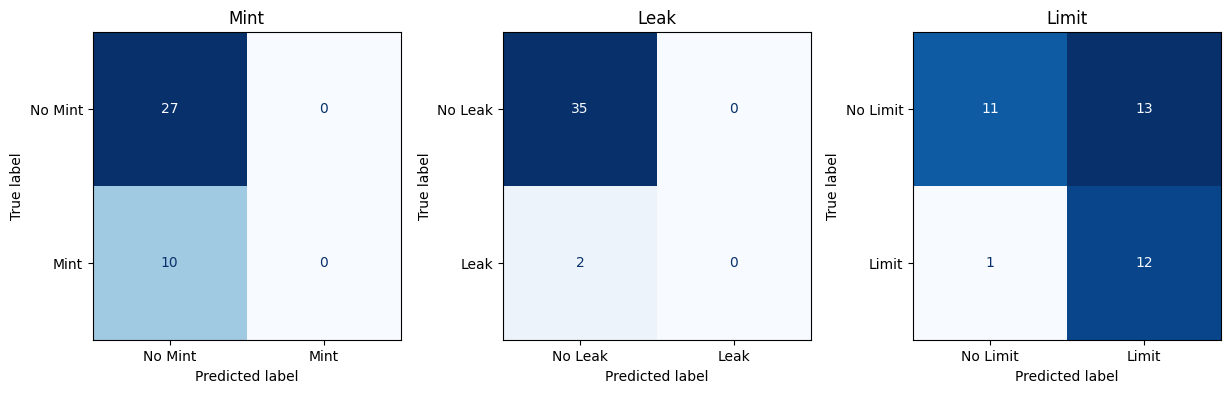

In [12]:
dataset = load_data(mode='txn')[0]
loader = DataLoader(dataset, batch_size=128, shuffle=True)
ground_df = pd.read_csv('groundtruth.csv', index_col=0)
label_cols = ground_df.columns.tolist()
y_true, y_pred, _ = val_model(model, loader)

plot_confusion_matrix(y_true, y_pred, label_cols)

              precision    recall  f1-score   support

        Mint       0.00      0.00      0.00        10
        Leak       0.00      0.00      0.00         2
       Limit       0.48      0.92      0.63        13

   micro avg       0.48      0.48      0.48        25
   macro avg       0.16      0.31      0.21        25
weighted avg       0.25      0.48      0.33        25
 samples avg       0.32      0.24      0.27        25



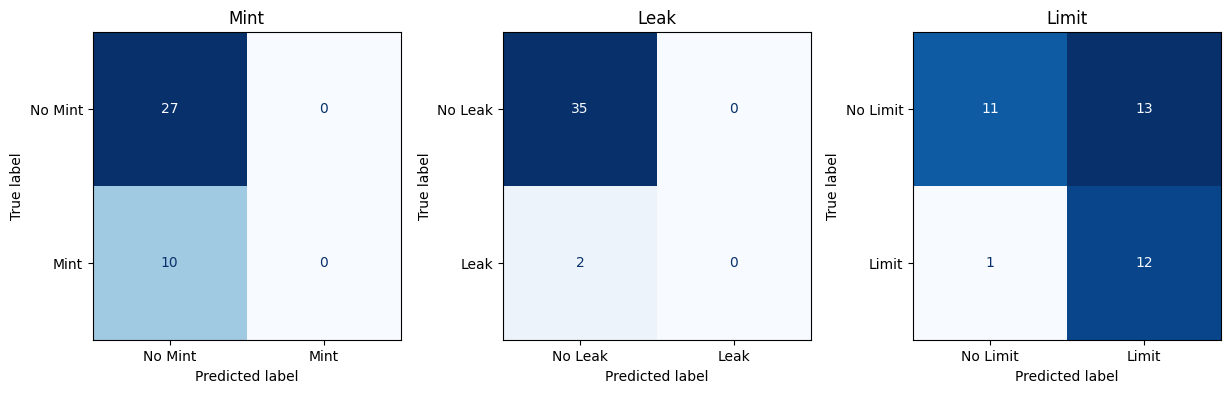

In [13]:
import torch
import json

# Load best parameters
with open("txn_best_params.json", "r") as f:
    best_params = json.load(f)

# Get input and output channels (assuming they are consistent with training)
dataset_info, in_channels, label_cols = load_data(mode='txn')
out_channels = len(label_cols)

# Initialize the model with the loaded parameters
loaded_model = GCN(in_channels=in_channels, hidden=best_params['hidden_dim'], out_channels=out_channels, dropout=best_params['dropout'])

# Load the state dictionary
loaded_model.load_state_dict(torch.load("txn_model.pth"))

thresholds = best_params['thresholds']
# Assuming 'loader' and 'thresholds' are already defined from previous cells
y_true, y_pred, _ = val_model(loaded_model, loader, thresholds)

plot_confusion_matrix(y_true, y_pred, label_cols)

## Control Flow

In [14]:
import torch
from torch_geometric.loader import DataLoader

model, thresholds = get_trained_gcn_model(mode='cfg', save_path='.')

[I 2025-08-01 02:50:40,185] A new study created in memory with name: no-name-95d35759-7263-4dfe-bd79-eee47e177cda


Epoch: 1/23, Loss: 19.1166
Epoch: 2/23, Loss: 25.2798
Epoch: 3/23, Loss: 7.7845
Epoch: 4/23, Loss: 5.1357
Epoch: 5/23, Loss: 11.3905
Epoch: 6/23, Loss: 5.6932
Epoch: 7/23, Loss: 7.7167
Epoch: 8/23, Loss: 4.0301
Epoch: 9/23, Loss: 8.2594
Epoch: 10/23, Loss: 6.0466
Epoch: 11/23, Loss: 1.5720
Epoch: 12/23, Loss: 2.0531
Epoch: 13/23, Loss: 1.9668
Epoch: 14/23, Loss: 3.1268
Epoch: 15/23, Loss: 1.8978
Epoch: 16/23, Loss: 0.4092
Epoch: 17/23, Loss: 1.2784
Epoch: 18/23, Loss: 0.8990
Epoch: 19/23, Loss: 1.8998
Epoch: 20/23, Loss: 1.2037
Epoch: 21/23, Loss: 1.3846
Epoch: 22/23, Loss: 2.5439
Epoch: 23/23, Loss: 1.5954
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:50:53,527] Trial 0 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 178, 'lr': 0.002748003847349465, 'dropout': 0.7819131396552971, 'batch_size': 28, 'epochs': 23}. Best is trial 0 with value: 0.08333333333333333.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/44, Loss: 15.2013
Epoch: 2/44, Loss: 15.2360
Epoch: 3/44, Loss: 14.8868
Epoch: 4/44, Loss: 14.5616
Epoch: 5/44, Loss: 14.2445
Epoch: 6/44, Loss: 13.6383
Epoch: 7/44, Loss: 13.2506
Epoch: 8/44, Loss: 13.0483
Epoch: 9/44, Loss: 12.7040
Epoch: 10/44, Loss: 13.0205
Epoch: 11/44, Loss: 11.9811
Epoch: 12/44, Loss: 11.9736
Epoch: 13/44, Loss: 11.7424
Epoch: 14/44, Loss: 11.6868
Epoch: 15/44, Loss: 11.0327
Epoch: 16/44, Loss: 10.9177
Epoch: 17/44, Loss: 10.7683
Epoch: 18/44, Loss: 10.6615
Epoch: 19/44, Loss: 9.7196
Epoch: 20/44, Loss: 9.7210
Epoch: 21/44, Loss: 9.5948
Epoch: 22/44, Loss: 9.4011
Epoch: 23/44, Loss: 8.6307
Epoch: 24/44, Loss: 8.7513
Epoch: 25/44, Loss: 8.9725
Epoch: 26/44, Loss: 7.7651
Epoch: 27/44, Loss: 7.7780
Epoch: 28/44, Loss: 7.3269
Epoch: 29/44, Loss: 7.5301
Epoch: 30/44, Loss: 6.9897
Epoch: 31/44, Loss: 7.1360
Epoch: 32/44, Loss: 6.8752
Epoch: 33/44, Loss: 6.4742
Epoch: 34/44, Loss: 6.4968
Epoch: 35/44, Loss: 6.3802


[I 2025-08-01 02:51:18,419] Trial 1 finished with value: 0.14184397163120568 and parameters: {'hidden_dim': 177, 'lr': 4.206476821739278e-05, 'dropout': 0.19200555044127593, 'batch_size': 173, 'epochs': 44}. Best is trial 1 with value: 0.14184397163120568.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/11, Loss: 3.7255
Epoch: 2/11, Loss: 3.3256
Epoch: 3/11, Loss: 3.2313
Epoch: 4/11, Loss: 3.1912
Epoch: 5/11, Loss: 2.5685
Epoch: 6/11, Loss: 2.4735
Epoch: 7/11, Loss: 2.1497
Epoch: 8/11, Loss: 2.6809
Epoch: 9/11, Loss: 2.2024
Epoch: 10/11, Loss: 2.1469
Epoch: 11/11, Loss: 1.9735
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:51:21,925] Trial 2 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 107, 'lr': 0.00032097632748441095, 'dropout': 0.502750897406583, 'batch_size': 181, 'epochs': 11}. Best is trial 2 with value: 0.17333333333333334.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/26, Loss: 5.9429
Epoch: 2/26, Loss: 5.2374
Epoch: 3/26, Loss: 5.7592
Epoch: 4/26, Loss: 4.2934
Epoch: 5/26, Loss: 2.0279
Epoch: 6/26, Loss: 3.3543
Epoch: 7/26, Loss: 1.8721
Epoch: 8/26, Loss: 2.9173
Epoch: 9/26, Loss: 1.6572
Epoch: 10/26, Loss: 2.7480
Epoch: 11/26, Loss: 2.3774
Epoch: 12/26, Loss: 2.9333
Epoch: 13/26, Loss: 2.6130
Epoch: 14/26, Loss: 2.0290
Epoch: 15/26, Loss: 1.7332
Epoch: 16/26, Loss: 1.9475
Epoch: 17/26, Loss: 2.6067
Epoch: 18/26, Loss: 1.2421
Epoch: 19/26, Loss: 1.0218
Epoch: 20/26, Loss: 2.1368
Epoch: 21/26, Loss: 1.0409
Epoch: 22/26, Loss: 1.8272
Epoch: 23/26, Loss: 1.0286
Epoch: 24/26, Loss: 1.6404
Epoch: 25/26, Loss: 1.0182
Epoch: 26/26, Loss: 1.1737
Label 0: Best threshold = 0.01, Best f1 = 0.46153846153846156
Label 1: Best threshold = 0.01, Best f1 = 0.125


[I 2025-08-01 02:51:27,585] Trial 3 finished with value: 0.3396569646569647 and parameters: {'hidden_dim': 96, 'lr': 0.0016112961008137427, 'dropout': 0.5044484776217909, 'batch_size': 68, 'epochs': 26}. Best is trial 3 with value: 0.3396569646569647.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/19, Loss: 11.5288
Epoch: 2/19, Loss: 8.2950
Epoch: 3/19, Loss: 7.4256
Epoch: 4/19, Loss: 7.3182
Epoch: 5/19, Loss: 10.9915
Epoch: 6/19, Loss: 10.6997
Epoch: 7/19, Loss: 4.8118
Epoch: 8/19, Loss: 5.4758
Epoch: 9/19, Loss: 3.4530
Epoch: 10/19, Loss: 6.7843
Epoch: 11/19, Loss: 3.3043
Epoch: 12/19, Loss: 3.0971
Epoch: 13/19, Loss: 2.4559
Epoch: 14/19, Loss: 2.6430
Epoch: 15/19, Loss: 2.1063
Epoch: 16/19, Loss: 1.3435
Epoch: 17/19, Loss: 1.4856
Epoch: 18/19, Loss: 1.8381
Epoch: 19/19, Loss: 1.2176
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:51:32,916] Trial 4 finished with value: 0.15365079365079365 and parameters: {'hidden_dim': 107, 'lr': 8.963342279299155e-05, 'dropout': 0.18961523702660338, 'batch_size': 22, 'epochs': 19}. Best is trial 3 with value: 0.3396569646569647.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/48, Loss: 6.3500
Epoch: 2/48, Loss: 6.0821
Epoch: 3/48, Loss: 6.7844
Epoch: 4/48, Loss: 2.0666
Epoch: 5/48, Loss: 4.0853
Epoch: 6/48, Loss: 7.0140
Epoch: 7/48, Loss: 5.6180
Epoch: 8/48, Loss: 3.7032
Epoch: 9/48, Loss: 5.3707
Epoch: 10/48, Loss: 1.7072
Epoch: 11/48, Loss: 4.0540
Epoch: 12/48, Loss: 3.3506
Epoch: 13/48, Loss: 9.0030
Epoch: 14/48, Loss: 5.0266
Epoch: 15/48, Loss: 3.9054
Epoch: 16/48, Loss: 2.5578
Epoch: 17/48, Loss: 7.1866
Epoch: 18/48, Loss: 2.7105
Epoch: 19/48, Loss: 2.5121
Epoch: 20/48, Loss: 4.6995
Epoch: 21/48, Loss: 6.1264
Epoch: 22/48, Loss: 6.1851
Epoch: 23/48, Loss: 3.7767
Epoch: 24/48, Loss: 6.1638
Epoch: 25/48, Loss: 6.4314
Epoch: 26/48, Loss: 2.3015
Epoch: 27/48, Loss: 6.6722
Epoch: 28/48, Loss: 5.5563
Epoch: 29/48, Loss: 4.8292
Epoch: 30/48, Loss: 6.4266
Epoch: 31/48, Loss: 1.8967
Epoch: 32/48, Loss: 6.2035
Epoch: 33/48, Loss: 1.0902
Epoch: 34/48, Loss: 4.1443
Epoch: 35/48, Loss: 4.8387
Epoch: 36/48, Loss

[I 2025-08-01 02:51:37,746] Trial 5 finished with value: 0.21882086167800452 and parameters: {'hidden_dim': 42, 'lr': 5.296176222293495e-06, 'dropout': 0.0270299992748666, 'batch_size': 31, 'epochs': 48}. Best is trial 3 with value: 0.3396569646569647.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/39, Loss: 5.5336
Epoch: 2/39, Loss: 27.8508
Epoch: 3/39, Loss: 15.6026
Epoch: 4/39, Loss: 12.7078
Epoch: 5/39, Loss: 9.8048
Epoch: 6/39, Loss: 4.2150
Epoch: 7/39, Loss: 2.0219
Epoch: 8/39, Loss: 3.1867
Epoch: 9/39, Loss: 3.4002
Epoch: 10/39, Loss: 2.8684
Epoch: 11/39, Loss: 2.4845
Epoch: 12/39, Loss: 1.7849
Epoch: 13/39, Loss: 0.9212
Epoch: 14/39, Loss: 0.6609
Epoch: 15/39, Loss: 0.7505
Epoch: 16/39, Loss: 0.8561
Epoch: 17/39, Loss: 0.8645
Epoch: 18/39, Loss: 0.7886
Epoch: 19/39, Loss: 0.7089
Epoch: 20/39, Loss: 0.7127
Epoch: 21/39, Loss: 0.6371
Epoch: 22/39, Loss: 0.7086
Epoch: 23/39, Loss: 0.6725
Epoch: 24/39, Loss: 0.5781
Epoch: 25/39, Loss: 0.5807
Epoch: 26/39, Loss: 0.6194
Epoch: 27/39, Loss: 0.5686
Epoch: 28/39, Loss: 0.5536
Epoch: 29/39, Loss: 0.5879
Epoch: 30/39, Loss: 0.5605
Epoch: 31/39, Loss: 0.6162
Epoch: 32/39, Loss: 0.6027
Epoch: 33/39, Loss: 0.5257
Epoch: 34/39, Loss: 0.5152
Epoch: 35/39, Loss: 0.4811
Epoch: 36/39, L

[I 2025-08-01 02:51:56,322] Trial 6 finished with value: 0.39351851851851855 and parameters: {'hidden_dim': 140, 'lr': 0.00877232547874641, 'dropout': 0.5688154626223679, 'batch_size': 82, 'epochs': 39}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.5555555555555556
Epoch: 1/6, Loss: 7.3659
Epoch: 2/6, Loss: 13.4979
Epoch: 3/6, Loss: 7.0239
Epoch: 4/6, Loss: 14.8888
Epoch: 5/6, Loss: 8.7520
Epoch: 6/6, Loss: 15.3162
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:51:58,036] Trial 7 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 81, 'lr': 1.7961582985910916e-05, 'dropout': 0.24369808808408858, 'batch_size': 24, 'epochs': 6}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/5, Loss: 1.2479
Epoch: 2/5, Loss: 0.2195
Epoch: 3/5, Loss: 0.0100
Epoch: 4/5, Loss: 1.1451
Epoch: 5/5, Loss: 6.5455
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:52:01,714] Trial 8 finished with value: 0.3263973888208894 and parameters: {'hidden_dim': 184, 'lr': 0.0008394512256284697, 'dropout': 0.528866447418653, 'batch_size': 18, 'epochs': 5}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.5581395348837209
Epoch: 1/7, Loss: 6.0062
Epoch: 2/7, Loss: 1.9634
Epoch: 3/7, Loss: 1.8280
Epoch: 4/7, Loss: 2.0314
Epoch: 5/7, Loss: 1.3022
Epoch: 6/7, Loss: 1.6784
Epoch: 7/7, Loss: 1.8825
Label 0: Best threshold = 0.01, Best f1 = 0.5333333333333333
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:52:10,363] Trial 9 finished with value: 0.17777777777777778 and parameters: {'hidden_dim': 242, 'lr': 0.0008856117592171206, 'dropout': 0.004411512742399548, 'batch_size': 43, 'epochs': 7}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 5.6635
Epoch: 2/37, Loss: 49.2556
Epoch: 3/37, Loss: 27.0028
Epoch: 4/37, Loss: 28.2923
Epoch: 5/37, Loss: 18.5164
Epoch: 6/37, Loss: 17.6669
Epoch: 7/37, Loss: 12.7290
Epoch: 8/37, Loss: 6.8555
Epoch: 9/37, Loss: 3.8497
Epoch: 10/37, Loss: 3.3674
Epoch: 11/37, Loss: 2.4973
Epoch: 12/37, Loss: 2.4452
Epoch: 13/37, Loss: 2.6457
Epoch: 14/37, Loss: 2.3623
Epoch: 15/37, Loss: 1.6959
Epoch: 16/37, Loss: 1.6847
Epoch: 17/37, Loss: 1.1958
Epoch: 18/37, Loss: 0.9607
Epoch: 19/37, Loss: 0.7781
Epoch: 20/37, Loss: 0.6732
Epoch: 21/37, Loss: 0.6710
Epoch: 22/37, Loss: 0.7150
Epoch: 23/37, Loss: 0.6006
Epoch: 24/37, Loss: 0.6277
Epoch: 25/37, Loss: 0.5789
Epoch: 26/37, Loss: 0.5877
Epoch: 27/37, Loss: 0.5817
Epoch: 28/37, Loss: 0.5429
Epoch: 29/37, Loss: 0.6118
Epoch: 30/37, Loss: 0.6021
Epoch: 31/37, Loss: 0.5353
Epoch: 32/37, Loss: 0.5696
Epoch: 33/37, Loss: 0.5357
Epoch: 34/37, Loss: 0.5363
Epoch: 35/37, Loss: 0.5244
Epoch: 36/37

[I 2025-08-01 02:52:51,151] Trial 10 finished with value: 0.35584415584415585 and parameters: {'hidden_dim': 239, 'lr': 0.008684790572375251, 'dropout': 0.7755135805227944, 'batch_size': 89, 'epochs': 37}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/38, Loss: 5.7031
Epoch: 2/38, Loss: 83.7793
Epoch: 3/38, Loss: 26.5217
Epoch: 4/38, Loss: 10.3623
Epoch: 5/38, Loss: 5.2447
Epoch: 6/38, Loss: 7.9124
Epoch: 7/38, Loss: 6.3920
Epoch: 8/38, Loss: 4.9234
Epoch: 9/38, Loss: 3.2227
Epoch: 10/38, Loss: 2.4623
Epoch: 11/38, Loss: 1.7507
Epoch: 12/38, Loss: 1.0736
Epoch: 13/38, Loss: 0.8913
Epoch: 14/38, Loss: 0.6175
Epoch: 15/38, Loss: 0.6346
Epoch: 16/38, Loss: 0.5574
Epoch: 17/38, Loss: 0.5708
Epoch: 18/38, Loss: 0.6053
Epoch: 19/38, Loss: 0.6783
Epoch: 20/38, Loss: 0.7603
Epoch: 21/38, Loss: 0.5399
Epoch: 22/38, Loss: 0.7859
Epoch: 23/38, Loss: 0.5614
Epoch: 24/38, Loss: 0.5027
Epoch: 25/38, Loss: 0.5210
Epoch: 26/38, Loss: 0.5399
Epoch: 27/38, Loss: 0.5210
Epoch: 28/38, Loss: 0.4678
Epoch: 29/38, Loss: 0.6714
Epoch: 30/38, Loss: 0.4962
Epoch: 31/38, Loss: 0.4977
Epoch: 32/38, Loss: 0.5445
Epoch: 33/38, Loss: 0.6082
Epoch: 34/38, Loss: 0.5024
Epoch: 35/38, Loss: 0.5485
Epoch: 36/38, L

[I 2025-08-01 02:53:37,707] Trial 11 finished with value: 0.24242424242424243 and parameters: {'hidden_dim': 255, 'lr': 0.009544497797598863, 'dropout': 0.7603084584139193, 'batch_size': 85, 'epochs': 38}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.5454545454545454
Epoch: 1/35, Loss: 7.4282
Epoch: 2/35, Loss: 37.6836
Epoch: 3/35, Loss: 18.8494
Epoch: 4/35, Loss: 18.2311
Epoch: 5/35, Loss: 13.9991
Epoch: 6/35, Loss: 9.1290
Epoch: 7/35, Loss: 4.3528
Epoch: 8/35, Loss: 3.9630
Epoch: 9/35, Loss: 4.6718
Epoch: 10/35, Loss: 3.7869
Epoch: 11/35, Loss: 3.6707
Epoch: 12/35, Loss: 2.1858
Epoch: 13/35, Loss: 1.3587
Epoch: 14/35, Loss: 1.0120
Epoch: 15/35, Loss: 0.8268
Epoch: 16/35, Loss: 0.7577
Epoch: 17/35, Loss: 0.7902
Epoch: 18/35, Loss: 0.7410
Epoch: 19/35, Loss: 0.7050
Epoch: 20/35, Loss: 0.7916
Epoch: 21/35, Loss: 0.6523
Epoch: 22/35, Loss: 0.6320
Epoch: 23/35, Loss: 0.6446
Epoch: 24/35, Loss: 0.5463
Epoch: 25/35, Loss: 0.5711
Epoch: 26/35, Loss: 0.5697
Epoch: 27/35, Loss: 0.5236
Epoch: 28/35, Loss: 0.5408
Epoch: 29/35, Loss: 0.5673
Epoch: 30/35, Loss: 0.6536
Epoch: 31/35, Loss: 0.5320
Epoch: 32/35, Loss: 0.5471
Epoch: 33/35, Loss: 0.5429
Epoch: 34/35, Loss: 0.5297
Epoch: 35/35, Loss: 0.6601

[I 2025-08-01 02:53:55,256] Trial 12 finished with value: 0.0 and parameters: {'hidden_dim': 142, 'lr': 0.008801753868716431, 'dropout': 0.6672344183255354, 'batch_size': 106, 'epochs': 35}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 4.3904
Epoch: 2/37, Loss: 5.6445
Epoch: 3/37, Loss: 5.8912
Epoch: 4/37, Loss: 4.5153
Epoch: 5/37, Loss: 5.7400
Epoch: 6/37, Loss: 5.8365
Epoch: 7/37, Loss: 4.3287
Epoch: 8/37, Loss: 4.5795
Epoch: 9/37, Loss: 5.1015
Epoch: 10/37, Loss: 4.6284
Epoch: 11/37, Loss: 5.3533
Epoch: 12/37, Loss: 4.5878
Epoch: 13/37, Loss: 4.9410
Epoch: 14/37, Loss: 5.2543
Epoch: 15/37, Loss: 4.6205
Epoch: 16/37, Loss: 5.4712
Epoch: 17/37, Loss: 5.4007
Epoch: 18/37, Loss: 5.0955
Epoch: 19/37, Loss: 5.8449
Epoch: 20/37, Loss: 5.2581
Epoch: 21/37, Loss: 4.7453
Epoch: 22/37, Loss: 4.8736
Epoch: 23/37, Loss: 5.0144
Epoch: 24/37, Loss: 4.2535
Epoch: 25/37, Loss: 4.3878
Epoch: 26/37, Loss: 4.1708
Epoch: 27/37, Loss: 4.2917
Epoch: 28/37, Loss: 4.2076
Epoch: 29/37, Loss: 5.0452
Epoch: 30/37, Loss: 4.6897
Epoch: 31/37, Loss: 4.1937
Epoch: 32/37, Loss: 4.9696
Epoch: 33/37, Loss: 4.2085
Epoch: 34/37, Loss: 5.5956
Epoch: 35/37, Loss: 4.3708
Epoch: 36/37, Loss

[I 2025-08-01 02:54:31,173] Trial 13 finished with value: 0.17333333333333334 and parameters: {'hidden_dim': 221, 'lr': 1.6484066599586438e-06, 'dropout': 0.6335251145456176, 'batch_size': 116, 'epochs': 37}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/32, Loss: 2.4786
Epoch: 2/32, Loss: 2.7479
Epoch: 3/32, Loss: 1.0255
Epoch: 4/32, Loss: 2.0331
Epoch: 5/32, Loss: 2.0447
Epoch: 6/32, Loss: 2.1963
Epoch: 7/32, Loss: 1.6735
Epoch: 8/32, Loss: 1.0277
Epoch: 9/32, Loss: 1.6833
Epoch: 10/32, Loss: 1.7477
Epoch: 11/32, Loss: 1.3270
Epoch: 12/32, Loss: 1.9412
Epoch: 13/32, Loss: 1.8495
Epoch: 14/32, Loss: 0.9635
Epoch: 15/32, Loss: 1.6649
Epoch: 16/32, Loss: 1.3616
Epoch: 17/32, Loss: 1.3728
Epoch: 18/32, Loss: 0.8351
Epoch: 19/32, Loss: 1.7152
Epoch: 20/32, Loss: 1.1106
Epoch: 21/32, Loss: 1.6125
Epoch: 22/32, Loss: 0.9515
Epoch: 23/32, Loss: 1.6440
Epoch: 24/32, Loss: 1.9197
Epoch: 25/32, Loss: 1.0754
Epoch: 26/32, Loss: 1.3546
Epoch: 27/32, Loss: 1.4548
Epoch: 28/32, Loss: 1.6644
Epoch: 29/32, Loss: 2.0356
Epoch: 30/32, Loss: 1.1661
Epoch: 31/32, Loss: 1.6084
Epoch: 32/32, Loss: 1.0128
Label 0: Best threshold = 0.01, Best f1 = 0.5128205128205128
Label 1: Best threshold = 0.0, Best f1

[I 2025-08-01 02:54:46,218] Trial 14 finished with value: 0.30427350427350425 and parameters: {'hidden_dim': 146, 'lr': 0.0002794628867925484, 'dropout': 0.3591038218543095, 'batch_size': 52, 'epochs': 32}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 15.4097
Epoch: 2/43, Loss: 6.5895
Epoch: 3/43, Loss: 9.4754
Epoch: 4/43, Loss: 7.9427
Epoch: 5/43, Loss: 3.3431
Epoch: 6/43, Loss: 3.5224
Epoch: 7/43, Loss: 5.5802
Epoch: 8/43, Loss: 3.3411
Epoch: 9/43, Loss: 3.0038
Epoch: 10/43, Loss: 2.5943
Epoch: 11/43, Loss: 2.8976
Epoch: 12/43, Loss: 2.6850
Epoch: 13/43, Loss: 2.9986
Epoch: 14/43, Loss: 2.0386
Epoch: 15/43, Loss: 1.8588
Epoch: 16/43, Loss: 1.8101
Epoch: 17/43, Loss: 1.6212
Epoch: 18/43, Loss: 1.8638
Epoch: 19/43, Loss: 1.4044
Epoch: 20/43, Loss: 1.5952
Epoch: 21/43, Loss: 1.2606
Epoch: 22/43, Loss: 1.1742
Epoch: 23/43, Loss: 0.8019
Epoch: 24/43, Loss: 1.2476
Epoch: 25/43, Loss: 0.9528
Epoch: 26/43, Loss: 1.0231
Epoch: 27/43, Loss: 0.8068
Epoch: 28/43, Loss: 1.0264
Epoch: 29/43, Loss: 0.9441
Epoch: 30/43, Loss: 0.7242
Epoch: 31/43, Loss: 0.8483
Epoch: 32/43, Loss: 0.8180
Epoch: 33/43, Loss: 0.6709
Epoch: 34/43, Loss: 0.9956
Epoch: 35/43, Loss: 0.7152
Epoch: 36/43, Los

[I 2025-08-01 02:55:28,203] Trial 15 finished with value: 0.03508771929824561 and parameters: {'hidden_dim': 209, 'lr': 0.0037681248518226904, 'dropout': 0.6615710727364413, 'batch_size': 128, 'epochs': 43}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/29, Loss: 4.3854
Epoch: 2/29, Loss: 3.3532
Epoch: 3/29, Loss: 2.3411
Epoch: 4/29, Loss: 2.3775
Epoch: 5/29, Loss: 1.8887
Epoch: 6/29, Loss: 2.0572
Epoch: 7/29, Loss: 3.0838
Epoch: 8/29, Loss: 1.9235
Epoch: 9/29, Loss: 1.4164
Epoch: 10/29, Loss: 1.6480
Epoch: 11/29, Loss: 1.3754
Epoch: 12/29, Loss: 2.1693
Epoch: 13/29, Loss: 1.9596
Epoch: 14/29, Loss: 2.1603
Epoch: 15/29, Loss: 2.3917
Epoch: 16/29, Loss: 1.7138
Epoch: 17/29, Loss: 1.6238
Epoch: 18/29, Loss: 1.2737
Epoch: 19/29, Loss: 1.4388
Epoch: 20/29, Loss: 1.2860
Epoch: 21/29, Loss: 1.3753
Epoch: 22/29, Loss: 1.3362
Epoch: 23/29, Loss: 1.6115
Epoch: 24/29, Loss: 1.0621
Epoch: 25/29, Loss: 1.3877
Epoch: 26/29, Loss: 0.8540
Epoch: 27/29, Loss: 1.7054
Epoch: 28/29, Loss: 1.0661
Epoch: 29/29, Loss: 1.4418
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:55:42,990] Trial 16 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 142, 'lr': 0.0003475496938497854, 'dropout': 0.40611482190371123, 'batch_size': 72, 'epochs': 29}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/50, Loss: 14.0813
Epoch: 2/50, Loss: 4.7128
Epoch: 3/50, Loss: 7.9646
Epoch: 4/50, Loss: 7.8651
Epoch: 5/50, Loss: 3.9887
Epoch: 6/50, Loss: 6.1954
Epoch: 7/50, Loss: 5.7598
Epoch: 8/50, Loss: 5.6561
Epoch: 9/50, Loss: 4.7174
Epoch: 10/50, Loss: 3.7044
Epoch: 11/50, Loss: 2.8614
Epoch: 12/50, Loss: 3.8912
Epoch: 13/50, Loss: 2.4314
Epoch: 14/50, Loss: 2.5970
Epoch: 15/50, Loss: 2.2224
Epoch: 16/50, Loss: 1.3328
Epoch: 17/50, Loss: 1.1288
Epoch: 18/50, Loss: 1.1267
Epoch: 19/50, Loss: 1.2312
Epoch: 20/50, Loss: 1.6736
Epoch: 21/50, Loss: 1.6532
Epoch: 22/50, Loss: 1.5743
Epoch: 23/50, Loss: 1.1452
Epoch: 24/50, Loss: 0.8715
Epoch: 25/50, Loss: 0.8502
Epoch: 26/50, Loss: 0.9465
Epoch: 27/50, Loss: 0.8719
Epoch: 28/50, Loss: 1.0048
Epoch: 29/50, Loss: 1.0102
Epoch: 30/50, Loss: 0.7045
Epoch: 31/50, Loss: 0.9365
Epoch: 32/50, Loss: 0.9568
Epoch: 33/50, Loss: 1.0107
Epoch: 34/50, Loss: 0.8317
Epoch: 35/50, Loss: 0.6822
Epoch: 36/50, Los

[I 2025-08-01 02:56:19,066] Trial 17 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 207, 'lr': 0.0030927701674247163, 'dropout': 0.5814636872840399, 'batch_size': 50, 'epochs': 50}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 11.9930
Epoch: 2/40, Loss: 17.7849
Epoch: 3/40, Loss: 10.4263
Epoch: 4/40, Loss: 10.7526
Epoch: 5/40, Loss: 10.1689
Epoch: 6/40, Loss: 10.6277
Epoch: 7/40, Loss: 6.7373
Epoch: 8/40, Loss: 5.3933
Epoch: 9/40, Loss: 6.4400
Epoch: 10/40, Loss: 4.6173
Epoch: 11/40, Loss: 4.1082
Epoch: 12/40, Loss: 4.0093
Epoch: 13/40, Loss: 2.8651
Epoch: 14/40, Loss: 1.5590
Epoch: 15/40, Loss: 1.5249
Epoch: 16/40, Loss: 1.1834
Epoch: 17/40, Loss: 1.3154
Epoch: 18/40, Loss: 1.3224
Epoch: 19/40, Loss: 0.9972
Epoch: 20/40, Loss: 1.0903
Epoch: 21/40, Loss: 0.9988
Epoch: 22/40, Loss: 0.7989
Epoch: 23/40, Loss: 0.6116
Epoch: 24/40, Loss: 0.6248
Epoch: 25/40, Loss: 0.6157
Epoch: 26/40, Loss: 0.6388
Epoch: 27/40, Loss: 0.6487
Epoch: 28/40, Loss: 0.7150
Epoch: 29/40, Loss: 0.7068
Epoch: 30/40, Loss: 0.6003
Epoch: 31/40, Loss: 0.5666
Epoch: 32/40, Loss: 0.6017
Epoch: 33/40, Loss: 0.5201
Epoch: 34/40, Loss: 0.5453
Epoch: 35/40, Loss: 0.4787
Epoch: 36/40

[I 2025-08-01 02:56:38,414] Trial 18 finished with value: 0.34393939393939393 and parameters: {'hidden_dim': 154, 'lr': 0.007502999234488732, 'dropout': 0.7408984218563006, 'batch_size': 249, 'epochs': 40}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/32, Loss: 10.3923
Epoch: 2/32, Loss: 8.8547
Epoch: 3/32, Loss: 6.8868
Epoch: 4/32, Loss: 5.5653
Epoch: 5/32, Loss: 3.8596
Epoch: 6/32, Loss: 2.8155
Epoch: 7/32, Loss: 2.6658
Epoch: 8/32, Loss: 3.0880
Epoch: 9/32, Loss: 2.3334
Epoch: 10/32, Loss: 3.0868
Epoch: 11/32, Loss: 3.7113
Epoch: 12/32, Loss: 3.1613
Epoch: 13/32, Loss: 2.9012
Epoch: 14/32, Loss: 3.1933
Epoch: 15/32, Loss: 3.4295
Epoch: 16/32, Loss: 2.6359
Epoch: 17/32, Loss: 3.3710
Epoch: 18/32, Loss: 2.2583
Epoch: 19/32, Loss: 2.2276
Epoch: 20/32, Loss: 2.1355
Epoch: 21/32, Loss: 2.1967
Epoch: 22/32, Loss: 1.9336
Epoch: 23/32, Loss: 2.2203
Epoch: 24/32, Loss: 1.1964
Epoch: 25/32, Loss: 2.2861
Epoch: 26/32, Loss: 1.9090
Epoch: 27/32, Loss: 2.0454
Epoch: 28/32, Loss: 1.5378
Epoch: 29/32, Loss: 1.4277
Epoch: 30/32, Loss: 1.9532
Epoch: 31/32, Loss: 1.2364
Epoch: 32/32, Loss: 1.1463
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f

[I 2025-08-01 02:56:43,972] Trial 19 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 68, 'lr': 0.0008721223851209341, 'dropout': 0.4186369286153602, 'batch_size': 88, 'epochs': 32}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/44, Loss: 12.1962
Epoch: 2/44, Loss: 11.2403
Epoch: 3/44, Loss: 10.3558
Epoch: 4/44, Loss: 9.3208
Epoch: 5/44, Loss: 10.1093
Epoch: 6/44, Loss: 9.5773
Epoch: 7/44, Loss: 8.9580
Epoch: 8/44, Loss: 9.7926
Epoch: 9/44, Loss: 7.3986
Epoch: 10/44, Loss: 9.3803
Epoch: 11/44, Loss: 12.1760
Epoch: 12/44, Loss: 9.2055
Epoch: 13/44, Loss: 7.9290
Epoch: 14/44, Loss: 9.3724
Epoch: 15/44, Loss: 10.1696
Epoch: 16/44, Loss: 9.5764
Epoch: 17/44, Loss: 10.3197
Epoch: 18/44, Loss: 9.0708
Epoch: 19/44, Loss: 8.8670
Epoch: 20/44, Loss: 10.2075
Epoch: 21/44, Loss: 9.9551
Epoch: 22/44, Loss: 10.1008
Epoch: 23/44, Loss: 9.5199
Epoch: 24/44, Loss: 9.2621
Epoch: 25/44, Loss: 8.9842
Epoch: 26/44, Loss: 9.1942
Epoch: 27/44, Loss: 6.8778
Epoch: 28/44, Loss: 9.4966
Epoch: 29/44, Loss: 9.0476
Epoch: 30/44, Loss: 8.5495
Epoch: 31/44, Loss: 9.2471
Epoch: 32/44, Loss: 7.9715
Epoch: 33/44, Loss: 8.5883
Epoch: 34/44, Loss: 10.3182
Epoch: 35/44, Loss: 8.4048
Epoch: 3

[I 2025-08-01 02:57:02,364] Trial 20 finished with value: 0.30851063829787234 and parameters: {'hidden_dim': 123, 'lr': 1.4985411276833292e-05, 'dropout': 0.7074895924584946, 'batch_size': 152, 'epochs': 44}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/41, Loss: 9.4673
Epoch: 2/41, Loss: 26.6815
Epoch: 3/41, Loss: 13.5107
Epoch: 4/41, Loss: 6.2164
Epoch: 5/41, Loss: 8.9842
Epoch: 6/41, Loss: 11.3350
Epoch: 7/41, Loss: 10.4255
Epoch: 8/41, Loss: 9.0661
Epoch: 9/41, Loss: 6.8901
Epoch: 10/41, Loss: 5.4429
Epoch: 11/41, Loss: 3.8998
Epoch: 12/41, Loss: 2.9146
Epoch: 13/41, Loss: 1.7101
Epoch: 14/41, Loss: 1.4984
Epoch: 15/41, Loss: 1.8918
Epoch: 16/41, Loss: 1.5923
Epoch: 17/41, Loss: 2.1057
Epoch: 18/41, Loss: 1.9661
Epoch: 19/41, Loss: 1.5691
Epoch: 20/41, Loss: 1.0476
Epoch: 21/41, Loss: 0.9943
Epoch: 22/41, Loss: 0.6914
Epoch: 23/41, Loss: 0.7297
Epoch: 24/41, Loss: 0.6611
Epoch: 25/41, Loss: 0.6653
Epoch: 26/41, Loss: 0.7216
Epoch: 27/41, Loss: 0.7587
Epoch: 28/41, Loss: 0.7857
Epoch: 29/41, Loss: 0.7695
Epoch: 30/41, Loss: 0.7334
Epoch: 31/41, Loss: 0.6297
Epoch: 32/41, Loss: 0.7781
Epoch: 33/41, Loss: 0.6868
Epoch: 34/41, Loss: 0.6212
Epoch: 35/41, Loss: 0.6272
Epoch: 36/41, 

[I 2025-08-01 02:57:25,319] Trial 21 finished with value: 0.041666666666666664 and parameters: {'hidden_dim': 156, 'lr': 0.006370190814223751, 'dropout': 0.7914582881903316, 'batch_size': 247, 'epochs': 41}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/38, Loss: 10.0405
Epoch: 2/38, Loss: 11.2614
Epoch: 3/38, Loss: 9.4886
Epoch: 4/38, Loss: 10.0552
Epoch: 5/38, Loss: 7.4228
Epoch: 6/38, Loss: 4.0485
Epoch: 7/38, Loss: 6.4339
Epoch: 8/38, Loss: 7.1259
Epoch: 9/38, Loss: 6.1854
Epoch: 10/38, Loss: 4.6665
Epoch: 11/38, Loss: 2.2613
Epoch: 12/38, Loss: 2.5255
Epoch: 13/38, Loss: 2.9409
Epoch: 14/38, Loss: 3.0541
Epoch: 15/38, Loss: 2.8439
Epoch: 16/38, Loss: 1.9433
Epoch: 17/38, Loss: 1.3658
Epoch: 18/38, Loss: 0.8121
Epoch: 19/38, Loss: 1.2225
Epoch: 20/38, Loss: 1.2749
Epoch: 21/38, Loss: 1.6349
Epoch: 22/38, Loss: 1.8170
Epoch: 23/38, Loss: 1.1736
Epoch: 24/38, Loss: 0.9540
Epoch: 25/38, Loss: 1.1011
Epoch: 26/38, Loss: 0.6985
Epoch: 27/38, Loss: 1.0619
Epoch: 28/38, Loss: 0.8796
Epoch: 29/38, Loss: 0.7803
Epoch: 30/38, Loss: 0.7683
Epoch: 31/38, Loss: 1.1659
Epoch: 32/38, Loss: 0.6391
Epoch: 33/38, Loss: 0.8735
Epoch: 34/38, Loss: 0.6825
Epoch: 35/38, Loss: 0.7391
Epoch: 36/38, L

[I 2025-08-01 02:57:48,483] Trial 22 finished with value: 0.28034188034188035 and parameters: {'hidden_dim': 166, 'lr': 0.004617199226903269, 'dropout': 0.727793348802455, 'batch_size': 209, 'epochs': 38}. Best is trial 6 with value: 0.39351851851851855.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/33, Loss: 8.7813
Epoch: 2/33, Loss: 2.8917
Epoch: 3/33, Loss: 2.7655
Epoch: 4/33, Loss: 4.0891
Epoch: 5/33, Loss: 5.2643
Epoch: 6/33, Loss: 4.7181
Epoch: 7/33, Loss: 4.1479
Epoch: 8/33, Loss: 3.2018
Epoch: 9/33, Loss: 2.3946
Epoch: 10/33, Loss: 1.8619
Epoch: 11/33, Loss: 3.9174
Epoch: 12/33, Loss: 2.5456
Epoch: 13/33, Loss: 3.0735
Epoch: 14/33, Loss: 1.4505
Epoch: 15/33, Loss: 1.6389
Epoch: 16/33, Loss: 1.9800
Epoch: 17/33, Loss: 2.4944
Epoch: 18/33, Loss: 1.9805
Epoch: 19/33, Loss: 2.3279
Epoch: 20/33, Loss: 1.9405
Epoch: 21/33, Loss: 1.4754
Epoch: 22/33, Loss: 1.4184
Epoch: 23/33, Loss: 2.0611
Epoch: 24/33, Loss: 1.6322
Epoch: 25/33, Loss: 1.3033
Epoch: 26/33, Loss: 1.4353
Epoch: 27/33, Loss: 1.1141
Epoch: 28/33, Loss: 1.1531
Epoch: 29/33, Loss: 1.3562
Epoch: 30/33, Loss: 1.0534
Epoch: 31/33, Loss: 1.3342
Epoch: 32/33, Loss: 1.5493
Epoch: 33/33, Loss: 0.9744
Label 0: Be

[I 2025-08-01 02:58:11,275] Trial 23 finished with value: 0.04597701149425287 and parameters: {'hidden_dim': 198, 'lr': 0.001159192769493484, 'dropout': 0.596337881871744, 'batch_size': 93, 'epochs': 33}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/47, Loss: 21.1544
Epoch: 2/47, Loss: 1.8735
Epoch: 3/47, Loss: 2.3666
Epoch: 4/47, Loss: 0.0000
Epoch: 5/47, Loss: 1.7678
Epoch: 6/47, Loss: 0.0558
Epoch: 7/47, Loss: 0.0000
Epoch: 8/47, Loss: 0.0107
Epoch: 9/47, Loss: 0.3422
Epoch: 10/47, Loss: 3.0058
Epoch: 11/47, Loss: 1.9322
Epoch: 12/47, Loss: 2.2284
Epoch: 13/47, Loss: 6.8941
Epoch: 14/47, Loss: 0.2625
Epoch: 15/47, Loss: 32.3797
Epoch: 16/47, Loss: 0.5516
Epoch: 17/47, Loss: 0.2897
Epoch: 18/47, Loss: 2.6620
Epoch: 19/47, Loss: 0.1753
Epoch: 20/47, Loss: 31.2394
Epoch: 21/47, Loss: 0.6998
Epoch: 22/47, Loss: 3.0167
Epoch: 23/47, Loss: 0.7839
Epoch: 24/47, Loss: 5.1994
Epoch: 25/47, Loss: 0.7831
Epoch: 26/47, Loss: 1.6292
Epoch: 27/47, Loss: 0.0005
Epoch: 28/47, Loss: 1.6467
Epoch: 29/47, Loss: 0.6296
Epoch: 30/47, Loss: 33.0129
Epoch: 31/47, Loss: 0.0148
Epoch: 32/47, Loss: 0.0032
Epoch: 33/47, Loss: 11.6845
Epoch: 34/47, Loss: 0.2701
Epoch: 35/47, Loss: 0.6943
Epoch: 36/47,

[I 2025-08-01 02:58:56,865] Trial 24 finished with value: 0.12698412698412698 and parameters: {'hidden_dim': 228, 'lr': 0.0020922428005520004, 'dropout': 0.690992422185868, 'batch_size': 36, 'epochs': 47}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 10.6344
Epoch: 2/40, Loss: 12.6727
Epoch: 3/40, Loss: 8.4407
Epoch: 4/40, Loss: 7.6558
Epoch: 5/40, Loss: 8.2804
Epoch: 6/40, Loss: 7.5602
Epoch: 7/40, Loss: 5.5739
Epoch: 8/40, Loss: 4.6055
Epoch: 9/40, Loss: 5.4808
Epoch: 10/40, Loss: 6.2821
Epoch: 11/40, Loss: 4.3912
Epoch: 12/40, Loss: 3.0652
Epoch: 13/40, Loss: 3.3775
Epoch: 14/40, Loss: 3.1012
Epoch: 15/40, Loss: 2.6149
Epoch: 16/40, Loss: 2.7104
Epoch: 17/40, Loss: 1.2595
Epoch: 18/40, Loss: 1.8262
Epoch: 19/40, Loss: 1.2870
Epoch: 20/40, Loss: 1.3614
Epoch: 21/40, Loss: 1.3633
Epoch: 22/40, Loss: 1.4789
Epoch: 23/40, Loss: 1.3793
Epoch: 24/40, Loss: 1.4974
Epoch: 25/40, Loss: 0.8584
Epoch: 26/40, Loss: 1.0466
Epoch: 27/40, Loss: 0.7298
Epoch: 28/40, Loss: 0.7137
Epoch: 29/40, Loss: 0.6138
Epoch: 30/40, Loss: 0.8127
Epoch: 31/40, Loss: 1.0896
Epoch: 32/40, Loss: 0.6656
Epoch: 33/40, Loss: 0.7510
Epoch: 34/40, Loss: 0.6820
Epoch: 35/40, Loss: 0.7622
Epoch: 36/40, Lo

[I 2025-08-01 02:59:09,865] Trial 25 finished with value: 0.0 and parameters: {'hidden_dim': 125, 'lr': 0.005239399795588154, 'dropout': 0.5879939949922035, 'batch_size': 60, 'epochs': 40}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/26, Loss: 29.7184
Epoch: 2/26, Loss: 13.0360
Epoch: 3/26, Loss: 9.4416
Epoch: 4/26, Loss: 12.9796
Epoch: 5/26, Loss: 11.2688
Epoch: 6/26, Loss: 10.0673
Epoch: 7/26, Loss: 8.7283
Epoch: 8/26, Loss: 7.5062
Epoch: 9/26, Loss: 6.0880
Epoch: 10/26, Loss: 4.7472
Epoch: 11/26, Loss: 5.2737
Epoch: 12/26, Loss: 4.2777
Epoch: 13/26, Loss: 5.1128
Epoch: 14/26, Loss: 7.0881
Epoch: 15/26, Loss: 4.4171
Epoch: 16/26, Loss: 3.8483
Epoch: 17/26, Loss: 3.1604
Epoch: 18/26, Loss: 1.7567
Epoch: 19/26, Loss: 1.9168
Epoch: 20/26, Loss: 2.9917
Epoch: 21/26, Loss: 4.3963
Epoch: 22/26, Loss: 2.8698
Epoch: 23/26, Loss: 1.5658
Epoch: 24/26, Loss: 2.0862
Epoch: 25/26, Loss: 2.2047
Epoch: 26/26, Loss: 1.6254
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.01, Best f1 = 0.10526315789473684


[I 2025-08-01 02:59:13,333] Trial 26 finished with value: 0.08270676691729323 and parameters: {'hidden_dim': 37, 'lr': 0.008590793643195383, 'dropout': 0.7379496566958266, 'batch_size': 127, 'epochs': 26}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/35, Loss: 3.4280
Epoch: 2/35, Loss: 2.6977
Epoch: 3/35, Loss: 2.8174
Epoch: 4/35, Loss: 2.1911
Epoch: 5/35, Loss: 2.8629
Epoch: 6/35, Loss: 2.0770
Epoch: 7/35, Loss: 1.7174
Epoch: 8/35, Loss: 1.7108
Epoch: 9/35, Loss: 1.4109
Epoch: 10/35, Loss: 1.7036
Epoch: 11/35, Loss: 2.0579
Epoch: 12/35, Loss: 1.4004
Epoch: 13/35, Loss: 1.4151
Epoch: 14/35, Loss: 1.6255
Epoch: 15/35, Loss: 1.5689
Epoch: 16/35, Loss: 2.2503
Epoch: 17/35, Loss: 1.7914
Epoch: 18/35, Loss: 0.9904
Epoch: 19/35, Loss: 1.9402
Epoch: 20/35, Loss: 1.5924
Epoch: 21/35, Loss: 1.3471
Epoch: 22/35, Loss: 1.0055
Epoch: 23/35, Loss: 1.2906
Epoch: 24/35, Loss: 1.5041
Epoch: 25/35, Loss: 1.3080
Epoch: 26/35, Loss: 1.6820
Epoch: 27/35, Loss: 1.3900
Epoch: 28/35, Loss: 0.9755
Epoch: 29/35, Loss: 1.0642
Epoch: 30/35, Loss: 1.0790
Epoch: 31/35, Loss: 1.1594
Epoch: 32/35, Loss: 1.9308
Epoch: 33/35, Loss: 1.2291
Epoch: 34/35, Loss: 1.0889
Epoch: 35/35, Loss: 1.1017
Label 0: Best thre

[I 2025-08-01 02:59:23,983] Trial 27 finished with value: 0.18148148148148147 and parameters: {'hidden_dim': 130, 'lr': 0.0004948206874231107, 'dropout': 0.4694786966781772, 'batch_size': 245, 'epochs': 35}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/18, Loss: 10.5455
Epoch: 2/18, Loss: 7.5643
Epoch: 3/18, Loss: 4.7938
Epoch: 4/18, Loss: 2.3582
Epoch: 5/18, Loss: 2.5010
Epoch: 6/18, Loss: 3.7017
Epoch: 7/18, Loss: 4.0460
Epoch: 8/18, Loss: 4.2579
Epoch: 9/18, Loss: 3.0392
Epoch: 10/18, Loss: 3.6146
Epoch: 11/18, Loss: 2.8953
Epoch: 12/18, Loss: 2.5512
Epoch: 13/18, Loss: 2.4779
Epoch: 14/18, Loss: 1.9637
Epoch: 15/18, Loss: 1.6155
Epoch: 16/18, Loss: 2.6272
Epoch: 17/18, Loss: 2.5271
Epoch: 18/18, Loss: 2.4780
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:59:27,266] Trial 28 finished with value: 0.29304029304029305 and parameters: {'hidden_dim': 60, 'lr': 0.0019287516211516213, 'dropout': 0.6308646035831565, 'batch_size': 141, 'epochs': 18}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/29, Loss: 20.9440
Epoch: 2/29, Loss: 21.5013
Epoch: 3/29, Loss: 19.5749
Epoch: 4/29, Loss: 17.6267
Epoch: 5/29, Loss: 17.7505
Epoch: 6/29, Loss: 16.0020
Epoch: 7/29, Loss: 15.6270
Epoch: 8/29, Loss: 13.3245
Epoch: 9/29, Loss: 12.4759
Epoch: 10/29, Loss: 11.3123
Epoch: 11/29, Loss: 10.6263
Epoch: 12/29, Loss: 9.9561
Epoch: 13/29, Loss: 7.6161
Epoch: 14/29, Loss: 6.5070
Epoch: 15/29, Loss: 6.3486
Epoch: 16/29, Loss: 4.9165
Epoch: 17/29, Loss: 4.3290
Epoch: 18/29, Loss: 3.3498
Epoch: 19/29, Loss: 3.9900
Epoch: 20/29, Loss: 3.5659
Epoch: 21/29, Loss: 2.8584
Epoch: 22/29, Loss: 2.7874
Epoch: 23/29, Loss: 3.0275
Epoch: 24/29, Loss: 3.2761
Epoch: 25/29, Loss: 3.0667
Epoch: 26/29, Loss: 2.3090
Epoch: 27/29, Loss: 1.8834
Epoch: 28/29, Loss: 3.5651
Epoch: 29/29, Loss: 2.8717
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 02:59:45,093] Trial 29 finished with value: 0.3236621534493875 and parameters: {'hidden_dim': 179, 'lr': 0.0001441476079655978, 'dropout': 0.7779555264940438, 'batch_size': 76, 'epochs': 29}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.5454545454545454
Epoch: 1/41, Loss: 7.7739
Epoch: 2/41, Loss: 8.1790
Epoch: 3/41, Loss: 7.6728
Epoch: 4/41, Loss: 8.1208
Epoch: 5/41, Loss: 4.6151
Epoch: 6/41, Loss: 2.8494
Epoch: 7/41, Loss: 4.0854
Epoch: 8/41, Loss: 4.3002
Epoch: 9/41, Loss: 3.2092
Epoch: 10/41, Loss: 3.3592
Epoch: 11/41, Loss: 2.8438
Epoch: 12/41, Loss: 2.5717
Epoch: 13/41, Loss: 2.5621
Epoch: 14/41, Loss: 2.4843
Epoch: 15/41, Loss: 1.5014
Epoch: 16/41, Loss: 1.2966
Epoch: 17/41, Loss: 1.6310
Epoch: 18/41, Loss: 1.3501
Epoch: 19/41, Loss: 1.8271
Epoch: 20/41, Loss: 1.6070
Epoch: 21/41, Loss: 1.0509
Epoch: 22/41, Loss: 1.2715
Epoch: 23/41, Loss: 1.4776
Epoch: 24/41, Loss: 1.2952
Epoch: 25/41, Loss: 1.0921
Epoch: 26/41, Loss: 1.0604
Epoch: 27/41, Loss: 1.0660
Epoch: 28/41, Loss: 0.9617
Epoch: 29/41, Loss: 1.1789
Epoch: 30/41, Loss: 0.5723
Epoch: 31/41, Loss: 0.7026
Epoch: 32/41, Loss: 0.9011
Epoch: 33/41, Loss: 1.0898
Epoch: 34/41, Loss: 0.6076
Epoch: 35/41, Loss: 0.7753
Epo

[I 2025-08-01 03:00:11,040] Trial 30 finished with value: 0.0 and parameters: {'hidden_dim': 193, 'lr': 0.0030607411650764513, 'dropout': 0.5552235151719684, 'batch_size': 56, 'epochs': 41}. Best is trial 6 with value: 0.39351851851851855.


Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/24, Loss: 9.4423
Epoch: 2/24, Loss: 3.7826
Epoch: 3/24, Loss: 3.6769
Epoch: 4/24, Loss: 3.9060
Epoch: 5/24, Loss: 3.4639
Epoch: 6/24, Loss: 4.2593
Epoch: 7/24, Loss: 3.2608
Epoch: 8/24, Loss: 2.9628
Epoch: 9/24, Loss: 2.7163
Epoch: 10/24, Loss: 1.9508
Epoch: 11/24, Loss: 2.8117
Epoch: 12/24, Loss: 2.4713
Epoch: 13/24, Loss: 1.5259
Epoch: 14/24, Loss: 2.0003
Epoch: 15/24, Loss: 1.8988
Epoch: 16/24, Loss: 2.5599
Epoch: 17/24, Loss: 1.8977
Epoch: 18/24, Loss: 2.2621
Epoch: 19/24, Loss: 1.3689
Epoch: 20/24, Loss: 1.5334
Epoch: 21/24, Loss: 1.9325
Epoch: 22/24, Loss: 1.2013
Epoch: 23/24, Loss: 1.1909
Epoch: 24/24, Loss: 1.6658
Label 0: Best threshold = 0.01, Best f1 = 0.4864864864864865
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:00:17,294] Trial 31 finished with value: 0.20978120978120982 and parameters: {'hidden_dim': 95, 'lr': 0.0017849734541968468, 'dropout': 0.4804671903663632, 'batch_size': 71, 'epochs': 24}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/22, Loss: 16.5543
Epoch: 2/22, Loss: 3.6330
Epoch: 3/22, Loss: 7.4611
Epoch: 4/22, Loss: 7.3012
Epoch: 5/22, Loss: 5.9842
Epoch: 6/22, Loss: 2.8406
Epoch: 7/22, Loss: 5.7415
Epoch: 8/22, Loss: 4.4165
Epoch: 9/22, Loss: 3.9339
Epoch: 10/22, Loss: 2.9745
Epoch: 11/22, Loss: 3.5331
Epoch: 12/22, Loss: 4.2989
Epoch: 13/22, Loss: 3.1834
Epoch: 14/22, Loss: 3.0551
Epoch: 15/22, Loss: 3.5767
Epoch: 16/22, Loss: 2.5666
Epoch: 17/22, Loss: 2.1241
Epoch: 18/22, Loss: 2.5560
Epoch: 19/22, Loss: 1.7840
Epoch: 20/22, Loss: 2.5500
Epoch: 21/22, Loss: 1.8392
Epoch: 22/22, Loss: 1.0872
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:00:22,154] Trial 32 finished with value: 0.12903225806451613 and parameters: {'hidden_dim': 89, 'lr': 0.004521135541532596, 'dropout': 0.7989539057915179, 'batch_size': 41, 'epochs': 22}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/46, Loss: 6.0583
Epoch: 2/46, Loss: 3.8605
Epoch: 3/46, Loss: 4.6694
Epoch: 4/46, Loss: 3.5594
Epoch: 5/46, Loss: 2.6299
Epoch: 6/46, Loss: 2.0725
Epoch: 7/46, Loss: 2.4073
Epoch: 8/46, Loss: 2.6170
Epoch: 9/46, Loss: 3.3602
Epoch: 10/46, Loss: 2.1063
Epoch: 11/46, Loss: 1.8796
Epoch: 12/46, Loss: 1.4577
Epoch: 13/46, Loss: 1.9323
Epoch: 14/46, Loss: 1.5505
Epoch: 15/46, Loss: 1.8809
Epoch: 16/46, Loss: 1.6875
Epoch: 17/46, Loss: 1.0812
Epoch: 18/46, Loss: 1.3344
Epoch: 19/46, Loss: 1.1345
Epoch: 20/46, Loss: 1.5108
Epoch: 21/46, Loss: 1.2508
Epoch: 22/46, Loss: 0.9396
Epoch: 23/46, Loss: 1.3581
Epoch: 24/46, Loss: 1.3248
Epoch: 25/46, Loss: 0.9637
Epoch: 26/46, Loss: 1.0590
Epoch: 27/46, Loss: 0.9253
Epoch: 28/46, Loss: 1.7051
Epoch: 29/46, Loss: 0.9056
Epoch: 30/46, Loss: 0.9316
Epoch: 31/46, Loss: 1.0325
Epoch: 32/46, Loss: 1.0005
Epoch: 33/46, Loss: 1.0304
Epoch: 34/46, Loss: 1.0566
Epoch: 35/46, Loss: 0.6828
Epoch: 36/46, Loss

[I 2025-08-01 03:00:46,012] Trial 33 finished with value: 0.2400793650793651 and parameters: {'hidden_dim': 164, 'lr': 0.001633672904055458, 'dropout': 0.43588181103558715, 'batch_size': 102, 'epochs': 46}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/17, Loss: 6.7993
Epoch: 2/17, Loss: 4.2141
Epoch: 3/17, Loss: 6.7854
Epoch: 4/17, Loss: 6.4904
Epoch: 5/17, Loss: 6.2365
Epoch: 6/17, Loss: 3.9010
Epoch: 7/17, Loss: 5.0347
Epoch: 8/17, Loss: 4.0424
Epoch: 9/17, Loss: 3.1007
Epoch: 10/17, Loss: 3.3665
Epoch: 11/17, Loss: 2.7120
Epoch: 12/17, Loss: 2.5974
Epoch: 13/17, Loss: 1.9099
Epoch: 14/17, Loss: 1.5800
Epoch: 15/17, Loss: 1.6446
Epoch: 16/17, Loss: 1.4749
Epoch: 17/17, Loss: 1.0564
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:00:50,424] Trial 34 finished with value: 0.10505050505050506 and parameters: {'hidden_dim': 108, 'lr': 0.005894635548868178, 'dropout': 0.3616379999551156, 'batch_size': 173, 'epochs': 17}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/28, Loss: 9.5243
Epoch: 2/28, Loss: 5.1165
Epoch: 3/28, Loss: 3.9717
Epoch: 4/28, Loss: 5.9200
Epoch: 5/28, Loss: 5.0399
Epoch: 6/28, Loss: 3.5903
Epoch: 7/28, Loss: 3.4626
Epoch: 8/28, Loss: 3.5854
Epoch: 9/28, Loss: 4.0264
Epoch: 10/28, Loss: 3.8999
Epoch: 11/28, Loss: 2.6796
Epoch: 12/28, Loss: 2.4083
Epoch: 13/28, Loss: 2.4223
Epoch: 14/28, Loss: 2.6559
Epoch: 15/28, Loss: 2.5081
Epoch: 16/28, Loss: 1.1387
Epoch: 17/28, Loss: 1.0561
Epoch: 18/28, Loss: 1.2687
Epoch: 19/28, Loss: 1.6248
Epoch: 20/28, Loss: 1.6927
Epoch: 21/28, Loss: 1.4805
Epoch: 22/28, Loss: 1.2468
Epoch: 23/28, Loss: 1.0100
Epoch: 24/28, Loss: 1.0586
Epoch: 25/28, Loss: 0.9797
Epoch: 26/28, Loss: 1.3507
Epoch: 27/28, Loss: 1.2325
Epoch: 28/28, Loss: 0.9474
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:00:58,077] Trial 35 finished with value: 0.20653594771241832 and parameters: {'hidden_dim': 112, 'lr': 0.0028582262090112377, 'dropout': 0.3021622982145956, 'batch_size': 68, 'epochs': 28}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/14, Loss: 15.7723
Epoch: 2/14, Loss: 8.2900
Epoch: 3/14, Loss: 6.4762
Epoch: 4/14, Loss: 6.2720
Epoch: 5/14, Loss: 6.4504
Epoch: 6/14, Loss: 6.1072
Epoch: 7/14, Loss: 3.9641
Epoch: 8/14, Loss: 3.3450
Epoch: 9/14, Loss: 3.2865
Epoch: 10/14, Loss: 4.3920
Epoch: 11/14, Loss: 3.5062
Epoch: 12/14, Loss: 2.3383
Epoch: 13/14, Loss: 2.4611
Epoch: 14/14, Loss: 2.4123
Label 0: Best threshold = 0.01, Best f1 = 0.5128205128205128
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:01:00,659] Trial 36 finished with value: 0.2979242979242979 and parameters: {'hidden_dim': 60, 'lr': 0.009422870601162705, 'dropout': 0.49478561049764946, 'batch_size': 189, 'epochs': 14}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/21, Loss: 14.8897
Epoch: 2/21, Loss: 14.7363
Epoch: 3/21, Loss: 15.3789
Epoch: 4/21, Loss: 13.4040
Epoch: 5/21, Loss: 14.4941
Epoch: 6/21, Loss: 14.8193
Epoch: 7/21, Loss: 13.3016
Epoch: 8/21, Loss: 14.2644
Epoch: 9/21, Loss: 13.9693
Epoch: 10/21, Loss: 14.6695
Epoch: 11/21, Loss: 13.9048
Epoch: 12/21, Loss: 13.0682
Epoch: 13/21, Loss: 11.1452
Epoch: 14/21, Loss: 12.3266
Epoch: 15/21, Loss: 13.9480
Epoch: 16/21, Loss: 11.6764
Epoch: 17/21, Loss: 12.0678
Epoch: 18/21, Loss: 12.3149
Epoch: 19/21, Loss: 10.9597
Epoch: 20/21, Loss: 12.6477
Epoch: 21/21, Loss: 12.0980
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:01:05,151] Trial 37 finished with value: 0.302158131945366 and parameters: {'hidden_dim': 82, 'lr': 3.423031152907125e-05, 'dropout': 0.5415157622167097, 'batch_size': 44, 'epochs': 21}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/25, Loss: 10.7609
Epoch: 2/25, Loss: 8.0120
Epoch: 3/25, Loss: 6.5327
Epoch: 4/25, Loss: 4.0403
Epoch: 5/25, Loss: 8.3499
Epoch: 6/25, Loss: 12.8624
Epoch: 7/25, Loss: 1.5783
Epoch: 8/25, Loss: 1.0170
Epoch: 9/25, Loss: 3.9635
Epoch: 10/25, Loss: 0.0629
Epoch: 11/25, Loss: 2.2966
Epoch: 12/25, Loss: 4.3512
Epoch: 13/25, Loss: 11.9155
Epoch: 14/25, Loss: 1.8420
Epoch: 15/25, Loss: 0.7241
Epoch: 16/25, Loss: 1.1288
Epoch: 17/25, Loss: 3.7054
Epoch: 18/25, Loss: 1.2725
Epoch: 19/25, Loss: 3.0582
Epoch: 20/25, Loss: 1.5770
Epoch: 21/25, Loss: 0.4970
Epoch: 22/25, Loss: 0.7284
Epoch: 23/25, Loss: 1.3814
Epoch: 24/25, Loss: 3.3870
Epoch: 25/25, Loss: 0.9257
Label 0: Best threshold = 0.01, Best f1 = 0.47368421052631576
Label 1: Best threshold = 0.01, Best f1 = 0.13333333333333333


[I 2025-08-01 03:01:11,427] Trial 38 finished with value: 0.3199862401100791 and parameters: {'hidden_dim': 97, 'lr': 0.0004936147415104046, 'dropout': 0.6239702821098151, 'batch_size': 35, 'epochs': 25}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/35, Loss: 7.2171
Epoch: 2/35, Loss: 2.6784
Epoch: 3/35, Loss: 3.9579
Epoch: 4/35, Loss: 4.7708
Epoch: 5/35, Loss: 1.6004
Epoch: 6/35, Loss: 1.4582
Epoch: 7/35, Loss: 2.6340
Epoch: 8/35, Loss: 4.5068
Epoch: 9/35, Loss: 4.0562
Epoch: 10/35, Loss: 3.5752
Epoch: 11/35, Loss: 0.9311
Epoch: 12/35, Loss: 5.2667
Epoch: 13/35, Loss: 1.9241
Epoch: 14/35, Loss: 1.9338
Epoch: 15/35, Loss: 1.9197
Epoch: 16/35, Loss: 4.7298
Epoch: 17/35, Loss: 1.9379
Epoch: 18/35, Loss: 1.6390
Epoch: 19/35, Loss: 0.9155
Epoch: 20/35, Loss: 1.4117
Epoch: 21/35, Loss: 3.8788
Epoch: 22/35, Loss: 4.0595
Epoch: 23/35, Loss: 1.1289
Epoch: 24/35, Loss: 1.9443
Epoch: 25/35, Loss: 2.4974
Epoch: 26/35, Loss: 0.6452
Epoch: 27/35, Loss: 1.2285
Epoch: 28/35, Loss: 1.4819
Epoch: 29/35, Loss: 1.5589
Epoch: 30/35, Loss: 1.4007
Epoch: 31/35, Loss: 4.0889
Epoch: 32/35, Loss: 1.4968
Epoch: 33/35, Loss: 0.6221
Epoch: 34/35, Loss: 1.7951
Epoch: 35/35, Loss: 1.5443
Label 0: Best thre

[I 2025-08-01 03:01:27,210] Trial 39 finished with value: 0.2288888888888889 and parameters: {'hidden_dim': 166, 'lr': 0.0001230342549311738, 'dropout': 0.6861727908481947, 'batch_size': 28, 'epochs': 35}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/31, Loss: 7.5676
Epoch: 2/31, Loss: 2.3860
Epoch: 3/31, Loss: 3.3198
Epoch: 4/31, Loss: 3.8769
Epoch: 5/31, Loss: 3.0425
Epoch: 6/31, Loss: 1.7811
Epoch: 7/31, Loss: 1.1926
Epoch: 8/31, Loss: 2.3836
Epoch: 9/31, Loss: 2.0297
Epoch: 10/31, Loss: 1.1907
Epoch: 11/31, Loss: 0.9238
Epoch: 12/31, Loss: 1.2677
Epoch: 13/31, Loss: 1.5835
Epoch: 14/31, Loss: 1.8162
Epoch: 15/31, Loss: 1.4095
Epoch: 16/31, Loss: 0.9025
Epoch: 17/31, Loss: 0.9309
Epoch: 18/31, Loss: 1.0933
Epoch: 19/31, Loss: 1.1441
Epoch: 20/31, Loss: 0.8515
Epoch: 21/31, Loss: 0.6814
Epoch: 22/31, Loss: 0.6827
Epoch: 23/31, Loss: 0.8822
Epoch: 24/31, Loss: 0.9570
Epoch: 25/31, Loss: 0.8599
Epoch: 26/31, Loss: 0.4662
Epoch: 27/31, Loss: 0.5701
Epoch: 28/31, Loss: 1.0276
Epoch: 29/31, Loss: 0.7716
Epoch: 30/31, Loss: 0.5930
Epoch: 31/31, Loss: 0.7150
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:02:00,997] Trial 40 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 252, 'lr': 0.0014545793690380914, 'dropout': 0.18585356239907602, 'batch_size': 82, 'epochs': 31}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/43, Loss: 9.5620
Epoch: 2/43, Loss: 1.6912
Epoch: 3/43, Loss: 4.1102
Epoch: 4/43, Loss: 6.2093
Epoch: 5/43, Loss: 2.3105
Epoch: 6/43, Loss: 1.6301
Epoch: 7/43, Loss: 2.1034
Epoch: 8/43, Loss: 3.3414
Epoch: 9/43, Loss: 0.8908
Epoch: 10/43, Loss: 3.3296
Epoch: 11/43, Loss: 1.4539
Epoch: 12/43, Loss: 0.9213
Epoch: 13/43, Loss: 1.3012
Epoch: 14/43, Loss: 1.5056
Epoch: 15/43, Loss: 1.2355
Epoch: 16/43, Loss: 1.5073
Epoch: 17/43, Loss: 1.2460
Epoch: 18/43, Loss: 1.4592
Epoch: 19/43, Loss: 1.4681
Epoch: 20/43, Loss: 1.4911
Epoch: 21/43, Loss: 0.8982
Epoch: 22/43, Loss: 0.8669
Epoch: 23/43, Loss: 1.4328
Epoch: 24/43, Loss: 1.1789
Epoch: 25/43, Loss: 1.7197
Epoch: 26/43, Loss: 1.1674
Epoch: 27/43, Loss: 0.9178
Epoch: 28/43, Loss: 0.8631
Epoch: 29/43, Loss: 0.6892
Epoch: 30/43, Loss: 1.3244
Epoch: 31/43, Loss: 0.6244
Epoch: 32/43, Loss: 0.9834
Epoch: 33/43, Loss: 0.9262
Epoch: 34/43, Loss: 0.4696
Epoch: 35/43, Loss: 1.4680
Epoch: 36/43, Loss

[I 2025-08-01 03:02:22,685] Trial 41 finished with value: 0.0 and parameters: {'hidden_dim': 185, 'lr': 0.0008032676886196675, 'dropout': 0.5482632306282123, 'batch_size': 24, 'epochs': 43}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/10, Loss: 4.4462
Epoch: 2/10, Loss: 1.6532
Epoch: 3/10, Loss: 2.2838
Epoch: 4/10, Loss: 2.0210
Epoch: 5/10, Loss: 5.3544
Epoch: 6/10, Loss: 3.9470
Epoch: 7/10, Loss: 0.7334
Epoch: 8/10, Loss: 3.0014
Epoch: 9/10, Loss: 0.1885
Epoch: 10/10, Loss: 0.3113
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:02:26,983] Trial 42 finished with value: 0.041666666666666664 and parameters: {'hidden_dim': 152, 'lr': 0.005631139223215881, 'dropout': 0.5098956464192343, 'batch_size': 16, 'epochs': 10}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/9, Loss: 11.6810
Epoch: 2/9, Loss: 5.7177
Epoch: 3/9, Loss: 5.5779
Epoch: 4/9, Loss: 8.5729
Epoch: 5/9, Loss: 3.1081
Epoch: 6/9, Loss: 3.0315
Epoch: 7/9, Loss: 2.8711
Epoch: 8/9, Loss: 2.4487
Epoch: 9/9, Loss: 1.5382
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:02:34,521] Trial 43 finished with value: 0.125 and parameters: {'hidden_dim': 223, 'lr': 0.002634843695278035, 'dropout': 0.08455312394795067, 'batch_size': 21, 'epochs': 9}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/5, Loss: 18.6142
Epoch: 2/5, Loss: 37.8746
Epoch: 3/5, Loss: 25.9396
Epoch: 4/5, Loss: 17.7484
Epoch: 5/5, Loss: 15.0255
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:02:41,185] Trial 44 finished with value: 0.2288888888888889 and parameters: {'hidden_dim': 237, 'lr': 0.00917715842876058, 'dropout': 0.7422653814194864, 'batch_size': 63, 'epochs': 5}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 1.8667
Epoch: 2/37, Loss: 1.9383
Epoch: 3/37, Loss: 3.4893
Epoch: 4/37, Loss: 2.3136
Epoch: 5/37, Loss: 2.2460
Epoch: 6/37, Loss: 2.6181
Epoch: 7/37, Loss: 2.2742
Epoch: 8/37, Loss: 3.4632
Epoch: 9/37, Loss: 2.2829
Epoch: 10/37, Loss: 1.7894
Epoch: 11/37, Loss: 2.5270
Epoch: 12/37, Loss: 2.1289
Epoch: 13/37, Loss: 2.3089
Epoch: 14/37, Loss: 1.9594
Epoch: 15/37, Loss: 2.3068
Epoch: 16/37, Loss: 1.9556
Epoch: 17/37, Loss: 2.3048
Epoch: 18/37, Loss: 1.6136
Epoch: 19/37, Loss: 2.8548
Epoch: 20/37, Loss: 2.6064
Epoch: 21/37, Loss: 2.0965
Epoch: 22/37, Loss: 2.2696
Epoch: 23/37, Loss: 1.3466
Epoch: 24/37, Loss: 1.6803
Epoch: 25/37, Loss: 1.7036
Epoch: 26/37, Loss: 1.6885
Epoch: 27/37, Loss: 2.5068
Epoch: 28/37, Loss: 1.7351
Epoch: 29/37, Loss: 1.7504
Epoch: 30/37, Loss: 2.0042
Epoch: 31/37, Loss: 1.6463
Epoch: 32/37, Loss: 2.5164
Epoch: 33/37, Loss: 2.0669
Epoch: 34/37, Loss: 1.6819
Epoch: 35/37, Loss: 1.2218
Epoch: 36/37, Loss

[I 2025-08-01 03:02:56,363] Trial 45 finished with value: 0.22308354866494398 and parameters: {'hidden_dim': 132, 'lr': 0.0001906360716734648, 'dropout': 0.6457767083955597, 'batch_size': 100, 'epochs': 37}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.5581395348837209
Epoch: 1/14, Loss: 12.6363
Epoch: 2/14, Loss: 7.8448
Epoch: 3/14, Loss: 9.0827
Epoch: 4/14, Loss: 9.0556
Epoch: 5/14, Loss: 5.0474
Epoch: 6/14, Loss: 9.9336
Epoch: 7/14, Loss: 7.2090
Epoch: 8/14, Loss: 2.7954
Epoch: 9/14, Loss: 3.1614
Epoch: 10/14, Loss: 1.6912
Epoch: 11/14, Loss: 1.5610
Epoch: 12/14, Loss: 0.4672
Epoch: 13/14, Loss: 1.1416
Epoch: 14/14, Loss: 1.1252
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best threshold = 0.0, Best f1 = 0.10256410256410256


[I 2025-08-01 03:03:05,511] Trial 46 finished with value: 0.3111111111111111 and parameters: {'hidden_dim': 213, 'lr': 6.458977922822487e-05, 'dropout': 0.5201177547799515, 'batch_size': 16, 'epochs': 14}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.5333333333333333
Epoch: 1/39, Loss: 2.6460
Epoch: 2/39, Loss: 2.3541
Epoch: 3/39, Loss: 2.3672
Epoch: 4/39, Loss: 2.9156
Epoch: 5/39, Loss: 2.6705
Epoch: 6/39, Loss: 2.3893
Epoch: 7/39, Loss: 2.3755
Epoch: 8/39, Loss: 1.6249
Epoch: 9/39, Loss: 1.5481
Epoch: 10/39, Loss: 1.8435
Epoch: 11/39, Loss: 1.3133
Epoch: 12/39, Loss: 1.2719
Epoch: 13/39, Loss: 1.6897
Epoch: 14/39, Loss: 1.9123
Epoch: 15/39, Loss: 1.6556
Epoch: 16/39, Loss: 1.4175
Epoch: 17/39, Loss: 0.9544
Epoch: 18/39, Loss: 1.4493
Epoch: 19/39, Loss: 1.4754
Epoch: 20/39, Loss: 1.4423
Epoch: 21/39, Loss: 1.4560
Epoch: 22/39, Loss: 1.5623
Epoch: 23/39, Loss: 1.0053
Epoch: 24/39, Loss: 1.2373
Epoch: 25/39, Loss: 1.2717
Epoch: 26/39, Loss: 1.5772
Epoch: 27/39, Loss: 1.4347
Epoch: 28/39, Loss: 1.0830
Epoch: 29/39, Loss: 0.8915
Epoch: 30/39, Loss: 1.1151
Epoch: 31/39, Loss: 1.0697
Epoch: 32/39, Loss: 1.3769
Epoch: 33/39, Loss: 1.1425
Epoch: 34/39, Loss: 1.1532
Epoch: 35/39, Loss: 1.0967
Epo

[I 2025-08-01 03:03:19,508] Trial 47 finished with value: 0.1981981981981982 and parameters: {'hidden_dim': 115, 'lr': 0.0006071592435861509, 'dropout': 0.4634988018169674, 'batch_size': 47, 'epochs': 39}. Best is trial 6 with value: 0.39351851851851855.


Label 2: Best threshold = 0.01, Best f1 = 0.5945945945945946
Epoch: 1/45, Loss: 8.5420
Epoch: 2/45, Loss: 2.9773
Epoch: 3/45, Loss: 1.7135
Epoch: 4/45, Loss: 1.9944
Epoch: 5/45, Loss: 2.5595
Epoch: 6/45, Loss: 2.0007
Epoch: 7/45, Loss: 2.2968
Epoch: 8/45, Loss: 2.6353
Epoch: 9/45, Loss: 2.7587
Epoch: 10/45, Loss: 2.7478
Epoch: 11/45, Loss: 2.6584
Epoch: 12/45, Loss: 2.0916
Epoch: 13/45, Loss: 2.6038
Epoch: 14/45, Loss: 2.2115
Epoch: 15/45, Loss: 2.0144
Epoch: 16/45, Loss: 1.9819
Epoch: 17/45, Loss: 2.0073
Epoch: 18/45, Loss: 2.0825
Epoch: 19/45, Loss: 1.7420
Epoch: 20/45, Loss: 2.0380
Epoch: 21/45, Loss: 1.2466
Epoch: 22/45, Loss: 1.3091
Epoch: 23/45, Loss: 1.0477
Epoch: 24/45, Loss: 0.9486
Epoch: 25/45, Loss: 0.8811
Epoch: 26/45, Loss: 1.1214
Epoch: 27/45, Loss: 1.2446
Epoch: 28/45, Loss: 0.9690
Epoch: 29/45, Loss: 1.2430
Epoch: 30/45, Loss: 1.2143
Epoch: 31/45, Loss: 1.3112
Epoch: 32/45, Loss: 0.7815
Epoch: 33/45, Loss: 0.9663
Epoch: 34/45, Loss: 0.9054
Epoch: 35/45, Loss: 1.0768
Epo

[I 2025-08-01 03:03:46,068] Trial 48 finished with value: 0.42962962962962964 and parameters: {'hidden_dim': 175, 'lr': 0.0009651654122116659, 'dropout': 0.3521203838984859, 'batch_size': 150, 'epochs': 45}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.01, Best f1 = 0.5555555555555556
Epoch: 1/45, Loss: 11.0985
Epoch: 2/45, Loss: 2.8523
Epoch: 3/45, Loss: 5.2488
Epoch: 4/45, Loss: 4.3694
Epoch: 5/45, Loss: 4.2520
Epoch: 6/45, Loss: 4.2963
Epoch: 7/45, Loss: 4.1012
Epoch: 8/45, Loss: 2.7530
Epoch: 9/45, Loss: 3.4931
Epoch: 10/45, Loss: 3.0083
Epoch: 11/45, Loss: 3.0363
Epoch: 12/45, Loss: 3.4554
Epoch: 13/45, Loss: 1.7709
Epoch: 14/45, Loss: 1.5219
Epoch: 15/45, Loss: 1.2485
Epoch: 16/45, Loss: 1.1307
Epoch: 17/45, Loss: 1.4083
Epoch: 18/45, Loss: 1.1199
Epoch: 19/45, Loss: 1.7079
Epoch: 20/45, Loss: 1.4594
Epoch: 21/45, Loss: 1.3893
Epoch: 22/45, Loss: 1.1669
Epoch: 23/45, Loss: 0.9346
Epoch: 24/45, Loss: 1.0794
Epoch: 25/45, Loss: 0.8788
Epoch: 26/45, Loss: 0.9360
Epoch: 27/45, Loss: 1.0680
Epoch: 28/45, Loss: 0.8466
Epoch: 29/45, Loss: 0.7747
Epoch: 30/45, Loss: 0.8828
Epoch: 31/45, Loss: 0.6759
Epoch: 32/45, Loss: 0.6149
Epoch: 33/45, Loss: 0.6844
Epoch: 34/45, Loss: 0.9541
Epoch: 35/45, Loss: 0.7229
Ep

[I 2025-08-01 03:04:05,993] Trial 49 finished with value: 0.3044155844155844 and parameters: {'hidden_dim': 136, 'lr': 0.0034889437394931937, 'dropout': 0.3577693022807179, 'batch_size': 152, 'epochs': 45}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/42, Loss: 11.0752
Epoch: 2/42, Loss: 10.4845
Epoch: 3/42, Loss: 10.4221
Epoch: 4/42, Loss: 10.5070
Epoch: 5/42, Loss: 10.5183
Epoch: 6/42, Loss: 10.1897
Epoch: 7/42, Loss: 10.2018
Epoch: 8/42, Loss: 9.9672
Epoch: 9/42, Loss: 10.0655
Epoch: 10/42, Loss: 10.3422
Epoch: 11/42, Loss: 9.8975
Epoch: 12/42, Loss: 10.6065
Epoch: 13/42, Loss: 10.1715
Epoch: 14/42, Loss: 10.2248
Epoch: 15/42, Loss: 10.3974
Epoch: 16/42, Loss: 10.2394
Epoch: 17/42, Loss: 10.1033
Epoch: 18/42, Loss: 10.3353
Epoch: 19/42, Loss: 10.3513
Epoch: 20/42, Loss: 10.5430
Epoch: 21/42, Loss: 10.1087
Epoch: 22/42, Loss: 10.4866
Epoch: 23/42, Loss: 10.2105
Epoch: 24/42, Loss: 10.2960
Epoch: 25/42, Loss: 10.1570
Epoch: 26/42, Loss: 9.6964
Epoch: 27/42, Loss: 10.2554
Epoch: 28/42, Loss: 9.8253
Epoch: 29/42, Loss: 9.6348
Epoch: 30/42, Loss: 9.9154
Epoch: 31/42, Loss: 10.4339
Epoch: 32/42, Loss: 10.2479
Epoch: 33/42, Loss: 10.5055
Epoch: 34/42, Loss: 10.3147
Ep

[I 2025-08-01 03:04:32,178] Trial 50 finished with value: 0.14184397163120568 and parameters: {'hidden_dim': 174, 'lr': 1.8011470058991273e-06, 'dropout': 0.2632101641619563, 'batch_size': 122, 'epochs': 42}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/49, Loss: 8.0492
Epoch: 2/49, Loss: 3.3179
Epoch: 3/49, Loss: 2.4100
Epoch: 4/49, Loss: 3.6344
Epoch: 5/49, Loss: 3.5281
Epoch: 6/49, Loss: 3.6283
Epoch: 7/49, Loss: 3.0917
Epoch: 8/49, Loss: 2.6988
Epoch: 9/49, Loss: 1.9116
Epoch: 10/49, Loss: 1.5956
Epoch: 11/49, Loss: 1.9513
Epoch: 12/49, Loss: 2.1414
Epoch: 13/49, Loss: 2.5757
Epoch: 14/49, Loss: 2.3059
Epoch: 15/49, Loss: 1.3532
Epoch: 16/49, Loss: 1.2844
Epoch: 17/49, Loss: 1.1913
Epoch: 18/49, Loss: 1.1966
Epoch: 19/49, Loss: 1.7118
Epoch: 20/49, Loss: 1.5057
Epoch: 21/49, Loss: 1.6849
Epoch: 22/49, Loss: 1.2534
Epoch: 23/49, Loss: 1.1508
Epoch: 24/49, Loss: 1.2028
Epoch: 25/49, Loss: 1.4572
Epoch: 26/49, Loss: 1.4312
Epoch: 27/49, Loss: 0.6606
Epoch: 28/49, Loss: 1.1241
Epoch: 29/49, Loss: 1.1211
Epoch: 30/49, Loss: 1.0184
Epoch: 31/49, Loss: 0.9962
Epoch: 32/49, Loss: 0.8046
Epoch: 33/49, Loss: 1.0887
Epoch: 34/49, Loss: 1.0113
Epoch: 35/49, Loss: 0.8707
Epoch: 36/49, Loss

[I 2025-08-01 03:05:01,714] Trial 51 finished with value: 0.18666666666666668 and parameters: {'hidden_dim': 192, 'lr': 0.001093071336277861, 'dropout': 0.32825438208427643, 'batch_size': 112, 'epochs': 49}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/48, Loss: 9.4844
Epoch: 2/48, Loss: 8.2484
Epoch: 3/48, Loss: 6.4842
Epoch: 4/48, Loss: 5.2567
Epoch: 5/48, Loss: 4.2945
Epoch: 6/48, Loss: 2.9209
Epoch: 7/48, Loss: 2.2891
Epoch: 8/48, Loss: 1.9466
Epoch: 9/48, Loss: 1.8582
Epoch: 10/48, Loss: 2.0860
Epoch: 11/48, Loss: 1.7180
Epoch: 12/48, Loss: 1.7036
Epoch: 13/48, Loss: 1.3940
Epoch: 14/48, Loss: 1.9243
Epoch: 15/48, Loss: 1.3645
Epoch: 16/48, Loss: 2.1018
Epoch: 17/48, Loss: 1.7757
Epoch: 18/48, Loss: 2.0387
Epoch: 19/48, Loss: 2.2988
Epoch: 20/48, Loss: 1.8040
Epoch: 21/48, Loss: 1.4530
Epoch: 22/48, Loss: 1.4690
Epoch: 23/48, Loss: 1.7294
Epoch: 24/48, Loss: 1.2267
Epoch: 25/48, Loss: 1.8171
Epoch: 26/48, Loss: 2.1403
Epoch: 27/48, Loss: 1.5771
Epoch: 28/48, Loss: 1.9909
Epoch: 29/48, Loss: 1.8869
Epoch: 30/48, Loss: 1.8810
Epoch: 31/48, Loss: 1.4384
Epoch: 32/48, Loss: 1.5527
Epoch: 33/48, Loss: 1.7775
Epoch: 34/48, Loss: 0.9333
Epoch: 35/48, Loss: 1.6195
Epoch: 36/48, Loss

[I 2025-08-01 03:05:28,580] Trial 52 finished with value: 0.38694638694638694 and parameters: {'hidden_dim': 156, 'lr': 0.00023286830380243038, 'dropout': 0.4327422383012736, 'batch_size': 78, 'epochs': 48}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.01, Best f1 = 0.5454545454545454
Epoch: 1/48, Loss: 13.6529
Epoch: 2/48, Loss: 11.3695
Epoch: 3/48, Loss: 10.6431
Epoch: 4/48, Loss: 8.6699
Epoch: 5/48, Loss: 8.1419
Epoch: 6/48, Loss: 6.2615
Epoch: 7/48, Loss: 4.9686
Epoch: 8/48, Loss: 3.7049
Epoch: 9/48, Loss: 3.4345
Epoch: 10/48, Loss: 1.8203
Epoch: 11/48, Loss: 1.5371
Epoch: 12/48, Loss: 1.3582
Epoch: 13/48, Loss: 1.7666
Epoch: 14/48, Loss: 1.7149
Epoch: 15/48, Loss: 1.5022
Epoch: 16/48, Loss: 2.0806
Epoch: 17/48, Loss: 2.1237
Epoch: 18/48, Loss: 2.5774
Epoch: 19/48, Loss: 2.1950
Epoch: 20/48, Loss: 1.9429
Epoch: 21/48, Loss: 2.4398
Epoch: 22/48, Loss: 2.4007
Epoch: 23/48, Loss: 2.4475
Epoch: 24/48, Loss: 1.8777
Epoch: 25/48, Loss: 1.7017
Epoch: 26/48, Loss: 1.8890
Epoch: 27/48, Loss: 1.3200
Epoch: 28/48, Loss: 1.4623
Epoch: 29/48, Loss: 1.4171
Epoch: 30/48, Loss: 1.5993
Epoch: 31/48, Loss: 1.3675
Epoch: 32/48, Loss: 1.2594
Epoch: 33/48, Loss: 1.6068
Epoch: 34/48, Loss: 1.0448
Epoch: 35/48, Loss: 1.5955


[I 2025-08-01 03:05:52,129] Trial 53 finished with value: 0.06060606060606061 and parameters: {'hidden_dim': 153, 'lr': 0.00024423596247204296, 'dropout': 0.3855543076170374, 'batch_size': 80, 'epochs': 48}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 12.8185
Epoch: 2/45, Loss: 9.0977
Epoch: 3/45, Loss: 7.2061
Epoch: 4/45, Loss: 5.9686
Epoch: 5/45, Loss: 4.9220
Epoch: 6/45, Loss: 4.3028
Epoch: 7/45, Loss: 4.4157
Epoch: 8/45, Loss: 2.9816
Epoch: 9/45, Loss: 3.1433
Epoch: 10/45, Loss: 2.9685
Epoch: 11/45, Loss: 3.5095
Epoch: 12/45, Loss: 2.7823
Epoch: 13/45, Loss: 2.9535
Epoch: 14/45, Loss: 3.6169
Epoch: 15/45, Loss: 3.1306
Epoch: 16/45, Loss: 2.8205
Epoch: 17/45, Loss: 2.2701
Epoch: 18/45, Loss: 2.7096
Epoch: 19/45, Loss: 2.3252
Epoch: 20/45, Loss: 2.0666
Epoch: 21/45, Loss: 2.2664
Epoch: 22/45, Loss: 2.6406
Epoch: 23/45, Loss: 1.9782
Epoch: 24/45, Loss: 1.7925
Epoch: 25/45, Loss: 1.9954
Epoch: 26/45, Loss: 2.4970
Epoch: 27/45, Loss: 1.6378
Epoch: 28/45, Loss: 1.8732
Epoch: 29/45, Loss: 2.0595
Epoch: 30/45, Loss: 1.5476
Epoch: 31/45, Loss: 1.8626
Epoch: 32/45, Loss: 1.7036
Epoch: 33/45, Loss: 2.0256
Epoch: 34/45, Loss: 2.2445
Epoch: 35/45, Loss: 2.2365
Epoch: 36/45, Los

[I 2025-08-01 03:06:13,757] Trial 54 finished with value: 0.3467607973421927 and parameters: {'hidden_dim': 143, 'lr': 0.00036240369604869483, 'dropout': 0.43727153037340954, 'batch_size': 213, 'epochs': 45}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.01, Best f1 = 0.5581395348837209
Epoch: 1/45, Loss: 15.2632
Epoch: 2/45, Loss: 13.3774
Epoch: 3/45, Loss: 13.3771
Epoch: 4/45, Loss: 13.0068
Epoch: 5/45, Loss: 12.2400
Epoch: 6/45, Loss: 11.7602
Epoch: 7/45, Loss: 10.7756
Epoch: 8/45, Loss: 11.5791
Epoch: 9/45, Loss: 11.0558
Epoch: 10/45, Loss: 9.5057
Epoch: 11/45, Loss: 10.0918
Epoch: 12/45, Loss: 8.3928
Epoch: 13/45, Loss: 9.4734
Epoch: 14/45, Loss: 8.8947
Epoch: 15/45, Loss: 7.2781
Epoch: 16/45, Loss: 7.3239
Epoch: 17/45, Loss: 7.1222
Epoch: 18/45, Loss: 6.1357
Epoch: 19/45, Loss: 6.3886
Epoch: 20/45, Loss: 5.6295
Epoch: 21/45, Loss: 5.0179
Epoch: 22/45, Loss: 4.8209
Epoch: 23/45, Loss: 4.0288
Epoch: 24/45, Loss: 3.9009
Epoch: 25/45, Loss: 3.6801
Epoch: 26/45, Loss: 2.9551
Epoch: 27/45, Loss: 2.8664
Epoch: 28/45, Loss: 3.2777
Epoch: 29/45, Loss: 3.3166
Epoch: 30/45, Loss: 2.3187
Epoch: 31/45, Loss: 1.9938
Epoch: 32/45, Loss: 2.9406
Epoch: 33/45, Loss: 1.1805
Epoch: 34/45, Loss: 1.5642
Epoch: 35/45, Loss: 

[I 2025-08-01 03:06:34,558] Trial 55 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 146, 'lr': 7.344191027808852e-05, 'dropout': 0.4414332975442694, 'batch_size': 215, 'epochs': 45}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/50, Loss: 3.8682
Epoch: 2/50, Loss: 3.5558
Epoch: 3/50, Loss: 2.3933
Epoch: 4/50, Loss: 2.4013
Epoch: 5/50, Loss: 1.1264
Epoch: 6/50, Loss: 1.6010
Epoch: 7/50, Loss: 1.6214
Epoch: 8/50, Loss: 2.0137
Epoch: 9/50, Loss: 1.4197
Epoch: 10/50, Loss: 1.3158
Epoch: 11/50, Loss: 1.5958
Epoch: 12/50, Loss: 1.0639
Epoch: 13/50, Loss: 1.3558
Epoch: 14/50, Loss: 1.3743
Epoch: 15/50, Loss: 1.0245
Epoch: 16/50, Loss: 0.8649
Epoch: 17/50, Loss: 1.3082
Epoch: 18/50, Loss: 0.8408
Epoch: 19/50, Loss: 1.1066
Epoch: 20/50, Loss: 1.7502
Epoch: 21/50, Loss: 1.3024
Epoch: 22/50, Loss: 1.2358
Epoch: 23/50, Loss: 1.4082
Epoch: 24/50, Loss: 1.1591
Epoch: 25/50, Loss: 1.2828
Epoch: 26/50, Loss: 0.8341
Epoch: 27/50, Loss: 1.6266
Epoch: 28/50, Loss: 1.4516
Epoch: 29/50, Loss: 1.1336
Epoch: 30/50, Loss: 1.2209
Epoch: 31/50, Loss: 1.3589
Epoch: 32/50, Loss: 1.0451
Epoch: 33/50, Loss: 0.9342
Epoch: 34/50, Loss: 0.9760
Epoch: 35/50, Loss: 0.8432
Epoch: 36/50, Loss

[I 2025-08-01 03:06:57,683] Trial 56 finished with value: 0.32967032967032966 and parameters: {'hidden_dim': 140, 'lr': 0.00029859957734919014, 'dropout': 0.3036625354589343, 'batch_size': 223, 'epochs': 50}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 1.8974
Epoch: 2/43, Loss: 1.3470
Epoch: 3/43, Loss: 1.4136
Epoch: 4/43, Loss: 1.3946
Epoch: 5/43, Loss: 1.2194
Epoch: 6/43, Loss: 1.1958
Epoch: 7/43, Loss: 1.2401
Epoch: 8/43, Loss: 1.0871
Epoch: 9/43, Loss: 0.9853
Epoch: 10/43, Loss: 1.1334
Epoch: 11/43, Loss: 1.2635
Epoch: 12/43, Loss: 1.1578
Epoch: 13/43, Loss: 1.0650
Epoch: 14/43, Loss: 0.9112
Epoch: 15/43, Loss: 0.7133
Epoch: 16/43, Loss: 1.1928
Epoch: 17/43, Loss: 1.0187
Epoch: 18/43, Loss: 0.8289
Epoch: 19/43, Loss: 0.9077
Epoch: 20/43, Loss: 0.8821
Epoch: 21/43, Loss: 0.7256
Epoch: 22/43, Loss: 1.0204
Epoch: 23/43, Loss: 0.8359
Epoch: 24/43, Loss: 0.6736
Epoch: 25/43, Loss: 1.0059
Epoch: 26/43, Loss: 0.9297
Epoch: 27/43, Loss: 0.9098
Epoch: 28/43, Loss: 0.8148
Epoch: 29/43, Loss: 0.9235
Epoch: 30/43, Loss: 0.7718
Epoch: 31/43, Loss: 0.7757
Epoch: 32/43, Loss: 0.8352
Epoch: 33/43, Loss: 0.7186
Epoch: 34/43, Loss: 0.9023
Epoch: 35/43, Loss: 0.9722
Epoch: 36/43, Loss

[I 2025-08-01 03:07:21,753] Trial 57 finished with value: 0.06060606060606061 and parameters: {'hidden_dim': 163, 'lr': 0.00038605316843424683, 'dropout': 0.21333725373505355, 'batch_size': 177, 'epochs': 43}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/47, Loss: 9.1315
Epoch: 2/47, Loss: 9.6776
Epoch: 3/47, Loss: 7.3329
Epoch: 4/47, Loss: 7.7124
Epoch: 5/47, Loss: 5.4569
Epoch: 6/47, Loss: 5.0493
Epoch: 7/47, Loss: 4.6435
Epoch: 8/47, Loss: 4.2072
Epoch: 9/47, Loss: 3.4267
Epoch: 10/47, Loss: 3.2266
Epoch: 11/47, Loss: 2.2093
Epoch: 12/47, Loss: 2.9836
Epoch: 13/47, Loss: 2.4953
Epoch: 14/47, Loss: 1.8831
Epoch: 15/47, Loss: 2.0692
Epoch: 16/47, Loss: 1.8974
Epoch: 17/47, Loss: 1.7354
Epoch: 18/47, Loss: 2.4272
Epoch: 19/47, Loss: 2.3969
Epoch: 20/47, Loss: 2.0292
Epoch: 21/47, Loss: 2.0741
Epoch: 22/47, Loss: 2.2659
Epoch: 23/47, Loss: 2.8404
Epoch: 24/47, Loss: 1.8691
Epoch: 25/47, Loss: 2.2275
Epoch: 26/47, Loss: 2.2582
Epoch: 27/47, Loss: 2.0600
Epoch: 28/47, Loss: 2.0688
Epoch: 29/47, Loss: 1.8473
Epoch: 30/47, Loss: 2.1358
Epoch: 31/47, Loss: 2.8016
Epoch: 32/47, Loss: 2.3140
Epoch: 33/47, Loss: 2.0264
Epoch: 34/47, Loss: 1.9386
Epoch: 35/47, Loss: 1.9397
Epoch: 36/47, Loss

[I 2025-08-01 03:07:38,861] Trial 58 finished with value: 0.12345679012345678 and parameters: {'hidden_dim': 119, 'lr': 0.0002060913816977992, 'dropout': 0.3832796842185847, 'batch_size': 159, 'epochs': 47}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/39, Loss: 4.4509
Epoch: 2/39, Loss: 3.4085
Epoch: 3/39, Loss: 3.6504
Epoch: 4/39, Loss: 4.0067
Epoch: 5/39, Loss: 3.4939
Epoch: 6/39, Loss: 2.3724
Epoch: 7/39, Loss: 3.2547
Epoch: 8/39, Loss: 2.0773
Epoch: 9/39, Loss: 2.9251
Epoch: 10/39, Loss: 2.6243
Epoch: 11/39, Loss: 2.7502
Epoch: 12/39, Loss: 2.5695
Epoch: 13/39, Loss: 2.7139
Epoch: 14/39, Loss: 3.8157
Epoch: 15/39, Loss: 3.6211
Epoch: 16/39, Loss: 2.1848
Epoch: 17/39, Loss: 1.6717
Epoch: 18/39, Loss: 2.6578
Epoch: 19/39, Loss: 2.1440
Epoch: 20/39, Loss: 2.2007
Epoch: 21/39, Loss: 1.6138
Epoch: 22/39, Loss: 2.2660
Epoch: 23/39, Loss: 2.2705
Epoch: 24/39, Loss: 2.2865
Epoch: 25/39, Loss: 1.6720
Epoch: 26/39, Loss: 1.7688
Epoch: 27/39, Loss: 1.5812
Epoch: 28/39, Loss: 2.3605
Epoch: 29/39, Loss: 1.9019
Epoch: 30/39, Loss: 2.5331
Epoch: 31/39, Loss: 1.8536
Epoch: 32/39, Loss: 1.2758
Epoch: 33/39, Loss: 1.5520
Epoch: 34/39, Loss: 2.1920
Epoch: 35/39, Loss: 2.0429
Epoch: 36/39, Loss

[I 2025-08-01 03:08:03,098] Trial 59 finished with value: 0.3230769230769231 and parameters: {'hidden_dim': 172, 'lr': 0.0006828755815603793, 'dropout': 0.7613692473921404, 'batch_size': 201, 'epochs': 39}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/41, Loss: 11.0250
Epoch: 2/41, Loss: 10.0337
Epoch: 3/41, Loss: 10.1995
Epoch: 4/41, Loss: 8.6261
Epoch: 5/41, Loss: 9.7204
Epoch: 6/41, Loss: 10.5705
Epoch: 7/41, Loss: 10.9250
Epoch: 8/41, Loss: 9.9081
Epoch: 9/41, Loss: 9.6757
Epoch: 10/41, Loss: 10.4340
Epoch: 11/41, Loss: 8.8947
Epoch: 12/41, Loss: 7.1795
Epoch: 13/41, Loss: 8.3468
Epoch: 14/41, Loss: 7.5250
Epoch: 15/41, Loss: 6.3014
Epoch: 16/41, Loss: 6.5612
Epoch: 17/41, Loss: 6.4361
Epoch: 18/41, Loss: 6.7922
Epoch: 19/41, Loss: 6.6020
Epoch: 20/41, Loss: 5.8769
Epoch: 21/41, Loss: 7.6924
Epoch: 22/41, Loss: 5.8092
Epoch: 23/41, Loss: 6.8917
Epoch: 24/41, Loss: 6.7938
Epoch: 25/41, Loss: 6.5673
Epoch: 26/41, Loss: 5.8906
Epoch: 27/41, Loss: 4.6653
Epoch: 28/41, Loss: 5.7741
Epoch: 29/41, Loss: 5.4320
Epoch: 30/41, Loss: 5.2471
Epoch: 31/41, Loss: 5.3692
Epoch: 32/41, Loss: 5.3465
Epoch: 33/41, Loss: 5.9527
Epoch: 34/41, Loss: 4.9514
Epoch: 35/41, Loss: 5.0559
Epoch: 36/41

[I 2025-08-01 03:08:24,521] Trial 60 finished with value: 0.0 and parameters: {'hidden_dim': 156, 'lr': 3.677821718115789e-05, 'dropout': 0.7113377225758846, 'batch_size': 138, 'epochs': 41}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/36, Loss: 4.5227
Epoch: 2/36, Loss: 2.3335
Epoch: 3/36, Loss: 2.8005
Epoch: 4/36, Loss: 2.6072
Epoch: 5/36, Loss: 2.3498
Epoch: 6/36, Loss: 2.3314
Epoch: 7/36, Loss: 2.5076
Epoch: 8/36, Loss: 2.0180
Epoch: 9/36, Loss: 2.5466
Epoch: 10/36, Loss: 2.7356
Epoch: 11/36, Loss: 1.6300
Epoch: 12/36, Loss: 1.4791
Epoch: 13/36, Loss: 1.6797
Epoch: 14/36, Loss: 1.2272
Epoch: 15/36, Loss: 1.8604
Epoch: 16/36, Loss: 1.8242
Epoch: 17/36, Loss: 1.6328
Epoch: 18/36, Loss: 1.2442
Epoch: 19/36, Loss: 1.2742
Epoch: 20/36, Loss: 1.4059
Epoch: 21/36, Loss: 1.5750
Epoch: 22/36, Loss: 1.5908
Epoch: 23/36, Loss: 1.5767
Epoch: 24/36, Loss: 1.6371
Epoch: 25/36, Loss: 1.3610
Epoch: 26/36, Loss: 1.7740
Epoch: 27/36, Loss: 2.1961
Epoch: 28/36, Loss: 1.0807
Epoch: 29/36, Loss: 1.3114
Epoch: 30/36, Loss: 1.3569
Epoch: 31/36, Loss: 1.5598
Epoch: 32/36, Loss: 1.1450
Epoch: 33/36, Loss: 1.5425
Epoch: 34/36, Loss: 1.0613
Epoch: 35/36, Loss: 1.5242
Epoch: 36/36, Loss

[I 2025-08-01 03:08:40,728] Trial 61 finished with value: 0.15503875968992248 and parameters: {'hidden_dim': 146, 'lr': 0.00041288570369143985, 'dropout': 0.4241130182065195, 'batch_size': 89, 'epochs': 36}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 17.7211
Epoch: 2/45, Loss: 13.3684
Epoch: 3/45, Loss: 10.2016
Epoch: 4/45, Loss: 8.9452
Epoch: 5/45, Loss: 6.1429
Epoch: 6/45, Loss: 4.2196
Epoch: 7/45, Loss: 6.5886
Epoch: 8/45, Loss: 5.1789
Epoch: 9/45, Loss: 3.7474
Epoch: 10/45, Loss: 3.2271
Epoch: 11/45, Loss: 2.4885
Epoch: 12/45, Loss: 2.4096
Epoch: 13/45, Loss: 1.9421
Epoch: 14/45, Loss: 1.9059
Epoch: 15/45, Loss: 1.4333
Epoch: 16/45, Loss: 1.0386
Epoch: 17/45, Loss: 1.0374
Epoch: 18/45, Loss: 1.3854
Epoch: 19/45, Loss: 1.5373
Epoch: 20/45, Loss: 1.1034
Epoch: 21/45, Loss: 0.9461
Epoch: 22/45, Loss: 0.9345
Epoch: 23/45, Loss: 0.9433
Epoch: 24/45, Loss: 0.6345
Epoch: 25/45, Loss: 0.7698
Epoch: 26/45, Loss: 0.8217
Epoch: 27/45, Loss: 0.8150
Epoch: 28/45, Loss: 0.6563
Epoch: 29/45, Loss: 0.6498
Epoch: 30/45, Loss: 0.5812
Epoch: 31/45, Loss: 0.6685
Epoch: 32/45, Loss: 0.6558
Epoch: 33/45, Loss: 0.5724
Epoch: 34/45, Loss: 0.6448
Epoch: 35/45, Loss: 0.5070
Epoch: 36/45, L

[I 2025-08-01 03:08:57,389] Trial 62 finished with value: 0.3543103448275862 and parameters: {'hidden_dim': 128, 'lr': 0.006923368366133585, 'dropout': 0.4606190725796787, 'batch_size': 234, 'epochs': 45}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 10.0148
Epoch: 2/45, Loss: 15.2809
Epoch: 3/45, Loss: 16.3682
Epoch: 4/45, Loss: 13.7577
Epoch: 5/45, Loss: 8.5908
Epoch: 6/45, Loss: 5.5252
Epoch: 7/45, Loss: 4.0248
Epoch: 8/45, Loss: 3.8257
Epoch: 9/45, Loss: 4.9399
Epoch: 10/45, Loss: 4.1672
Epoch: 11/45, Loss: 2.1766
Epoch: 12/45, Loss: 1.8398
Epoch: 13/45, Loss: 1.6946
Epoch: 14/45, Loss: 1.4054
Epoch: 15/45, Loss: 1.3912
Epoch: 16/45, Loss: 1.6915
Epoch: 17/45, Loss: 1.6909
Epoch: 18/45, Loss: 1.6825
Epoch: 19/45, Loss: 1.6964
Epoch: 20/45, Loss: 1.3003
Epoch: 21/45, Loss: 1.0572
Epoch: 22/45, Loss: 0.9773
Epoch: 23/45, Loss: 0.8730
Epoch: 24/45, Loss: 0.6832
Epoch: 25/45, Loss: 0.7298
Epoch: 26/45, Loss: 0.9615
Epoch: 27/45, Loss: 0.8301
Epoch: 28/45, Loss: 0.8482
Epoch: 29/45, Loss: 0.7023
Epoch: 30/45, Loss: 0.7542
Epoch: 31/45, Loss: 0.8102
Epoch: 32/45, Loss: 0.6176
Epoch: 33/45, Loss: 0.6005
Epoch: 34/45, Loss: 0.5996
Epoch: 35/45, Loss: 0.5524
Epoch: 36/45, 

[I 2025-08-01 03:09:15,107] Trial 63 finished with value: 0.2670940170940171 and parameters: {'hidden_dim': 126, 'lr': 0.0072413527166652145, 'dropout': 0.44407631719603136, 'batch_size': 243, 'epochs': 45}. Best is trial 48 with value: 0.42962962962962964.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/48, Loss: 9.2719
Epoch: 2/48, Loss: 5.9516
Epoch: 3/48, Loss: 5.9042
Epoch: 4/48, Loss: 5.9449
Epoch: 5/48, Loss: 5.0169
Epoch: 6/48, Loss: 2.5875
Epoch: 7/48, Loss: 4.8217
Epoch: 8/48, Loss: 3.5342
Epoch: 9/48, Loss: 2.5081
Epoch: 10/48, Loss: 2.5151
Epoch: 11/48, Loss: 1.8928
Epoch: 12/48, Loss: 1.7640
Epoch: 13/48, Loss: 1.2426
Epoch: 14/48, Loss: 1.4917
Epoch: 15/48, Loss: 1.9518
Epoch: 16/48, Loss: 1.3670
Epoch: 17/48, Loss: 1.3796
Epoch: 18/48, Loss: 0.9609
Epoch: 19/48, Loss: 0.7742
Epoch: 20/48, Loss: 1.1404
Epoch: 21/48, Loss: 1.2602
Epoch: 22/48, Loss: 1.1048
Epoch: 23/48, Loss: 1.2316
Epoch: 24/48, Loss: 0.8740
Epoch: 25/48, Loss: 0.6361
Epoch: 26/48, Loss: 0.5044
Epoch: 27/48, Loss: 0.7807
Epoch: 28/48, Loss: 0.9428
Epoch: 29/48, Loss: 0.8971
Epoch: 30/48, Loss: 0.7984
Epoch: 31/48, Loss: 0.6461
Epoch: 32/48, Loss: 0.6023
Epoch: 33/48, Loss: 0.6917
Epoch: 34/48, Loss: 0.6176
Epoch: 35/48, Loss: 0.6134
Epoch: 36/48, Loss

[I 2025-08-01 03:09:38,612] Trial 64 finished with value: 0.4703703703703703 and parameters: {'hidden_dim': 137, 'lr': 0.004309238176336637, 'dropout': 0.4082859339366425, 'batch_size': 191, 'epochs': 48}. Best is trial 64 with value: 0.4703703703703703.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/48, Loss: 3.9473
Epoch: 2/48, Loss: 8.0341
Epoch: 3/48, Loss: 9.2093
Epoch: 4/48, Loss: 8.2188
Epoch: 5/48, Loss: 6.6097
Epoch: 6/48, Loss: 4.7324
Epoch: 7/48, Loss: 2.5098
Epoch: 8/48, Loss: 3.9433
Epoch: 9/48, Loss: 4.2949
Epoch: 10/48, Loss: 3.5059
Epoch: 11/48, Loss: 2.0175
Epoch: 12/48, Loss: 1.4571
Epoch: 13/48, Loss: 1.2895
Epoch: 14/48, Loss: 1.4073
Epoch: 15/48, Loss: 1.4711
Epoch: 16/48, Loss: 1.4513
Epoch: 17/48, Loss: 1.2895
Epoch: 18/48, Loss: 1.2041
Epoch: 19/48, Loss: 1.0931
Epoch: 20/48, Loss: 0.9285
Epoch: 21/48, Loss: 0.8140
Epoch: 22/48, Loss: 0.7660
Epoch: 23/48, Loss: 0.7440
Epoch: 24/48, Loss: 0.8796
Epoch: 25/48, Loss: 0.8379
Epoch: 26/48, Loss: 0.8453
Epoch: 27/48, Loss: 0.9164
Epoch: 28/48, Loss: 0.7381
Epoch: 29/48, Loss: 0.6465
Epoch: 30/48, Loss: 0.6853
Epoch: 31/48, Loss: 0.7063
Epoch: 32/48, Loss: 0.7083
Epoch: 33/48, Loss: 0.6710
Epoch: 34/48, Loss: 0.7152
Epoch: 35/48, Loss: 0.6424
Epoch: 36/48, Loss

[I 2025-08-01 03:10:02,085] Trial 65 finished with value: 0.2711323763955343 and parameters: {'hidden_dim': 137, 'lr': 0.004653797230022701, 'dropout': 0.4105942886688183, 'batch_size': 198, 'epochs': 48}. Best is trial 64 with value: 0.4703703703703703.


Label 2: Best threshold = 0.01, Best f1 = 0.631578947368421
Epoch: 1/47, Loss: 16.7319
Epoch: 2/47, Loss: 8.6211
Epoch: 3/47, Loss: 8.0369
Epoch: 4/47, Loss: 7.1071
Epoch: 5/47, Loss: 6.6184
Epoch: 6/47, Loss: 7.4419
Epoch: 7/47, Loss: 4.7582
Epoch: 8/47, Loss: 4.7450
Epoch: 9/47, Loss: 3.7142
Epoch: 10/47, Loss: 3.7741
Epoch: 11/47, Loss: 3.3480
Epoch: 12/47, Loss: 2.4160
Epoch: 13/47, Loss: 1.9975
Epoch: 14/47, Loss: 1.7162
Epoch: 15/47, Loss: 1.8646
Epoch: 16/47, Loss: 1.4467
Epoch: 17/47, Loss: 1.1308
Epoch: 18/47, Loss: 1.0136
Epoch: 19/47, Loss: 0.9193
Epoch: 20/47, Loss: 0.8959
Epoch: 21/47, Loss: 0.9811
Epoch: 22/47, Loss: 0.9901
Epoch: 23/47, Loss: 0.9884
Epoch: 24/47, Loss: 0.8518
Epoch: 25/47, Loss: 0.7684
Epoch: 26/47, Loss: 0.6395
Epoch: 27/47, Loss: 0.7905
Epoch: 28/47, Loss: 0.5397
Epoch: 29/47, Loss: 0.5994
Epoch: 30/47, Loss: 0.8558
Epoch: 31/47, Loss: 0.6728
Epoch: 32/47, Loss: 0.6330
Epoch: 33/47, Loss: 0.6431
Epoch: 34/47, Loss: 0.6801
Epoch: 35/47, Loss: 0.6455
Epo

[I 2025-08-01 03:10:19,180] Trial 66 finished with value: 0.5166666666666666 and parameters: {'hidden_dim': 119, 'lr': 0.006782299599149051, 'dropout': 0.3415519997146463, 'batch_size': 164, 'epochs': 47}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/47, Loss: 16.9879
Epoch: 2/47, Loss: 7.9878
Epoch: 3/47, Loss: 1.7892
Epoch: 4/47, Loss: 3.0028
Epoch: 5/47, Loss: 4.2641
Epoch: 6/47, Loss: 4.9284
Epoch: 7/47, Loss: 5.2022
Epoch: 8/47, Loss: 4.9507
Epoch: 9/47, Loss: 3.8531
Epoch: 10/47, Loss: 3.8843
Epoch: 11/47, Loss: 3.4153
Epoch: 12/47, Loss: 3.9833
Epoch: 13/47, Loss: 3.3952
Epoch: 14/47, Loss: 3.1363
Epoch: 15/47, Loss: 2.3475
Epoch: 16/47, Loss: 2.1920
Epoch: 17/47, Loss: 1.9077
Epoch: 18/47, Loss: 2.3727
Epoch: 19/47, Loss: 2.0498
Epoch: 20/47, Loss: 2.4054
Epoch: 21/47, Loss: 1.3432
Epoch: 22/47, Loss: 1.3258
Epoch: 23/47, Loss: 1.5575
Epoch: 24/47, Loss: 1.1928
Epoch: 25/47, Loss: 1.4299
Epoch: 26/47, Loss: 1.6991
Epoch: 27/47, Loss: 1.2273
Epoch: 28/47, Loss: 1.6390
Epoch: 29/47, Loss: 1.3205
Epoch: 30/47, Loss: 0.9121
Epoch: 31/47, Loss: 1.0669
Epoch: 32/47, Loss: 1.5514
Epoch: 33/47, Loss: 0.7563
Epoch: 34/47, Loss: 1.0018
Epoch: 35/47, Loss: 1.1054
Epoch: 36/47, Los

[I 2025-08-01 03:10:31,256] Trial 67 finished with value: 0.22777777777777777 and parameters: {'hidden_dim': 101, 'lr': 0.0021752971971251635, 'dropout': 0.3312702420670076, 'batch_size': 171, 'epochs': 47}. Best is trial 66 with value: 0.5166666666666666.


Epoch: 1/50, Loss: 4.6770
Epoch: 2/50, Loss: 24.9122
Epoch: 3/50, Loss: 13.5720
Epoch: 4/50, Loss: 12.4974
Epoch: 5/50, Loss: 9.4791
Epoch: 6/50, Loss: 5.7264
Epoch: 7/50, Loss: 7.1611
Epoch: 8/50, Loss: 6.7892
Epoch: 9/50, Loss: 5.3073
Epoch: 10/50, Loss: 4.0537
Epoch: 11/50, Loss: 2.5421
Epoch: 12/50, Loss: 1.4246
Epoch: 13/50, Loss: 1.4192
Epoch: 14/50, Loss: 1.4984
Epoch: 15/50, Loss: 1.5515
Epoch: 16/50, Loss: 1.6362
Epoch: 17/50, Loss: 1.6527
Epoch: 18/50, Loss: 1.6131
Epoch: 19/50, Loss: 1.2946
Epoch: 20/50, Loss: 1.0970
Epoch: 21/50, Loss: 0.8636
Epoch: 22/50, Loss: 0.6199
Epoch: 23/50, Loss: 0.5929
Epoch: 24/50, Loss: 0.6903
Epoch: 25/50, Loss: 0.6533
Epoch: 26/50, Loss: 0.6430
Epoch: 27/50, Loss: 0.6997
Epoch: 28/50, Loss: 0.6867
Epoch: 29/50, Loss: 0.7351
Epoch: 30/50, Loss: 0.6541
Epoch: 31/50, Loss: 0.6838
Epoch: 32/50, Loss: 0.6536
Epoch: 33/50, Loss: 0.6971
Epoch: 34/50, Loss: 0.6582
Epoch: 35/50, Loss: 0.5731
Epoch: 36/50, Loss: 0.6090
Epoch: 37/50, Loss: 0.5659
Epoch: 

[I 2025-08-01 03:10:47,625] Trial 68 finished with value: 0.0 and parameters: {'hidden_dim': 121, 'lr': 0.0070441860347055145, 'dropout': 0.2782870612619769, 'batch_size': 95, 'epochs': 50}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 10.9689
Epoch: 2/43, Loss: 4.6471
Epoch: 3/43, Loss: 6.5012
Epoch: 4/43, Loss: 5.2622
Epoch: 5/43, Loss: 6.6206
Epoch: 6/43, Loss: 5.4948
Epoch: 7/43, Loss: 4.9639
Epoch: 8/43, Loss: 4.9026
Epoch: 9/43, Loss: 4.8866
Epoch: 10/43, Loss: 4.4775
Epoch: 11/43, Loss: 3.7226
Epoch: 12/43, Loss: 3.0347
Epoch: 13/43, Loss: 3.0005
Epoch: 14/43, Loss: 2.3535
Epoch: 15/43, Loss: 2.4595
Epoch: 16/43, Loss: 1.8832
Epoch: 17/43, Loss: 1.9082
Epoch: 18/43, Loss: 1.2094
Epoch: 19/43, Loss: 0.9808
Epoch: 20/43, Loss: 1.2390
Epoch: 21/43, Loss: 1.4310
Epoch: 22/43, Loss: 1.3727
Epoch: 23/43, Loss: 1.1314
Epoch: 24/43, Loss: 1.1875
Epoch: 25/43, Loss: 0.6981
Epoch: 26/43, Loss: 0.8580
Epoch: 27/43, Loss: 0.8039
Epoch: 28/43, Loss: 1.0423
Epoch: 29/43, Loss: 1.2175
Epoch: 30/43, Loss: 1.0711
Epoch: 31/43, Loss: 0.7889
Epoch: 32/43, Loss: 0.9311
Epoch: 33/43, Loss: 1.1321
Epoch: 34/43, Loss: 1.1135
Epoch: 35/43, Loss: 0.6329
Epoch: 36/43, Los

[I 2025-08-01 03:11:03,980] Trial 69 finished with value: 0.1822991822991823 and parameters: {'hidden_dim': 129, 'lr': 0.0037357990380755247, 'dropout': 0.3869232610308079, 'batch_size': 136, 'epochs': 43}. Best is trial 66 with value: 0.5166666666666666.


Label 1: Best threshold = 0.01, Best f1 = 0.2222222222222222
Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/49, Loss: 14.3736
Epoch: 2/49, Loss: 13.2273
Epoch: 3/49, Loss: 12.6735
Epoch: 4/49, Loss: 8.4825
Epoch: 5/49, Loss: 6.4123
Epoch: 6/49, Loss: 4.8743
Epoch: 7/49, Loss: 2.9317
Epoch: 8/49, Loss: 3.2696
Epoch: 9/49, Loss: 2.2905
Epoch: 10/49, Loss: 1.6233
Epoch: 11/49, Loss: 1.0835
Epoch: 12/49, Loss: 1.4517
Epoch: 13/49, Loss: 1.2523
Epoch: 14/49, Loss: 1.2063
Epoch: 15/49, Loss: 0.9153
Epoch: 16/49, Loss: 0.8147
Epoch: 17/49, Loss: 0.7786
Epoch: 18/49, Loss: 0.7612
Epoch: 19/49, Loss: 0.7693
Epoch: 20/49, Loss: 0.9606
Epoch: 21/49, Loss: 0.7930
Epoch: 22/49, Loss: 0.7334
Epoch: 23/49, Loss: 0.6799
Epoch: 24/49, Loss: 0.6586
Epoch: 25/49, Loss: 0.6619
Epoch: 26/49, Loss: 0.6040
Epoch: 27/49, Loss: 0.6505
Epoch: 28/49, Loss: 0.5999
Epoch: 29/49, Loss: 0.6106
Epoch: 30/49, Loss: 0.5850
Epoch: 31/49, Loss: 0.5620
Epoch: 32/49, Loss: 0.5443
Epoch: 33/49, Loss: 0.5741
Epoch: 3

[I 2025-08-01 03:11:17,021] Trial 70 finished with value: 0.17391304347826086 and parameters: {'hidden_dim': 104, 'lr': 0.009958648347310585, 'dropout': 0.32195144659312, 'batch_size': 57, 'epochs': 49}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.5217391304347826
Epoch: 1/46, Loss: 4.0725
Epoch: 2/46, Loss: 11.7436
Epoch: 3/46, Loss: 8.1941
Epoch: 4/46, Loss: 7.6130
Epoch: 5/46, Loss: 5.3838
Epoch: 6/46, Loss: 7.5638
Epoch: 7/46, Loss: 5.9142
Epoch: 8/46, Loss: 4.3327
Epoch: 9/46, Loss: 3.4179
Epoch: 10/46, Loss: 3.2975
Epoch: 11/46, Loss: 3.7222
Epoch: 12/46, Loss: 3.2099
Epoch: 13/46, Loss: 2.7083
Epoch: 14/46, Loss: 1.6344
Epoch: 15/46, Loss: 1.4752
Epoch: 16/46, Loss: 1.1136
Epoch: 17/46, Loss: 1.1801
Epoch: 18/46, Loss: 1.1362
Epoch: 19/46, Loss: 1.0031
Epoch: 20/46, Loss: 0.8172
Epoch: 21/46, Loss: 1.0145
Epoch: 22/46, Loss: 1.1764
Epoch: 23/46, Loss: 0.8325
Epoch: 24/46, Loss: 0.7032
Epoch: 25/46, Loss: 0.7237
Epoch: 26/46, Loss: 0.9064
Epoch: 27/46, Loss: 0.9001
Epoch: 28/46, Loss: 0.8770
Epoch: 29/46, Loss: 0.7776
Epoch: 30/46, Loss: 0.8974
Epoch: 31/46, Loss: 0.7583
Epoch: 32/46, Loss: 0.6949
Epoch: 33/46, Loss: 0.6802
Epoch: 34/46, Loss: 0.6370
Epoch: 35/46, Loss: 0.7740
Ep

[I 2025-08-01 03:11:40,869] Trial 71 finished with value: 0.23604465709728864 and parameters: {'hidden_dim': 147, 'lr': 0.004436279509630401, 'dropout': 0.3557541539453526, 'batch_size': 224, 'epochs': 46}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.5263157894736842
Epoch: 1/44, Loss: 6.2346
Epoch: 2/44, Loss: 4.7571
Epoch: 3/44, Loss: 2.1822
Epoch: 4/44, Loss: 3.1000
Epoch: 5/44, Loss: 3.1769
Epoch: 6/44, Loss: 2.1586
Epoch: 7/44, Loss: 2.2219
Epoch: 8/44, Loss: 1.4034
Epoch: 9/44, Loss: 2.0347
Epoch: 10/44, Loss: 2.6061
Epoch: 11/44, Loss: 1.8912
Epoch: 12/44, Loss: 1.7798
Epoch: 13/44, Loss: 2.1742
Epoch: 14/44, Loss: 1.3506
Epoch: 15/44, Loss: 0.9220
Epoch: 16/44, Loss: 1.3652
Epoch: 17/44, Loss: 1.6713
Epoch: 18/44, Loss: 1.3144
Epoch: 19/44, Loss: 1.2476
Epoch: 20/44, Loss: 1.2085
Epoch: 21/44, Loss: 1.1290
Epoch: 22/44, Loss: 1.6471
Epoch: 23/44, Loss: 1.8491
Epoch: 24/44, Loss: 1.5921
Epoch: 25/44, Loss: 1.0187
Epoch: 26/44, Loss: 1.5360
Epoch: 27/44, Loss: 1.4665
Epoch: 28/44, Loss: 0.7447
Epoch: 29/44, Loss: 1.7876
Epoch: 30/44, Loss: 1.0910
Epoch: 31/44, Loss: 1.1916
Epoch: 32/44, Loss: 0.8531
Epoch: 33/44, Loss: 0.8264
Epoch: 34/44, Loss: 1.0309
Epoch: 35/44, Loss: 1.0974
Epo

[I 2025-08-01 03:11:58,077] Trial 72 finished with value: 0.18604651162790697 and parameters: {'hidden_dim': 133, 'lr': 0.001203041289351074, 'dropout': 0.4618573213019499, 'batch_size': 159, 'epochs': 44}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.5581395348837209
Epoch: 1/48, Loss: 5.5408
Epoch: 2/48, Loss: 7.8725
Epoch: 3/48, Loss: 5.5707
Epoch: 4/48, Loss: 7.1683
Epoch: 5/48, Loss: 7.1050
Epoch: 6/48, Loss: 5.5604
Epoch: 7/48, Loss: 4.5350
Epoch: 8/48, Loss: 4.7147
Epoch: 9/48, Loss: 4.8437
Epoch: 10/48, Loss: 3.0570
Epoch: 11/48, Loss: 2.4140
Epoch: 12/48, Loss: 2.7547
Epoch: 13/48, Loss: 2.4404
Epoch: 14/48, Loss: 1.8452
Epoch: 15/48, Loss: 1.2532
Epoch: 16/48, Loss: 1.1924
Epoch: 17/48, Loss: 1.1390
Epoch: 18/48, Loss: 0.8646
Epoch: 19/48, Loss: 0.9597
Epoch: 20/48, Loss: 1.0789
Epoch: 21/48, Loss: 1.1870
Epoch: 22/48, Loss: 0.8477
Epoch: 23/48, Loss: 0.6946
Epoch: 24/48, Loss: 0.6961
Epoch: 25/48, Loss: 0.6538
Epoch: 26/48, Loss: 0.6238
Epoch: 27/48, Loss: 0.6970
Epoch: 28/48, Loss: 0.6290
Epoch: 29/48, Loss: 0.5854
Epoch: 30/48, Loss: 0.5713
Epoch: 31/48, Loss: 0.7762
Epoch: 32/48, Loss: 0.6586
Epoch: 33/48, Loss: 0.5950
Epoch: 34/48, Loss: 0.6338
Epoch: 35/48, Loss: 0.5552
Epo

[I 2025-08-01 03:12:14,052] Trial 73 finished with value: 0.10822510822510822 and parameters: {'hidden_dim': 113, 'lr': 0.006078081285625537, 'dropout': 0.490415770399577, 'batch_size': 193, 'epochs': 48}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/46, Loss: 5.5704
Epoch: 2/46, Loss: 4.6108
Epoch: 3/46, Loss: 5.4721
Epoch: 4/46, Loss: 4.5594
Epoch: 5/46, Loss: 6.5726
Epoch: 6/46, Loss: 5.9212
Epoch: 7/46, Loss: 3.8640
Epoch: 8/46, Loss: 4.0386
Epoch: 9/46, Loss: 4.2295
Epoch: 10/46, Loss: 3.1468
Epoch: 11/46, Loss: 3.1492
Epoch: 12/46, Loss: 3.7567
Epoch: 13/46, Loss: 3.0934
Epoch: 14/46, Loss: 2.4202
Epoch: 15/46, Loss: 2.0728
Epoch: 16/46, Loss: 2.2921
Epoch: 17/46, Loss: 1.6366
Epoch: 18/46, Loss: 1.8053
Epoch: 19/46, Loss: 1.6384
Epoch: 20/46, Loss: 2.1059
Epoch: 21/46, Loss: 1.9303
Epoch: 22/46, Loss: 1.3506
Epoch: 23/46, Loss: 1.0174
Epoch: 24/46, Loss: 1.4599
Epoch: 25/46, Loss: 1.2309
Epoch: 26/46, Loss: 1.3312
Epoch: 27/46, Loss: 1.4563
Epoch: 28/46, Loss: 1.3200
Epoch: 29/46, Loss: 0.8721
Epoch: 30/46, Loss: 1.2172
Epoch: 31/46, Loss: 1.1079
Epoch: 32/46, Loss: 0.9585
Epoch: 33/46, Loss: 1.1300
Epoch: 34/46, Loss: 1.2257
Epoch: 35/46, Loss: 0.7641
Epoch: 36/46, Loss

[I 2025-08-01 03:12:36,248] Trial 74 finished with value: 0.0 and parameters: {'hidden_dim': 159, 'lr': 0.002478764626131847, 'dropout': 0.5671173681919259, 'batch_size': 75, 'epochs': 46}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/44, Loss: 8.3695
Epoch: 2/44, Loss: 14.8689
Epoch: 3/44, Loss: 13.7308
Epoch: 4/44, Loss: 10.7198
Epoch: 5/44, Loss: 6.6023
Epoch: 6/44, Loss: 6.1441
Epoch: 7/44, Loss: 5.1831
Epoch: 8/44, Loss: 4.3786
Epoch: 9/44, Loss: 3.4974
Epoch: 10/44, Loss: 4.0978
Epoch: 11/44, Loss: 3.2466
Epoch: 12/44, Loss: 1.9823
Epoch: 13/44, Loss: 2.0688
Epoch: 14/44, Loss: 1.8491
Epoch: 15/44, Loss: 1.3643
Epoch: 16/44, Loss: 1.0385
Epoch: 17/44, Loss: 0.7902
Epoch: 18/44, Loss: 0.7921
Epoch: 19/44, Loss: 0.8277
Epoch: 20/44, Loss: 0.7653
Epoch: 21/44, Loss: 0.7629
Epoch: 22/44, Loss: 0.8100
Epoch: 23/44, Loss: 0.7696
Epoch: 24/44, Loss: 0.6714
Epoch: 25/44, Loss: 0.6566
Epoch: 26/44, Loss: 0.6172
Epoch: 27/44, Loss: 0.6129
Epoch: 28/44, Loss: 0.5899
Epoch: 29/44, Loss: 0.5668
Epoch: 30/44, Loss: 0.5887
Epoch: 31/44, Loss: 0.5950
Epoch: 32/44, Loss: 0.6199
Epoch: 33/44, Loss: 0.5627
Epoch: 34/44, Loss: 0.5829
Epoch: 35/44, Loss: 0.5221
Epoch: 36/44, L

[I 2025-08-01 03:12:56,024] Trial 75 finished with value: 0.06060606060606061 and parameters: {'hidden_dim': 138, 'lr': 0.007108529746809971, 'dropout': 0.36711810537947986, 'batch_size': 255, 'epochs': 44}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/42, Loss: 8.9405
Epoch: 2/42, Loss: 5.0782
Epoch: 3/42, Loss: 3.7108
Epoch: 4/42, Loss: 3.8451
Epoch: 5/42, Loss: 1.9393
Epoch: 6/42, Loss: 2.3280
Epoch: 7/42, Loss: 3.6617
Epoch: 8/42, Loss: 1.8373
Epoch: 9/42, Loss: 1.9961
Epoch: 10/42, Loss: 1.9289
Epoch: 11/42, Loss: 1.5576
Epoch: 12/42, Loss: 1.9592
Epoch: 13/42, Loss: 0.9658
Epoch: 14/42, Loss: 1.2855
Epoch: 15/42, Loss: 1.4660
Epoch: 16/42, Loss: 1.5007
Epoch: 17/42, Loss: 1.0303
Epoch: 18/42, Loss: 1.2970
Epoch: 19/42, Loss: 1.1406
Epoch: 20/42, Loss: 0.9538
Epoch: 21/42, Loss: 0.7403
Epoch: 22/42, Loss: 0.7314
Epoch: 23/42, Loss: 0.8484
Epoch: 24/42, Loss: 0.9182
Epoch: 25/42, Loss: 1.1792
Epoch: 26/42, Loss: 0.9308
Epoch: 27/42, Loss: 1.1842
Epoch: 28/42, Loss: 1.3536
Epoch: 29/42, Loss: 0.7426
Epoch: 30/42, Loss: 0.5570
Epoch: 31/42, Loss: 0.9223
Epoch: 32/42, Loss: 0.7587
Epoch: 33/42, Loss: 0.9269
Epoch: 34/42, Loss: 0.6773
Epoch: 35/42, Loss: 0.9286
Epoch: 36/42, Loss

[I 2025-08-01 03:13:07,981] Trial 76 finished with value: 0.39999999999999997 and parameters: {'hidden_dim': 120, 'lr': 0.003523269395786613, 'dropout': 0.40139693265150317, 'batch_size': 114, 'epochs': 42}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.5555555555555556
Epoch: 1/40, Loss: 5.4700
Epoch: 2/40, Loss: 9.7574
Epoch: 3/40, Loss: 6.4294
Epoch: 4/40, Loss: 6.1252
Epoch: 5/40, Loss: 5.8231
Epoch: 6/40, Loss: 6.6381
Epoch: 7/40, Loss: 4.5049
Epoch: 8/40, Loss: 3.1062
Epoch: 9/40, Loss: 3.4466
Epoch: 10/40, Loss: 3.5182
Epoch: 11/40, Loss: 3.0364
Epoch: 12/40, Loss: 2.3258
Epoch: 13/40, Loss: 2.2795
Epoch: 14/40, Loss: 3.1183
Epoch: 15/40, Loss: 2.9670
Epoch: 16/40, Loss: 2.6517
Epoch: 17/40, Loss: 1.9484
Epoch: 18/40, Loss: 1.3823
Epoch: 19/40, Loss: 1.6704
Epoch: 20/40, Loss: 2.2531
Epoch: 21/40, Loss: 1.2827
Epoch: 22/40, Loss: 1.6579
Epoch: 23/40, Loss: 1.0107
Epoch: 24/40, Loss: 1.3248
Epoch: 25/40, Loss: 1.5938
Epoch: 26/40, Loss: 1.7107
Epoch: 27/40, Loss: 1.5310
Epoch: 28/40, Loss: 0.9653
Epoch: 29/40, Loss: 0.6815
Epoch: 30/40, Loss: 1.4124
Epoch: 31/40, Loss: 1.4850
Epoch: 32/40, Loss: 1.0867
Epoch: 33/40, Loss: 0.8720
Epoch: 34/40, Loss: 1.1446
Epoch: 35/40, Loss: 1.2778
Epo

[I 2025-08-01 03:13:20,691] Trial 77 finished with value: 0.2574314574314574 and parameters: {'hidden_dim': 118, 'lr': 0.00389844808670697, 'dropout': 0.41284382888565796, 'batch_size': 108, 'epochs': 40}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/42, Loss: 6.7033
Epoch: 2/42, Loss: 10.7327
Epoch: 3/42, Loss: 9.1375
Epoch: 4/42, Loss: 8.4498
Epoch: 5/42, Loss: 6.0586
Epoch: 6/42, Loss: 2.8632
Epoch: 7/42, Loss: 5.1456
Epoch: 8/42, Loss: 6.6786
Epoch: 9/42, Loss: 5.2386
Epoch: 10/42, Loss: 3.5516
Epoch: 11/42, Loss: 2.5373
Epoch: 12/42, Loss: 2.4066
Epoch: 13/42, Loss: 2.6021
Epoch: 14/42, Loss: 2.7447
Epoch: 15/42, Loss: 2.3209
Epoch: 16/42, Loss: 1.7291
Epoch: 17/42, Loss: 1.7925
Epoch: 18/42, Loss: 1.3333
Epoch: 19/42, Loss: 1.5923
Epoch: 20/42, Loss: 1.3109
Epoch: 21/42, Loss: 1.1594
Epoch: 22/42, Loss: 1.3321
Epoch: 23/42, Loss: 1.4618
Epoch: 24/42, Loss: 1.1659
Epoch: 25/42, Loss: 1.1606
Epoch: 26/42, Loss: 0.8065
Epoch: 27/42, Loss: 0.9191
Epoch: 28/42, Loss: 0.6568
Epoch: 29/42, Loss: 0.9577
Epoch: 30/42, Loss: 1.0493
Epoch: 31/42, Loss: 0.9029
Epoch: 32/42, Loss: 1.0602
Epoch: 33/42, Loss: 0.6871
Epoch: 34/42, Loss: 0.9001
Epoch: 35/42, Loss: 0.9276
Epoch: 36/42, Los

[I 2025-08-01 03:13:33,708] Trial 78 finished with value: 0.380050505050505 and parameters: {'hidden_dim': 111, 'lr': 0.005176218269495754, 'dropout': 0.3403835670680928, 'batch_size': 119, 'epochs': 42}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/33, Loss: 4.1805
Epoch: 2/33, Loss: 6.6328
Epoch: 3/33, Loss: 4.1345
Epoch: 4/33, Loss: 3.5730
Epoch: 5/33, Loss: 3.1794
Epoch: 6/33, Loss: 4.1471
Epoch: 7/33, Loss: 3.7052
Epoch: 8/33, Loss: 2.3986
Epoch: 9/33, Loss: 3.1512
Epoch: 10/33, Loss: 2.8287
Epoch: 11/33, Loss: 2.2113
Epoch: 12/33, Loss: 2.1858
Epoch: 13/33, Loss: 2.2744
Epoch: 14/33, Loss: 2.6282
Epoch: 15/33, Loss: 1.6509
Epoch: 16/33, Loss: 1.1672
Epoch: 17/33, Loss: 1.4726
Epoch: 18/33, Loss: 1.5266
Epoch: 19/33, Loss: 2.0230
Epoch: 20/33, Loss: 1.1597
Epoch: 21/33, Loss: 1.2095
Epoch: 22/33, Loss: 1.2892
Epoch: 23/33, Loss: 1.2077
Epoch: 24/33, Loss: 1.4326
Epoch: 25/33, Loss: 0.9583
Epoch: 26/33, Loss: 1.1311
Epoch: 27/33, Loss: 1.2144
Epoch: 28/33, Loss: 0.8933
Epoch: 29/33, Loss: 1.2639
Epoch: 30/33, Loss: 1.4881
Epoch: 31/33, Loss: 0.9787
Epoch: 32/33, Loss: 0.9249
Epoch: 33/33, Loss: 0.9914
Label 0: Best threshold = 0.0, Best f1 = 0.425531914893617
Label 1: Best

[I 2025-08-01 03:13:41,305] Trial 79 finished with value: 0.3044155844155844 and parameters: {'hidden_dim': 92, 'lr': 0.0031059868549648457, 'dropout': 0.2827793595329169, 'batch_size': 120, 'epochs': 33}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/42, Loss: 11.3856
Epoch: 2/42, Loss: 4.7235
Epoch: 3/42, Loss: 3.8267
Epoch: 4/42, Loss: 5.2834
Epoch: 5/42, Loss: 5.5156
Epoch: 6/42, Loss: 5.0601
Epoch: 7/42, Loss: 3.7227
Epoch: 8/42, Loss: 2.5271
Epoch: 9/42, Loss: 2.0418
Epoch: 10/42, Loss: 2.2936
Epoch: 11/42, Loss: 2.3738
Epoch: 12/42, Loss: 2.4018
Epoch: 13/42, Loss: 1.8505
Epoch: 14/42, Loss: 1.9884
Epoch: 15/42, Loss: 1.1323
Epoch: 16/42, Loss: 0.7756
Epoch: 17/42, Loss: 0.7684
Epoch: 18/42, Loss: 1.0601
Epoch: 19/42, Loss: 1.1775
Epoch: 20/42, Loss: 0.8360
Epoch: 21/42, Loss: 0.7705
Epoch: 22/42, Loss: 0.7646
Epoch: 23/42, Loss: 0.6577
Epoch: 24/42, Loss: 0.7654
Epoch: 25/42, Loss: 0.8633
Epoch: 26/42, Loss: 0.8355
Epoch: 27/42, Loss: 0.6364
Epoch: 28/42, Loss: 0.7516
Epoch: 29/42, Loss: 0.7017
Epoch: 30/42, Loss: 0.5055
Epoch: 31/42, Loss: 0.6521
Epoch: 32/42, Loss: 0.5496
Epoch: 33/42, Loss: 0.5550
Epoch: 34/42, Loss: 0.5366
Epoch: 35/42, Loss: 0.5925
Ep

[I 2025-08-01 03:13:49,922] Trial 80 finished with value: 0.3197492163009404 and parameters: {'hidden_dim': 83, 'lr': 0.005312125553146207, 'dropout': 0.21513890203693578, 'batch_size': 98, 'epochs': 42}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/41, Loss: 3.8014
Epoch: 2/41, Loss: 22.8226
Epoch: 3/41, Loss: 11.1294
Epoch: 4/41, Loss: 5.3042
Epoch: 5/41, Loss: 5.8752
Epoch: 6/41, Loss: 7.4668
Epoch: 7/41, Loss: 6.7078
Epoch: 8/41, Loss: 5.6425
Epoch: 9/41, Loss: 4.5753
Epoch: 10/41, Loss: 3.3929
Epoch: 11/41, Loss: 2.4591
Epoch: 12/41, Loss: 1.5492
Epoch: 13/41, Loss: 1.3788
Epoch: 14/41, Loss: 1.6382
Epoch: 15/41, Loss: 1.5260
Epoch: 16/41, Loss: 1.5924
Epoch: 17/41, Loss: 1.2844
Epoch: 18/41, Loss: 0.9919
Epoch: 19/41, Loss: 0.7154
Epoch: 20/41, Loss: 0.7148
Epoch: 21/41, Loss: 0.7893
Epoch: 22/41, Loss: 0.7730
Epoch: 23/41, Loss: 0.6915
Epoch: 24/41, Loss: 0.7992
Epoch: 25/41, Loss: 0.8442
Epoch: 26/41, Loss: 0.7714
Epoch: 27/41, Loss: 0.6645
Epoch: 28/41, Loss: 0.7434
Epoch: 29/41, Loss: 0.5843
Epoch: 30/41, Loss: 0.6008
Epoch: 31/41, Loss: 0.5696
Epoch: 32/41, Loss: 0.5401
Epoch: 33/41, Loss: 0.5939
Epoch: 34/41, Loss: 0.5478
Epoch: 35/41, Loss: 0.5468
Epoch: 36/41, Lo

[I 2025-08-01 03:14:00,908] Trial 81 finished with value: 0.1978021978021978 and parameters: {'hidden_dim': 109, 'lr': 0.007798472345251651, 'dropout': 0.34200104470973763, 'batch_size': 133, 'epochs': 41}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/42, Loss: 6.2733
Epoch: 2/42, Loss: 16.7096
Epoch: 3/42, Loss: 10.7339
Epoch: 4/42, Loss: 10.5501
Epoch: 5/42, Loss: 8.3413
Epoch: 6/42, Loss: 6.7463
Epoch: 7/42, Loss: 5.1995
Epoch: 8/42, Loss: 6.2920
Epoch: 9/42, Loss: 5.3265
Epoch: 10/42, Loss: 4.0195
Epoch: 11/42, Loss: 2.8817
Epoch: 12/42, Loss: 3.0187
Epoch: 13/42, Loss: 2.6227
Epoch: 14/42, Loss: 2.5678
Epoch: 15/42, Loss: 2.3749
Epoch: 16/42, Loss: 2.1358
Epoch: 17/42, Loss: 2.1150
Epoch: 18/42, Loss: 1.6141
Epoch: 19/42, Loss: 1.4265
Epoch: 20/42, Loss: 1.1835
Epoch: 21/42, Loss: 1.0113
Epoch: 22/42, Loss: 0.9893
Epoch: 23/42, Loss: 1.0712
Epoch: 24/42, Loss: 1.2999
Epoch: 25/42, Loss: 0.9512
Epoch: 26/42, Loss: 1.0972
Epoch: 27/42, Loss: 0.7352
Epoch: 28/42, Loss: 0.8037
Epoch: 29/42, Loss: 0.7387
Epoch: 30/42, Loss: 0.7746
Epoch: 31/42, Loss: 0.5685
Epoch: 32/42, Loss: 0.7015
Epoch: 33/42, Loss: 0.7586
Epoch: 34/42, Loss: 0.7440
Epoch: 35/42, Loss: 0.7699
Epoch: 36/42, L

[I 2025-08-01 03:14:15,696] Trial 82 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 118, 'lr': 0.005551368097122835, 'dropout': 0.39458545397715483, 'batch_size': 87, 'epochs': 42}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/38, Loss: 7.3802
Epoch: 2/38, Loss: 7.8691
Epoch: 3/38, Loss: 9.1405
Epoch: 4/38, Loss: 7.2315
Epoch: 5/38, Loss: 3.8070
Epoch: 6/38, Loss: 4.5721
Epoch: 7/38, Loss: 3.8456
Epoch: 8/38, Loss: 3.1028
Epoch: 9/38, Loss: 3.0838
Epoch: 10/38, Loss: 2.8274
Epoch: 11/38, Loss: 3.2680
Epoch: 12/38, Loss: 2.9698
Epoch: 13/38, Loss: 3.1649
Epoch: 14/38, Loss: 2.4299
Epoch: 15/38, Loss: 1.9915
Epoch: 16/38, Loss: 1.9825
Epoch: 17/38, Loss: 1.7183
Epoch: 18/38, Loss: 1.8583
Epoch: 19/38, Loss: 2.2611
Epoch: 20/38, Loss: 1.4080
Epoch: 21/38, Loss: 1.7892
Epoch: 22/38, Loss: 1.5016
Epoch: 23/38, Loss: 1.9383
Epoch: 24/38, Loss: 1.4934
Epoch: 25/38, Loss: 1.0897
Epoch: 26/38, Loss: 1.3121
Epoch: 27/38, Loss: 1.0757
Epoch: 28/38, Loss: 1.2244
Epoch: 29/38, Loss: 1.0772
Epoch: 30/38, Loss: 0.7714
Epoch: 31/38, Loss: 0.9103
Epoch: 32/38, Loss: 1.0655
Epoch: 33/38, Loss: 1.1569
Epoch: 34/38, Loss: 1.0377
Epoch: 35/38, Loss: 0.7488
Epoch: 36/38, Loss

[I 2025-08-01 03:14:29,236] Trial 83 finished with value: 0.1776589423648247 and parameters: {'hidden_dim': 127, 'lr': 0.003976668377580579, 'dropout': 0.606552500053289, 'batch_size': 146, 'epochs': 38}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/47, Loss: 8.4598
Epoch: 2/47, Loss: 3.6252
Epoch: 3/47, Loss: 3.7711
Epoch: 4/47, Loss: 4.1622
Epoch: 5/47, Loss: 3.6197
Epoch: 6/47, Loss: 4.3465
Epoch: 7/47, Loss: 3.5886
Epoch: 8/47, Loss: 3.7188
Epoch: 9/47, Loss: 3.8012
Epoch: 10/47, Loss: 3.1596
Epoch: 11/47, Loss: 3.1855
Epoch: 12/47, Loss: 2.4123
Epoch: 13/47, Loss: 2.7738
Epoch: 14/47, Loss: 2.3969
Epoch: 15/47, Loss: 1.5238
Epoch: 16/47, Loss: 1.7302
Epoch: 17/47, Loss: 1.4131
Epoch: 18/47, Loss: 1.6042
Epoch: 19/47, Loss: 1.1550
Epoch: 20/47, Loss: 1.2243
Epoch: 21/47, Loss: 1.4941
Epoch: 22/47, Loss: 1.2437
Epoch: 23/47, Loss: 1.1037
Epoch: 24/47, Loss: 1.1632
Epoch: 25/47, Loss: 1.3744
Epoch: 26/47, Loss: 1.0462
Epoch: 27/47, Loss: 0.9936
Epoch: 28/47, Loss: 0.9487
Epoch: 29/47, Loss: 1.3165
Epoch: 30/47, Loss: 0.6818
Epoch: 31/47, Loss: 0.9268
Epoch: 32/47, Loss: 1.2604
Epoch: 33/47, Loss: 1.0679
Epoch: 34/47, Loss: 1.0586
Epoch: 35/47, Loss: 0.8072
Epoch: 36/47, Loss

[I 2025-08-01 03:14:40,458] Trial 84 finished with value: 0.11393939393939394 and parameters: {'hidden_dim': 99, 'lr': 0.0024467318014524376, 'dropout': 0.37283822778013914, 'batch_size': 166, 'epochs': 47}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/49, Loss: 4.6547
Epoch: 2/49, Loss: 2.0826
Epoch: 3/49, Loss: 3.6087
Epoch: 4/49, Loss: 2.1759
Epoch: 5/49, Loss: 1.9009
Epoch: 6/49, Loss: 1.7546
Epoch: 7/49, Loss: 1.8802
Epoch: 8/49, Loss: 2.5255
Epoch: 9/49, Loss: 1.2758
Epoch: 10/49, Loss: 0.9250
Epoch: 11/49, Loss: 1.7638
Epoch: 12/49, Loss: 1.6493
Epoch: 13/49, Loss: 1.5205
Epoch: 14/49, Loss: 1.7244
Epoch: 15/49, Loss: 1.1039
Epoch: 16/49, Loss: 1.2216
Epoch: 17/49, Loss: 1.4201
Epoch: 18/49, Loss: 1.4954
Epoch: 19/49, Loss: 0.9549
Epoch: 20/49, Loss: 1.3429
Epoch: 21/49, Loss: 1.2994
Epoch: 22/49, Loss: 0.8372
Epoch: 23/49, Loss: 1.1028
Epoch: 24/49, Loss: 0.9796
Epoch: 25/49, Loss: 0.9118
Epoch: 26/49, Loss: 1.0310
Epoch: 27/49, Loss: 0.9267
Epoch: 28/49, Loss: 1.0471
Epoch: 29/49, Loss: 0.9448
Epoch: 30/49, Loss: 0.5567
Epoch: 31/49, Loss: 0.9491
Epoch: 32/49, Loss: 0.9475
Epoch: 33/49, Loss: 0.8917
Epoch: 34/49, Loss: 0.8160
Epoch: 35/49, Loss: 0.8027
Epoch: 36/49, Loss

[I 2025-08-01 03:14:53,112] Trial 85 finished with value: 0.10998877665544332 and parameters: {'hidden_dim': 105, 'lr': 0.0014071450217454592, 'dropout': 0.3064540083708392, 'batch_size': 106, 'epochs': 49}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/39, Loss: 4.4404
Epoch: 2/39, Loss: 77.1711
Epoch: 3/39, Loss: 29.6092
Epoch: 4/39, Loss: 7.4295
Epoch: 5/39, Loss: 1.9424
Epoch: 6/39, Loss: 3.2331
Epoch: 7/39, Loss: 2.8346
Epoch: 8/39, Loss: 2.1634
Epoch: 9/39, Loss: 1.5309
Epoch: 10/39, Loss: 1.0382
Epoch: 11/39, Loss: 0.7598
Epoch: 12/39, Loss: 0.6192
Epoch: 13/39, Loss: 0.5398
Epoch: 14/39, Loss: 0.5786
Epoch: 15/39, Loss: 0.5979
Epoch: 16/39, Loss: 0.6036
Epoch: 17/39, Loss: 0.5905
Epoch: 18/39, Loss: 0.6062
Epoch: 19/39, Loss: 0.6160
Epoch: 20/39, Loss: 0.6196
Epoch: 21/39, Loss: 0.6323
Epoch: 22/39, Loss: 0.6019
Epoch: 23/39, Loss: 0.6279
Epoch: 24/39, Loss: 0.5846
Epoch: 25/39, Loss: 0.5564
Epoch: 26/39, Loss: 0.5401
Epoch: 27/39, Loss: 0.5787
Epoch: 28/39, Loss: 0.6083
Epoch: 29/39, Loss: 0.6051
Epoch: 30/39, Loss: 0.5897
Epoch: 31/39, Loss: 0.5434
Epoch: 32/39, Loss: 0.5319
Epoch: 33/39, Loss: 0.5409
Epoch: 34/39, Loss: 0.5210
Epoch: 35/39, Loss: 0.5217
Epoch: 36/39, Lo

[I 2025-08-01 03:15:40,048] Trial 86 finished with value: 0.2967032967032967 and parameters: {'hidden_dim': 246, 'lr': 0.009878702622895662, 'dropout': 0.45956471482855865, 'batch_size': 116, 'epochs': 39}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/43, Loss: 8.4275
Epoch: 2/43, Loss: 2.1078
Epoch: 3/43, Loss: 3.3101
Epoch: 4/43, Loss: 3.3713
Epoch: 5/43, Loss: 2.7330
Epoch: 6/43, Loss: 2.2570
Epoch: 7/43, Loss: 1.6596
Epoch: 8/43, Loss: 0.9899
Epoch: 9/43, Loss: 1.8569
Epoch: 10/43, Loss: 2.1156
Epoch: 11/43, Loss: 1.6471
Epoch: 12/43, Loss: 1.3408
Epoch: 13/43, Loss: 1.4369
Epoch: 14/43, Loss: 1.7884
Epoch: 15/43, Loss: 1.4189
Epoch: 16/43, Loss: 1.6589
Epoch: 17/43, Loss: 1.4932
Epoch: 18/43, Loss: 1.2470
Epoch: 19/43, Loss: 1.0025
Epoch: 20/43, Loss: 1.5107
Epoch: 21/43, Loss: 0.8551
Epoch: 22/43, Loss: 1.6319
Epoch: 23/43, Loss: 1.2485
Epoch: 24/43, Loss: 1.2011
Epoch: 25/43, Loss: 0.7238
Epoch: 26/43, Loss: 0.8893
Epoch: 27/43, Loss: 0.8538
Epoch: 28/43, Loss: 1.1968
Epoch: 29/43, Loss: 1.0933
Epoch: 30/43, Loss: 1.0422
Epoch: 31/43, Loss: 1.0808
Epoch: 32/43, Loss: 0.7460
Epoch: 33/43, Loss: 0.7827
Epoch: 34/43, Loss: 0.9299
Epoch: 35/43, Loss: 0.6067
Epoch: 36/43, Loss

[I 2025-08-01 03:15:54,260] Trial 87 finished with value: 0.06060606060606061 and parameters: {'hidden_dim': 124, 'lr': 0.0019241107915378677, 'dropout': 0.3442037181285628, 'batch_size': 184, 'epochs': 43}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/46, Loss: 8.3326
Epoch: 2/46, Loss: 16.3171
Epoch: 3/46, Loss: 14.5077
Epoch: 4/46, Loss: 8.9106
Epoch: 5/46, Loss: 5.5636
Epoch: 6/46, Loss: 3.4812
Epoch: 7/46, Loss: 2.6354
Epoch: 8/46, Loss: 2.4613
Epoch: 9/46, Loss: 2.0670
Epoch: 10/46, Loss: 1.5127
Epoch: 11/46, Loss: 1.0740
Epoch: 12/46, Loss: 0.8377
Epoch: 13/46, Loss: 0.6528
Epoch: 14/46, Loss: 0.6748
Epoch: 15/46, Loss: 0.7138
Epoch: 16/46, Loss: 0.6809
Epoch: 17/46, Loss: 0.6749
Epoch: 18/46, Loss: 0.6291
Epoch: 19/46, Loss: 0.5687
Epoch: 20/46, Loss: 0.5484
Epoch: 21/46, Loss: 0.5600
Epoch: 22/46, Loss: 0.5444
Epoch: 23/46, Loss: 0.5887
Epoch: 24/46, Loss: 0.5634
Epoch: 25/46, Loss: 0.5702
Epoch: 26/46, Loss: 0.5521
Epoch: 27/46, Loss: 0.5613
Epoch: 28/46, Loss: 0.5481
Epoch: 29/46, Loss: 0.5549
Epoch: 30/46, Loss: 0.5600
Epoch: 31/46, Loss: 0.5231
Epoch: 32/46, Loss: 0.5359
Epoch: 33/46, Loss: 0.5107
Epoch: 34/46, Loss: 0.5266
Epoch: 35/46, Loss: 0.5020
Epoch: 36/46, Lo

[I 2025-08-01 03:16:25,383] Trial 88 finished with value: 0.29304029304029305 and parameters: {'hidden_dim': 201, 'lr': 0.006536373233549417, 'dropout': 0.25739311490256267, 'batch_size': 129, 'epochs': 46}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.5714285714285714
Epoch: 1/44, Loss: 6.1860
Epoch: 2/44, Loss: 9.3124
Epoch: 3/44, Loss: 5.0403
Epoch: 4/44, Loss: 5.3248
Epoch: 5/44, Loss: 5.7260
Epoch: 6/44, Loss: 4.1673
Epoch: 7/44, Loss: 3.3106
Epoch: 8/44, Loss: 3.1303
Epoch: 9/44, Loss: 2.4738
Epoch: 10/44, Loss: 3.0943
Epoch: 11/44, Loss: 1.3732
Epoch: 12/44, Loss: 1.2982
Epoch: 13/44, Loss: 1.7394
Epoch: 14/44, Loss: 2.0989
Epoch: 15/44, Loss: 1.5451
Epoch: 16/44, Loss: 1.1541
Epoch: 17/44, Loss: 1.0109
Epoch: 18/44, Loss: 1.5140
Epoch: 19/44, Loss: 1.0341
Epoch: 20/44, Loss: 1.1991
Epoch: 21/44, Loss: 1.2335
Epoch: 22/44, Loss: 0.9525
Epoch: 23/44, Loss: 0.8818
Epoch: 24/44, Loss: 0.8878
Epoch: 25/44, Loss: 0.6883
Epoch: 26/44, Loss: 0.7490
Epoch: 27/44, Loss: 0.7094
Epoch: 28/44, Loss: 0.4595
Epoch: 29/44, Loss: 0.7840
Epoch: 30/44, Loss: 0.6510
Epoch: 31/44, Loss: 0.6502
Epoch: 32/44, Loss: 0.7345
Epoch: 33/44, Loss: 0.5463
Epoch: 34/44, Loss: 0.6039
Epoch: 35/44, Loss: 0.6256
Epo

[I 2025-08-01 03:16:42,858] Trial 89 finished with value: 0.2949795302736479 and parameters: {'hidden_dim': 133, 'lr': 0.0048400842879788766, 'dropout': 0.40227578536658304, 'batch_size': 65, 'epochs': 44}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/48, Loss: 10.7245
Epoch: 2/48, Loss: 11.1165
Epoch: 3/48, Loss: 11.3634
Epoch: 4/48, Loss: 11.2143
Epoch: 5/48, Loss: 11.4707
Epoch: 6/48, Loss: 11.2187
Epoch: 7/48, Loss: 12.0041
Epoch: 8/48, Loss: 11.1837
Epoch: 9/48, Loss: 11.4608
Epoch: 10/48, Loss: 10.7321
Epoch: 11/48, Loss: 10.4924
Epoch: 12/48, Loss: 11.0869
Epoch: 13/48, Loss: 10.6157
Epoch: 14/48, Loss: 10.8880
Epoch: 15/48, Loss: 9.9793
Epoch: 16/48, Loss: 11.2806
Epoch: 17/48, Loss: 10.6885
Epoch: 18/48, Loss: 11.1285
Epoch: 19/48, Loss: 10.0746
Epoch: 20/48, Loss: 9.5604
Epoch: 21/48, Loss: 9.8711
Epoch: 22/48, Loss: 10.9149
Epoch: 23/48, Loss: 10.8049
Epoch: 24/48, Loss: 10.8015
Epoch: 25/48, Loss: 9.6878
Epoch: 26/48, Loss: 11.0073
Epoch: 27/48, Loss: 10.6119
Epoch: 28/48, Loss: 9.3210
Epoch: 29/48, Loss: 9.1662
Epoch: 30/48, Loss: 9.5459
Epoch: 31/48, Loss: 9.9865
Epoch: 32/48, Loss: 10.9983
Epoch: 33/48, Loss: 9.1254
Epoch: 34/48, Loss: 9.4071
Epoch: 35/48, Loss: 8

[I 2025-08-01 03:17:12,039] Trial 90 finished with value: 0.305064263883756 and parameters: {'hidden_dim': 182, 'lr': 6.079392941168334e-06, 'dropout': 0.5227006757584282, 'batch_size': 81, 'epochs': 48}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 5.5809
Epoch: 2/45, Loss: 5.0253
Epoch: 3/45, Loss: 3.7030
Epoch: 4/45, Loss: 2.5198
Epoch: 5/45, Loss: 2.1793
Epoch: 6/45, Loss: 2.3785
Epoch: 7/45, Loss: 2.6806
Epoch: 8/45, Loss: 3.3982
Epoch: 9/45, Loss: 2.4191
Epoch: 10/45, Loss: 2.4915
Epoch: 11/45, Loss: 2.4723
Epoch: 12/45, Loss: 1.9016
Epoch: 13/45, Loss: 1.7012
Epoch: 14/45, Loss: 1.7891
Epoch: 15/45, Loss: 1.9308
Epoch: 16/45, Loss: 1.7744
Epoch: 17/45, Loss: 1.5337
Epoch: 18/45, Loss: 1.5285
Epoch: 19/45, Loss: 2.2283
Epoch: 20/45, Loss: 1.0784
Epoch: 21/45, Loss: 1.8729
Epoch: 22/45, Loss: 1.4478
Epoch: 23/45, Loss: 1.8420
Epoch: 24/45, Loss: 1.4070
Epoch: 25/45, Loss: 1.6658
Epoch: 26/45, Loss: 1.4818
Epoch: 27/45, Loss: 2.1080
Epoch: 28/45, Loss: 0.8643
Epoch: 29/45, Loss: 1.3991
Epoch: 30/45, Loss: 1.9696
Epoch: 31/45, Loss: 1.5645
Epoch: 32/45, Loss: 2.0166
Epoch: 33/45, Loss: 1.9297
Epoch: 34/45, Loss: 1.6165
Epoch: 35/45, Loss: 1.6326
Epoch: 36/45, Loss

[I 2025-08-01 03:17:37,217] Trial 91 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 169, 'lr': 0.00016653523760675523, 'dropout': 0.4292681396421517, 'batch_size': 237, 'epochs': 45}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/40, Loss: 11.0907
Epoch: 2/40, Loss: 12.4713
Epoch: 3/40, Loss: 10.6574
Epoch: 4/40, Loss: 10.0634
Epoch: 5/40, Loss: 10.1288
Epoch: 6/40, Loss: 8.9202
Epoch: 7/40, Loss: 7.0398
Epoch: 8/40, Loss: 7.6354
Epoch: 9/40, Loss: 8.3851
Epoch: 10/40, Loss: 6.3308
Epoch: 11/40, Loss: 6.6987
Epoch: 12/40, Loss: 6.0660
Epoch: 13/40, Loss: 6.5360
Epoch: 14/40, Loss: 5.8460
Epoch: 15/40, Loss: 5.0819
Epoch: 16/40, Loss: 4.6020
Epoch: 17/40, Loss: 4.7982
Epoch: 18/40, Loss: 4.3944
Epoch: 19/40, Loss: 3.3204
Epoch: 20/40, Loss: 2.9471
Epoch: 21/40, Loss: 2.6324
Epoch: 22/40, Loss: 2.4041
Epoch: 23/40, Loss: 2.3619
Epoch: 24/40, Loss: 2.0875
Epoch: 25/40, Loss: 1.7776
Epoch: 26/40, Loss: 2.1931
Epoch: 27/40, Loss: 1.5727
Epoch: 28/40, Loss: 2.3376
Epoch: 29/40, Loss: 1.9843
Epoch: 30/40, Loss: 2.2956
Epoch: 31/40, Loss: 2.4897
Epoch: 32/40, Loss: 1.5557
Epoch: 33/40, Loss: 3.1887
Epoch: 34/40, Loss: 2.1028
Epoch: 35/40, Loss: 2.2306
Epoch: 36/40,

[I 2025-08-01 03:17:56,313] Trial 92 finished with value: 0.18604651162790697 and parameters: {'hidden_dim': 142, 'lr': 0.00010304585934441778, 'dropout': 0.475674901311561, 'batch_size': 211, 'epochs': 40}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.5581395348837209
Epoch: 1/42, Loss: 9.8738
Epoch: 2/42, Loss: 4.7482
Epoch: 3/42, Loss: 5.7509
Epoch: 4/42, Loss: 4.7775
Epoch: 5/42, Loss: 4.6349
Epoch: 6/42, Loss: 4.5012
Epoch: 7/42, Loss: 4.4366
Epoch: 8/42, Loss: 4.0971
Epoch: 9/42, Loss: 3.5865
Epoch: 10/42, Loss: 2.4419
Epoch: 11/42, Loss: 3.6109
Epoch: 12/42, Loss: 2.0034
Epoch: 13/42, Loss: 2.4340
Epoch: 14/42, Loss: 2.0071
Epoch: 15/42, Loss: 1.4528
Epoch: 16/42, Loss: 1.3768
Epoch: 17/42, Loss: 1.3392
Epoch: 18/42, Loss: 1.2544
Epoch: 19/42, Loss: 1.4997
Epoch: 20/42, Loss: 1.5021
Epoch: 21/42, Loss: 0.9295
Epoch: 22/42, Loss: 0.9006
Epoch: 23/42, Loss: 0.8764
Epoch: 24/42, Loss: 1.1994
Epoch: 25/42, Loss: 0.7811
Epoch: 26/42, Loss: 1.1369
Epoch: 27/42, Loss: 0.8769
Epoch: 28/42, Loss: 1.4027
Epoch: 29/42, Loss: 1.0587
Epoch: 30/42, Loss: 1.0893
Epoch: 31/42, Loss: 0.5341
Epoch: 32/42, Loss: 1.1992
Epoch: 33/42, Loss: 0.8556
Epoch: 34/42, Loss: 0.5723
Epoch: 35/42, Loss: 0.7345
Epo

[I 2025-08-01 03:18:17,490] Trial 93 finished with value: 0.11188811188811189 and parameters: {'hidden_dim': 149, 'lr': 0.0031185335545353475, 'dropout': 0.49896561131027306, 'batch_size': 159, 'epochs': 42}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/45, Loss: 7.1996
Epoch: 2/45, Loss: 19.9297
Epoch: 3/45, Loss: 17.6170
Epoch: 4/45, Loss: 13.6952
Epoch: 5/45, Loss: 7.4240
Epoch: 6/45, Loss: 4.3474
Epoch: 7/45, Loss: 2.4802
Epoch: 8/45, Loss: 1.5336
Epoch: 9/45, Loss: 2.2505
Epoch: 10/45, Loss: 2.4315
Epoch: 11/45, Loss: 2.3240
Epoch: 12/45, Loss: 1.6609
Epoch: 13/45, Loss: 1.2039
Epoch: 14/45, Loss: 0.7103
Epoch: 15/45, Loss: 0.6354
Epoch: 16/45, Loss: 0.8275
Epoch: 17/45, Loss: 0.6478
Epoch: 18/45, Loss: 0.6390
Epoch: 19/45, Loss: 0.6274
Epoch: 20/45, Loss: 0.6799
Epoch: 21/45, Loss: 0.5920
Epoch: 22/45, Loss: 0.6124
Epoch: 23/45, Loss: 0.7110
Epoch: 24/45, Loss: 0.6243
Epoch: 25/45, Loss: 0.5759
Epoch: 26/45, Loss: 0.5604
Epoch: 27/45, Loss: 0.5609
Epoch: 28/45, Loss: 0.5466
Epoch: 29/45, Loss: 0.6306
Epoch: 30/45, Loss: 0.5470
Epoch: 31/45, Loss: 0.5599
Epoch: 32/45, Loss: 0.5696
Epoch: 33/45, Loss: 0.5306
Epoch: 34/45, Loss: 0.5287
Epoch: 35/45, Loss: 0.6011
Epoch: 36/45, L

[I 2025-08-01 03:18:41,041] Trial 94 finished with value: 0.2253968253968254 and parameters: {'hidden_dim': 160, 'lr': 0.008041557132330839, 'dropout': 0.447093625639304, 'batch_size': 147, 'epochs': 45}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 2.2291
Epoch: 2/37, Loss: 57.0484
Epoch: 3/37, Loss: 28.6491
Epoch: 4/37, Loss: 14.7407
Epoch: 5/37, Loss: 6.4285
Epoch: 6/37, Loss: 9.5736
Epoch: 7/37, Loss: 9.4628
Epoch: 8/37, Loss: 8.0617
Epoch: 9/37, Loss: 6.2546
Epoch: 10/37, Loss: 5.2929
Epoch: 11/37, Loss: 3.9636
Epoch: 12/37, Loss: 2.9261
Epoch: 13/37, Loss: 2.0488
Epoch: 14/37, Loss: 1.4272
Epoch: 15/37, Loss: 1.1207
Epoch: 16/37, Loss: 0.8240
Epoch: 17/37, Loss: 0.7287
Epoch: 18/37, Loss: 0.6754
Epoch: 19/37, Loss: 0.6458
Epoch: 20/37, Loss: 0.5868
Epoch: 21/37, Loss: 0.5615
Epoch: 22/37, Loss: 0.5521
Epoch: 23/37, Loss: 0.6603
Epoch: 24/37, Loss: 0.5453
Epoch: 25/37, Loss: 0.5415
Epoch: 26/37, Loss: 0.7068
Epoch: 27/37, Loss: 0.6385
Epoch: 28/37, Loss: 0.6087
Epoch: 29/37, Loss: 0.6509
Epoch: 30/37, Loss: 0.5804
Epoch: 31/37, Loss: 0.5149
Epoch: 32/37, Loss: 0.5791
Epoch: 33/37, Loss: 0.5257
Epoch: 34/37, Loss: 0.5371
Epoch: 35/37, Loss: 0.5457
Epoch: 36/37, L

[I 2025-08-01 03:19:18,182] Trial 95 finished with value: 0.36097236097236096 and parameters: {'hidden_dim': 230, 'lr': 0.006227589019081866, 'dropout': 0.4264843853997022, 'batch_size': 92, 'epochs': 37}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.6153846153846154
Epoch: 1/36, Loss: 10.2187
Epoch: 2/36, Loss: 21.3889
Epoch: 3/36, Loss: 22.1434
Epoch: 4/36, Loss: 16.4298
Epoch: 5/36, Loss: 10.4505
Epoch: 6/36, Loss: 10.5515
Epoch: 7/36, Loss: 7.2743
Epoch: 8/36, Loss: 3.4780
Epoch: 9/36, Loss: 2.2603
Epoch: 10/36, Loss: 3.2776
Epoch: 11/36, Loss: 3.2967
Epoch: 12/36, Loss: 2.2456
Epoch: 13/36, Loss: 1.4395
Epoch: 14/36, Loss: 0.8311
Epoch: 15/36, Loss: 0.8785
Epoch: 16/36, Loss: 0.9946
Epoch: 17/36, Loss: 0.9199
Epoch: 18/36, Loss: 0.7436
Epoch: 19/36, Loss: 0.6701
Epoch: 20/36, Loss: 0.6915
Epoch: 21/36, Loss: 0.6879
Epoch: 22/36, Loss: 0.7050
Epoch: 23/36, Loss: 0.7378
Epoch: 24/36, Loss: 0.7092
Epoch: 25/36, Loss: 0.6772
Epoch: 26/36, Loss: 0.6640
Epoch: 27/36, Loss: 0.6347
Epoch: 28/36, Loss: 0.6090
Epoch: 29/36, Loss: 0.6091
Epoch: 30/36, Loss: 0.5890
Epoch: 31/36, Loss: 0.5466
Epoch: 32/36, Loss: 0.5704
Epoch: 33/36, Loss: 0.6331
Epoch: 34/36, Loss: 0.5725
Epoch: 35/36, Loss: 0.56

[I 2025-08-01 03:19:59,969] Trial 96 finished with value: 0.2036630036630037 and parameters: {'hidden_dim': 239, 'lr': 0.005962392887235189, 'dropout': 0.37673184610723115, 'batch_size': 91, 'epochs': 36}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/34, Loss: 1.6961
Epoch: 2/34, Loss: 20.2154
Epoch: 3/34, Loss: 16.7664
Epoch: 4/34, Loss: 3.8149
Epoch: 5/34, Loss: 6.6757
Epoch: 6/34, Loss: 8.1506
Epoch: 7/34, Loss: 7.8104
Epoch: 8/34, Loss: 7.5867
Epoch: 9/34, Loss: 6.4417
Epoch: 10/34, Loss: 4.6177
Epoch: 11/34, Loss: 3.0840
Epoch: 12/34, Loss: 1.9897
Epoch: 13/34, Loss: 1.1716
Epoch: 14/34, Loss: 1.6643
Epoch: 15/34, Loss: 2.2067
Epoch: 16/34, Loss: 2.3843
Epoch: 17/34, Loss: 2.2894
Epoch: 18/34, Loss: 1.6350
Epoch: 19/34, Loss: 0.8860
Epoch: 20/34, Loss: 0.8188
Epoch: 21/34, Loss: 0.9476
Epoch: 22/34, Loss: 1.2794
Epoch: 23/34, Loss: 1.1550
Epoch: 24/34, Loss: 1.3884
Epoch: 25/34, Loss: 1.2394
Epoch: 26/34, Loss: 1.2045
Epoch: 27/34, Loss: 1.0047
Epoch: 28/34, Loss: 0.9704
Epoch: 29/34, Loss: 0.7801
Epoch: 30/34, Loss: 0.7069
Epoch: 31/34, Loss: 0.6559
Epoch: 32/34, Loss: 0.7380
Epoch: 33/34, Loss: 0.6542
Epoch: 34/34, Loss: 0.6773
Label 0: Best threshold = 0.0, Best f1 = 0.

[I 2025-08-01 03:20:43,149] Trial 97 finished with value: 0.23393939393939397 and parameters: {'hidden_dim': 251, 'lr': 0.003434726820192915, 'dropout': 0.31343517117955355, 'batch_size': 70, 'epochs': 34}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Epoch: 1/37, Loss: 6.3599
Epoch: 2/37, Loss: 18.9166
Epoch: 3/37, Loss: 16.6509
Epoch: 4/37, Loss: 15.4004
Epoch: 5/37, Loss: 12.8043
Epoch: 6/37, Loss: 9.7196
Epoch: 7/37, Loss: 5.6943
Epoch: 8/37, Loss: 3.4625
Epoch: 9/37, Loss: 3.8178
Epoch: 10/37, Loss: 3.9726
Epoch: 11/37, Loss: 3.9012
Epoch: 12/37, Loss: 2.4229
Epoch: 13/37, Loss: 2.0017
Epoch: 14/37, Loss: 1.6580
Epoch: 15/37, Loss: 1.3482
Epoch: 16/37, Loss: 1.3812
Epoch: 17/37, Loss: 1.3740
Epoch: 18/37, Loss: 1.3484
Epoch: 19/37, Loss: 1.1461
Epoch: 20/37, Loss: 1.0827
Epoch: 21/37, Loss: 1.0295
Epoch: 22/37, Loss: 0.9243
Epoch: 23/37, Loss: 1.1283
Epoch: 24/37, Loss: 0.8949
Epoch: 25/37, Loss: 0.7738
Epoch: 26/37, Loss: 0.6296
Epoch: 27/37, Loss: 0.6131
Epoch: 28/37, Loss: 0.6178
Epoch: 29/37, Loss: 0.6626
Epoch: 30/37, Loss: 0.6832
Epoch: 31/37, Loss: 0.6259
Epoch: 32/37, Loss: 0.6107
Epoch: 33/37, Loss: 0.6206
Epoch: 34/37, Loss: 0.5845
Epoch: 35/37, Loss: 0.5439
Epoch: 36/37, 

[I 2025-08-01 03:21:23,946] Trial 98 finished with value: 0.3666666666666667 and parameters: {'hidden_dim': 233, 'lr': 0.004362351580030873, 'dropout': 0.39961218108253266, 'batch_size': 102, 'epochs': 37}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.01, Best f1 = 0.6
Epoch: 1/38, Loss: 2.4355
Epoch: 2/38, Loss: 18.2742
Epoch: 3/38, Loss: 13.6175
Epoch: 4/38, Loss: 11.6353
Epoch: 5/38, Loss: 7.0035
Epoch: 6/38, Loss: 2.9195
Epoch: 7/38, Loss: 3.9240
Epoch: 8/38, Loss: 6.3461
Epoch: 9/38, Loss: 5.3611
Epoch: 10/38, Loss: 3.7754
Epoch: 11/38, Loss: 2.3076
Epoch: 12/38, Loss: 1.4392
Epoch: 13/38, Loss: 1.7844
Epoch: 14/38, Loss: 2.0537
Epoch: 15/38, Loss: 1.8790
Epoch: 16/38, Loss: 1.6886
Epoch: 17/38, Loss: 1.7722
Epoch: 18/38, Loss: 1.5230
Epoch: 19/38, Loss: 1.5624
Epoch: 20/38, Loss: 1.2777
Epoch: 21/38, Loss: 1.0418
Epoch: 22/38, Loss: 0.8076
Epoch: 23/38, Loss: 0.7054
Epoch: 24/38, Loss: 0.7524
Epoch: 25/38, Loss: 0.6499
Epoch: 26/38, Loss: 0.6165
Epoch: 27/38, Loss: 0.6501
Epoch: 28/38, Loss: 0.7380
Epoch: 29/38, Loss: 0.6266
Epoch: 30/38, Loss: 0.6356
Epoch: 31/38, Loss: 0.5845
Epoch: 32/38, Loss: 0.6175
Epoch: 33/38, Loss: 0.6430
Epoch: 34/38, Loss: 0.5574
Epoch: 35/38, Loss: 0.6434
Epoch: 36/38, L

[I 2025-08-01 03:22:06,569] Trial 99 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 233, 'lr': 0.004175716549979543, 'dropout': 0.4076868916241042, 'batch_size': 105, 'epochs': 38}. Best is trial 66 with value: 0.5166666666666666.


Label 2: Best threshold = 0.0, Best f1 = 0.52
Best Params: {'hidden_dim': 119, 'lr': 0.006782299599149051, 'dropout': 0.3415519997146463, 'batch_size': 164, 'epochs': 47}
Best Score: 0.5166666666666666
Epoch: 1/47, Loss: 5.6975
Epoch: 2/47, Loss: 16.8146
Epoch: 3/47, Loss: 11.1593
Epoch: 4/47, Loss: 13.2335
Epoch: 5/47, Loss: 11.1382
Epoch: 6/47, Loss: 8.6302
Epoch: 7/47, Loss: 4.5702
Epoch: 8/47, Loss: 2.1466
Epoch: 9/47, Loss: 2.0514
Epoch: 10/47, Loss: 3.7568
Epoch: 11/47, Loss: 3.5317
Epoch: 12/47, Loss: 2.8339
Epoch: 13/47, Loss: 1.6798
Epoch: 14/47, Loss: 1.1202
Epoch: 15/47, Loss: 0.8948
Epoch: 16/47, Loss: 1.0886
Epoch: 17/47, Loss: 1.3326
Epoch: 18/47, Loss: 1.2701
Epoch: 19/47, Loss: 1.1169
Epoch: 20/47, Loss: 0.9558
Epoch: 21/47, Loss: 0.7920
Epoch: 22/47, Loss: 0.7997
Epoch: 23/47, Loss: 1.1179
Epoch: 24/47, Loss: 0.8781
Epoch: 25/47, Loss: 0.6798
Epoch: 26/47, Loss: 0.5756
Epoch: 27/47, Loss: 0.5984
Epoch: 28/47, Loss: 0.5359
Epoch: 29/47, Loss: 0.5777
Epoch: 30/47, Loss: 

              precision    recall  f1-score   support

        Mint       0.00      0.00      0.00        10
        Leak       0.00      0.00      0.00         2
       Limit       0.38      0.23      0.29        13

   micro avg       0.38      0.12      0.18        25
   macro avg       0.12      0.08      0.10        25
weighted avg       0.20      0.12      0.15        25
 samples avg       0.08      0.07      0.07        25



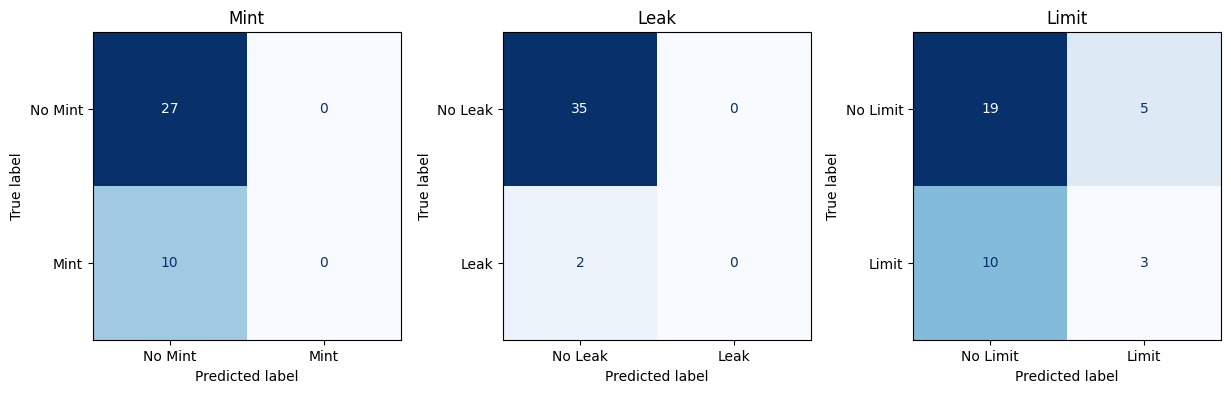

In [15]:
dataset = load_data(mode='cfg')[0]
loader = DataLoader(dataset, batch_size=128, shuffle=True)
y_true, y_pred, _ = val_model(model, loader, thresholds)

plot_confusion_matrix(y_true, y_pred, label_cols)

              precision    recall  f1-score   support

        Mint       0.00      0.00      0.00        10
        Leak       0.00      0.00      0.00         2
       Limit       0.38      0.23      0.29        13

   micro avg       0.38      0.12      0.18        25
   macro avg       0.12      0.08      0.10        25
weighted avg       0.20      0.12      0.15        25
 samples avg       0.08      0.07      0.07        25



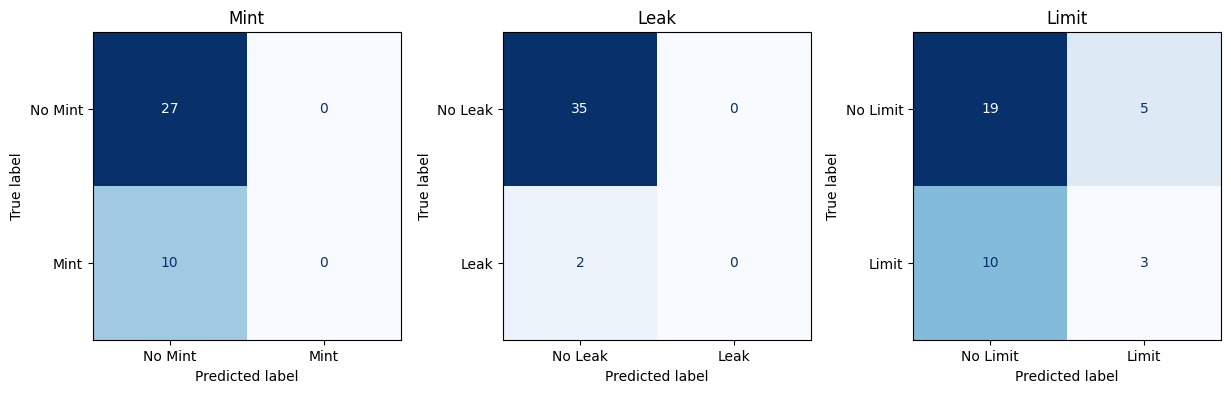

In [16]:
import torch
import json

# Load best parameters
with open("cfg_best_params.json", "r") as f:
    best_params = json.load(f)

# Get input and output channels (assuming they are consistent with training)
dataset_info, in_channels, label_cols = load_data(mode='txn')
out_channels = len(label_cols)

# Initialize the model with the loaded parameters
loaded_model = GCN(in_channels=in_channels, hidden=best_params['hidden_dim'], out_channels=out_channels, dropout=best_params['dropout'])

# Load the state dictionary
loaded_model.load_state_dict(torch.load("cfg_model.pth"))

thresholds = best_params['thresholds']
# Assuming 'loader' and 'thresholds' are already defined from previous cells
y_true, y_pred, _ = val_model(loaded_model, loader, thresholds)

plot_confusion_matrix(y_true, y_pred, label_cols)